In [3]:
!git clone https://github.com/aashwinmishra/lcls_beamline_toolbox

fatal: destination path 'lcls_beamline_toolbox' already exists and is not an empty directory.


In [4]:
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e . -q
!pip install xraydb -q
!pip install xopt -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 22.7 MB/s eta 0:00:00


In [5]:
!pip install scipy==1.10.0

  Using cached scipy-1.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached scipy-1.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xopt 2.6.0 requires scipy>=1.10.1, but you have scipy 1.10.0 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, but you have scipy 1.10.0 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
cvxpy 1.6.4 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
scikit-image 0.25.2 requires scipy>=1

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import trange
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from scipy.stats import qmc
from split_and_delay import SND

import torch
import gpytorch
import botorch
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator, ExpectedImprovementGenerator, TDUpperConfidenceBoundGenerator, TDExpectedImprovementGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

In [2]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*5e-6 - 2.5e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])



    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append([(do_centroid)*1e6, my_intensity/(61441.4336)])
    del snd
  return torch.tensor(result, dtype=torch.float)

In [21]:
input = np.ones((1,8)) * 0.63
get_snd_outputs(input)

tensor([[8.5015, 1.0246]])

In [18]:
def f(input_dict: dict) -> dict:
  current_time = time.time()
  temp = current_time - start_time
  if temp > 50:
    t = current_time - start_time
  else:
    t = 0.0
  drift_mag = 0.000025
  print(f"Shift: {t*drift_mag}")
  drift_dir = np.array([1, -1, -1, 1, 1, 1, -1, -1])
  noise = np.random.rand(8) * drift_mag * 0.01
  drift_vec = drift_mag * drift_dir + noise
  drift = t * drift_vec

  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"] + drift[0], input_dict["x2"] + drift[1], input_dict["x3"] + drift[2], input_dict["x4"] + drift[3], input_dict["x5"] + drift[4], input_dict["x6"] + drift[5], input_dict["x7"] + drift[6], input_dict["x8"] + drift[7]

  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp)
  f = output[0][0].item()
  c = output[0][1].item()
  return {"f": f, "c": c ,"time": float(current_time)}

In [11]:
def eval_function(input_dict: dict) -> dict:
  drift = 0.01
  if time > 20:
    x1, x2, x3, x4 = input_dict["x1"] + time*drift, input_dict["x2"] + time*drift, input_dict["x3"] + time*drift, input_dict["x4"] + time*drift
  else:
    x1, x2, x3, x4 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [19]:
low =  0.0
high = 1.0
n_init = 128

vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high],
                 "x5": [low, high],
                "x6": [low, high],
                "x7": [low, high],
                "x8": [low, high],
                 },
    objectives = {"f": "MINIMIZE"},
    constraints={"c": ["GREATER_THAN", 0.75]},
  )

evaluator = Evaluator(function=f)

generator = TDUpperConfidenceBoundGenerator(
    vocs=vocs,
    beta=0.00001,
    added_time=0.1,
    forgetting_time=200.0, #change this from 100
)
generator.n_monte_carlo_samples = 128
generator.numerical_optimizer.n_restarts = 20
generator.max_travel_distances = [4.0] * 8

start_time = time.time()
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
#X.random_evaluate(128)
sampler = qmc.LatinHypercube(d=8)
xs = sampler.random(n=n_init)
xs -= 0.5
xs /= 10
xs += 0.5

init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

for i in trange(700):
  print(f"Step: {i+1} \t Time: {time.time() - start_time}")
  X.step()
  currentstate = X.generator.data["f"][-1:]
  currentconstraint = X.generator.data["c"][-1:]
  print(f"Current State: {currentstate} \t Current Constraint: {currentconstraint}")
  time.sleep(0.1)

Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0

  0%|          | 0/700 [00:00<?, ?it/s]

Step: 1 	 Time: 42.27876329421997
Shift: 0.0015029390394687653
Current State: 128    0.400419
Name: f, dtype: float64 	 Current Constraint: 128    1.00973
Name: c, dtype: float64


  0%|          | 1/700 [00:18<3:32:05, 18.21s/it]

Step: 2 	 Time: 60.48575758934021
Shift: 0.0019754038214683536
Current State: 129    1.335046
Name: f, dtype: float64 	 Current Constraint: 129    1.005636
Name: c, dtype: float64


  0%|          | 2/700 [00:37<3:37:36, 18.71s/it]

Step: 3 	 Time: 79.54181408882141
Shift: 0.002413008314371109
Current State: 130    0.681047
Name: f, dtype: float64 	 Current Constraint: 130    1.011394
Name: c, dtype: float64


  0%|          | 3/700 [00:54<3:30:05, 18.09s/it]

Step: 4 	 Time: 96.88914823532104
Shift: 0.0027469593465328217
Current State: 131    0.38431
Name: f, dtype: float64 	 Current Constraint: 131    1.008881
Name: c, dtype: float64


  1%|          | 4/700 [01:07<3:08:08, 16.22s/it]

Step: 5 	 Time: 110.24563550949097
Shift: 0.0033912858188152313
Current State: 132    0.409818
Name: f, dtype: float64 	 Current Constraint: 132    1.011049
Name: c, dtype: float64


  1%|          | 5/700 [01:33<3:47:48, 19.67s/it]

Step: 6 	 Time: 136.02542519569397
Shift: 0.0037813209235668184
Current State: 133    0.179933
Name: f, dtype: float64 	 Current Constraint: 133    1.011389
Name: c, dtype: float64


  1%|          | 6/700 [01:49<3:31:33, 18.29s/it]

Step: 7 	 Time: 151.6437349319458
Shift: 0.004266199654340744
Current State: 134    0.174206
Name: f, dtype: float64 	 Current Constraint: 134    1.010147
Name: c, dtype: float64


  1%|          | 7/700 [02:08<3:35:19, 18.64s/it]

Step: 8 	 Time: 171.01414942741394
Shift: 0.004708198893070221
Current State: 135    0.17251
Name: f, dtype: float64 	 Current Constraint: 135    1.011422
Name: c, dtype: float64


  1%|          | 8/700 [02:26<3:31:30, 18.34s/it]

Step: 9 	 Time: 188.70299124717712
Shift: 0.005043520545959473
Current State: 136    0.16751
Name: f, dtype: float64 	 Current Constraint: 136    1.011577
Name: c, dtype: float64


  1%|▏         | 9/700 [02:39<3:13:29, 16.80s/it]

Step: 10 	 Time: 202.12306761741638
Shift: 0.005461600905656815
Current State: 137    0.296007
Name: f, dtype: float64 	 Current Constraint: 137    1.012179
Name: c, dtype: float64


  1%|▏         | 10/700 [02:56<3:12:53, 16.77s/it]

Step: 11 	 Time: 218.83476448059082
Shift: 0.005764184337854385
Current State: 138    1.070796
Name: f, dtype: float64 	 Current Constraint: 138    1.011359
Name: c, dtype: float64


  2%|▏         | 11/700 [03:08<2:56:19, 15.35s/it]

Step: 12 	 Time: 230.9703106880188
Shift: 0.005812696325778961
Current State: 139    1.005219
Name: f, dtype: float64 	 Current Constraint: 139    1.011623
Name: c, dtype: float64


  2%|▏         | 12/700 [03:10<2:09:26, 11.29s/it]

Step: 13 	 Time: 232.95980167388916
Shift: 0.005871728026866913
Current State: 140    0.154987
Name: f, dtype: float64 	 Current Constraint: 140    1.009689
Name: c, dtype: float64


  2%|▏         | 13/700 [03:13<1:38:44,  8.62s/it]

Step: 14 	 Time: 235.45213055610657
Shift: 0.005942308992147446
Current State: 141    0.453623
Name: f, dtype: float64 	 Current Constraint: 141    1.010499
Name: c, dtype: float64


  2%|▏         | 14/700 [03:15<1:17:52,  6.81s/it]

Step: 15 	 Time: 238.0730013847351
Shift: 0.006012416887283325
Current State: 142    1.108301
Name: f, dtype: float64 	 Current Constraint: 142    1.011452
Name: c, dtype: float64


  2%|▏         | 15/700 [03:18<1:03:56,  5.60s/it]

Step: 16 	 Time: 240.86901688575745
Shift: 0.006038178896903992
Current State: 143    39.232964
Name: f, dtype: float64 	 Current Constraint: 143    1.000281
Name: c, dtype: float64


  2%|▏         | 16/700 [03:19<48:09,  4.22s/it]  

Step: 17 	 Time: 241.89619779586792
Shift: 0.006348501819372177
Current State: 144    3.312558
Name: f, dtype: float64 	 Current Constraint: 144    1.007451
Name: c, dtype: float64


  2%|▏         | 17/700 [03:32<1:16:08,  6.69s/it]

Step: 18 	 Time: 254.31616926193237
Shift: 0.006606495606899262
Current State: 145    2.845279
Name: f, dtype: float64 	 Current Constraint: 145    1.009158
Name: c, dtype: float64


  3%|▎         | 18/700 [03:42<1:28:27,  7.78s/it]

Step: 19 	 Time: 264.64436888694763
Shift: 0.006864321750402451
Current State: 146    2.096167
Name: f, dtype: float64 	 Current Constraint: 146    1.008927
Name: c, dtype: float64


  3%|▎         | 19/700 [03:52<1:36:54,  8.54s/it]

Step: 20 	 Time: 274.9429540634155
Shift: 0.0069996988654136665
Current State: 147    10.696655
Name: f, dtype: float64 	 Current Constraint: 147    1.015431
Name: c, dtype: float64


  3%|▎         | 20/700 [03:58<1:26:09,  7.60s/it]

Step: 21 	 Time: 280.3661093711853
Shift: 0.007210700571537018
Current State: 148    6.239593
Name: f, dtype: float64 	 Current Constraint: 148    1.007102
Name: c, dtype: float64


  3%|▎         | 21/700 [04:06<1:28:49,  7.85s/it]

Step: 22 	 Time: 288.79051423072815
Shift: 0.007627928441762925
Current State: 149    1.536955
Name: f, dtype: float64 	 Current Constraint: 149    1.01086
Name: c, dtype: float64


  3%|▎         | 22/700 [04:23<1:58:42, 10.51s/it]

Step: 23 	 Time: 305.4900891780853
Shift: 0.00773766725063324
Current State: 150    0.75961
Name: f, dtype: float64 	 Current Constraint: 150    1.010178
Name: c, dtype: float64


  3%|▎         | 23/700 [04:27<1:37:53,  8.68s/it]

Step: 24 	 Time: 309.897225856781
Shift: 0.00787634882926941
Current State: 151    0.643272
Name: f, dtype: float64 	 Current Constraint: 151    1.0109
Name: c, dtype: float64


  3%|▎         | 24/700 [04:33<1:27:05,  7.73s/it]

Step: 25 	 Time: 315.4234445095062
Shift: 0.00791515486240387
Current State: 152    0.385581
Name: f, dtype: float64 	 Current Constraint: 152    1.010869
Name: c, dtype: float64


  4%|▎         | 25/700 [04:34<1:06:06,  5.88s/it]

Step: 26 	 Time: 316.973037481308
Shift: 0.00795704578757286
Current State: 153    1.144107
Name: f, dtype: float64 	 Current Constraint: 153    1.009963
Name: c, dtype: float64


  4%|▎         | 26/700 [04:36<51:52,  4.62s/it]  

Step: 27 	 Time: 318.65358114242554
Shift: 0.007993116807937623
Current State: 154    7.215516
Name: f, dtype: float64 	 Current Constraint: 154    1.009077
Name: c, dtype: float64


  4%|▍         | 27/700 [04:37<41:05,  3.66s/it]

Step: 28 	 Time: 320.0902101993561
Shift: 0.008071048438549042
Current State: 155    1.084304
Name: f, dtype: float64 	 Current Constraint: 155    1.011256
Name: c, dtype: float64


  4%|▍         | 28/700 [04:41<39:39,  3.54s/it]

Step: 29 	 Time: 323.34652519226074
Shift: 0.008119777864217758
Current State: 156    3.301518
Name: f, dtype: float64 	 Current Constraint: 156    1.012777
Name: c, dtype: float64


  4%|▍         | 29/700 [04:43<34:22,  3.07s/it]

Step: 30 	 Time: 325.32899618148804
Shift: 0.008170631670951844
Current State: 157    0.547063
Name: f, dtype: float64 	 Current Constraint: 157    1.010099
Name: c, dtype: float64


  4%|▍         | 30/700 [04:44<30:16,  2.71s/it]

Step: 31 	 Time: 327.19550108909607
Shift: 0.008275617998838426
Current State: 158    0.88327
Name: f, dtype: float64 	 Current Constraint: 158    1.010952
Name: c, dtype: float64


  4%|▍         | 31/700 [04:49<35:12,  3.16s/it]

Step: 32 	 Time: 331.39503169059753
Shift: 0.008302969306707382
Current State: 159    5.629541
Name: f, dtype: float64 	 Current Constraint: 159    1.009431
Name: c, dtype: float64


  5%|▍         | 32/700 [04:50<28:16,  2.54s/it]

Step: 33 	 Time: 332.4905495643616
Shift: 0.00850428768992424
Current State: 160    0.44984
Name: f, dtype: float64 	 Current Constraint: 160    1.010094
Name: c, dtype: float64


  5%|▍         | 33/700 [04:58<46:37,  4.19s/it]

Step: 34 	 Time: 340.54456639289856
Shift: 0.008728848230838776
Current State: 161    0.63786
Name: f, dtype: float64 	 Current Constraint: 161    1.011461
Name: c, dtype: float64


  5%|▍         | 34/700 [05:07<1:03:07,  5.69s/it]

Step: 35 	 Time: 349.718466758728
Shift: 0.009040582036972047
Current State: 162    0.324625
Name: f, dtype: float64 	 Current Constraint: 162    1.010641
Name: c, dtype: float64


  5%|▌         | 35/700 [05:19<1:25:18,  7.70s/it]

Step: 36 	 Time: 362.10423016548157
Shift: 0.009244944447278977
Current State: 163    0.763432
Name: f, dtype: float64 	 Current Constraint: 163    1.010693
Name: c, dtype: float64


  5%|▌         | 36/700 [05:27<1:26:32,  7.82s/it]

Step: 37 	 Time: 370.21186685562134
Shift: 0.009500654101371766
Current State: 164    0.177479
Name: f, dtype: float64 	 Current Constraint: 164    1.010576
Name: c, dtype: float64


  5%|▌         | 37/700 [05:38<1:34:17,  8.53s/it]

Step: 38 	 Time: 380.40582966804504
Shift: 0.009779984152317048
Current State: 165    0.652497
Name: f, dtype: float64 	 Current Constraint: 165    1.009917
Name: c, dtype: float64


  5%|▌         | 38/700 [05:49<1:42:55,  9.33s/it]

Step: 39 	 Time: 391.5912685394287
Shift: 0.010057669258117677
Current State: 166    0.216265
Name: f, dtype: float64 	 Current Constraint: 166    1.011145
Name: c, dtype: float64


  6%|▌         | 39/700 [06:00<1:49:03,  9.90s/it]

Step: 40 	 Time: 402.82538962364197
Shift: 0.01015100720524788
Current State: 167    0.234311
Name: f, dtype: float64 	 Current Constraint: 167    1.010484
Name: c, dtype: float64


  6%|▌         | 40/700 [06:04<1:28:03,  8.01s/it]

Step: 41 	 Time: 406.4099004268646
Shift: 0.010448519456386567
Current State: 168    0.211515
Name: f, dtype: float64 	 Current Constraint: 168    1.010971
Name: c, dtype: float64


  6%|▌         | 41/700 [06:16<1:40:46,  9.18s/it]

Step: 42 	 Time: 418.31457471847534
Shift: 0.010633587557077408
Current State: 169    0.198577
Name: f, dtype: float64 	 Current Constraint: 169    1.010606
Name: c, dtype: float64


  6%|▌         | 42/700 [06:23<1:34:46,  8.64s/it]

Step: 43 	 Time: 425.7119948863983
Shift: 0.010867640346288681
Current State: 170    0.434823
Name: f, dtype: float64 	 Current Constraint: 170    1.010758
Name: c, dtype: float64


  6%|▌         | 43/700 [06:32<1:37:00,  8.86s/it]

Step: 44 	 Time: 435.0803816318512
Shift: 0.01111625879406929
Current State: 171    2.790954
Name: f, dtype: float64 	 Current Constraint: 171    1.010662
Name: c, dtype: float64


  6%|▋         | 44/700 [06:42<1:40:26,  9.19s/it]

Step: 45 	 Time: 445.0274269580841
Shift: 0.011163896781206132
Current State: 172    1.790695
Name: f, dtype: float64 	 Current Constraint: 172    1.009623
Name: c, dtype: float64


  6%|▋         | 45/700 [06:44<1:16:27,  7.00s/it]

Step: 46 	 Time: 446.93900847435
Shift: 0.011215812236070634
Current State: 173    1.413254
Name: f, dtype: float64 	 Current Constraint: 173    1.010008
Name: c, dtype: float64


  7%|▋         | 46/700 [06:46<1:00:12,  5.52s/it]

Step: 47 	 Time: 449.0075886249542
Shift: 0.011325699561834336
Current State: 174    0.521505
Name: f, dtype: float64 	 Current Constraint: 174    1.009819
Name: c, dtype: float64


  7%|▋         | 47/700 [06:51<56:43,  5.21s/it]  

Step: 48 	 Time: 453.4963138103485
Shift: 0.01139603717327118
Current State: 175    0.596349
Name: f, dtype: float64 	 Current Constraint: 175    1.010836
Name: c, dtype: float64


  7%|▋         | 48/700 [06:53<48:30,  4.46s/it]

Step: 49 	 Time: 456.2109603881836
Shift: 0.01151385407447815
Current State: 176    1.124092
Name: f, dtype: float64 	 Current Constraint: 176    1.010759
Name: c, dtype: float64


  7%|▋         | 49/700 [06:58<49:16,  4.54s/it]

Step: 50 	 Time: 460.9365427494049
Shift: 0.011624112164974214
Current State: 177    0.705108
Name: f, dtype: float64 	 Current Constraint: 177    1.011069
Name: c, dtype: float64


  7%|▋         | 50/700 [07:03<49:21,  4.56s/it]

Step: 51 	 Time: 465.52544140815735
Shift: 0.011807955294847489
Current State: 178    0.683406
Name: f, dtype: float64 	 Current Constraint: 178    1.011083
Name: c, dtype: float64


  7%|▋         | 51/700 [07:10<57:44,  5.34s/it]

Step: 52 	 Time: 472.68851375579834
Shift: 0.011854456752538682
Current State: 179    0.415354
Name: f, dtype: float64 	 Current Constraint: 179    1.011957
Name: c, dtype: float64


  7%|▋         | 52/700 [07:12<46:22,  4.29s/it]

Step: 53 	 Time: 474.5453586578369
Shift: 0.011898586201667786
Current State: 180    0.388803
Name: f, dtype: float64 	 Current Constraint: 180    1.011812
Name: c, dtype: float64


  8%|▊         | 53/700 [07:14<38:06,  3.53s/it]

Step: 54 	 Time: 476.3062074184418
Shift: 0.012010382556915283
Current State: 181    0.352387
Name: f, dtype: float64 	 Current Constraint: 181    1.011962
Name: c, dtype: float64


  8%|▊         | 54/700 [07:18<41:04,  3.82s/it]

Step: 55 	 Time: 480.77915692329407
Shift: 0.012094754230976106
Current State: 182    1.006099
Name: f, dtype: float64 	 Current Constraint: 182    1.011629
Name: c, dtype: float64


  8%|▊         | 55/700 [07:21<39:38,  3.69s/it]

Step: 56 	 Time: 484.16553568840027
Shift: 0.012143484383821488
Current State: 183    0.428731
Name: f, dtype: float64 	 Current Constraint: 183    1.010396
Name: c, dtype: float64


  8%|▊         | 56/700 [07:23<33:57,  3.16s/it]

Step: 57 	 Time: 486.1069145202637
Shift: 0.01223299036026001
Current State: 184    0.3876
Name: f, dtype: float64 	 Current Constraint: 184    1.01284
Name: c, dtype: float64


  8%|▊         | 57/700 [07:27<35:14,  3.29s/it]

Step: 58 	 Time: 489.68915939331055
Shift: 0.01230871309041977
Current State: 185    0.530785
Name: f, dtype: float64 	 Current Constraint: 185    1.010805
Name: c, dtype: float64


  8%|▊         | 58/700 [07:30<35:02,  3.28s/it]

Step: 59 	 Time: 492.93438601493835
Shift: 0.0124758904337883
Current State: 186    0.235961
Name: f, dtype: float64 	 Current Constraint: 186    1.01256
Name: c, dtype: float64


  8%|▊         | 59/700 [07:37<45:13,  4.23s/it]

Step: 60 	 Time: 499.4001166820526
Shift: 0.01257350419163704
Current State: 187    0.3049
Name: f, dtype: float64 	 Current Constraint: 187    1.012925
Name: c, dtype: float64


  9%|▊         | 60/700 [07:41<44:19,  4.15s/it]

Step: 61 	 Time: 503.37311816215515
Shift: 0.012680801522731782
Current State: 188    0.688397
Name: f, dtype: float64 	 Current Constraint: 188    1.010891
Name: c, dtype: float64


  9%|▊         | 61/700 [07:45<44:29,  4.18s/it]

Step: 62 	 Time: 507.60279726982117
Shift: 0.01272529913187027
Current State: 189    0.388187
Name: f, dtype: float64 	 Current Constraint: 189    1.01062
Name: c, dtype: float64


  9%|▉         | 62/700 [07:47<36:46,  3.46s/it]

Step: 63 	 Time: 509.3815793991089
Shift: 0.012771790820360184
Current State: 190    0.349131
Name: f, dtype: float64 	 Current Constraint: 190    1.012145
Name: c, dtype: float64


  9%|▉         | 63/700 [07:48<31:40,  2.98s/it]

Step: 64 	 Time: 511.2561717033386
Shift: 0.012859457290172578
Current State: 191    0.387098
Name: f, dtype: float64 	 Current Constraint: 191    1.01081
Name: c, dtype: float64


  9%|▉         | 64/700 [07:52<33:12,  3.13s/it]

Step: 65 	 Time: 514.7380566596985
Shift: 0.013000092595815659
Current State: 192    0.391082
Name: f, dtype: float64 	 Current Constraint: 192    1.011282
Name: c, dtype: float64


  9%|▉         | 65/700 [07:58<41:04,  3.88s/it]

Step: 66 	 Time: 520.3663465976715
Shift: 0.013023568749427797
Current State: 193    9.338202
Name: f, dtype: float64 	 Current Constraint: 193    1.013849
Name: c, dtype: float64


  9%|▉         | 66/700 [07:59<31:40,  3.00s/it]

Step: 67 	 Time: 521.3023686408997
Shift: 0.013185842204093934
Current State: 194    0.534318
Name: f, dtype: float64 	 Current Constraint: 194    1.010741
Name: c, dtype: float64


 10%|▉         | 67/700 [08:05<42:44,  4.05s/it]

Step: 68 	 Time: 527.8100805282593
Shift: 0.013437320232391359
Current State: 195    0.457873
Name: f, dtype: float64 	 Current Constraint: 195    1.011309
Name: c, dtype: float64


 10%|▉         | 68/700 [08:15<1:01:36,  5.85s/it]

Step: 69 	 Time: 537.8544926643372
Shift: 0.013699290037155152
Current State: 196    0.72997
Name: f, dtype: float64 	 Current Constraint: 196    1.011172
Name: c, dtype: float64


 10%|▉         | 69/700 [08:26<1:16:07,  7.24s/it]

Step: 70 	 Time: 548.334233045578
Shift: 0.013856301552057268
Current State: 197    0.343811
Name: f, dtype: float64 	 Current Constraint: 197    1.011252
Name: c, dtype: float64


 10%|█         | 70/700 [08:32<1:13:00,  6.95s/it]

Step: 71 	 Time: 554.6236207485199
Shift: 0.014116670906543732
Current State: 198    0.395452
Name: f, dtype: float64 	 Current Constraint: 198    1.012945
Name: c, dtype: float64


 10%|█         | 71/700 [08:42<1:24:21,  8.05s/it]

Step: 72 	 Time: 565.2239670753479
Shift: 0.014410372656583787
Current State: 199    0.414193
Name: f, dtype: float64 	 Current Constraint: 199    1.01134
Name: c, dtype: float64


 10%|█         | 72/700 [08:54<1:35:16,  9.10s/it]

Step: 73 	 Time: 576.7866141796112
Shift: 0.014629130476713182
Current State: 200    0.485414
Name: f, dtype: float64 	 Current Constraint: 200    1.011569
Name: c, dtype: float64


 10%|█         | 73/700 [09:03<1:34:00,  9.00s/it]

Step: 74 	 Time: 585.5340812206268
Shift: 0.014781422209739686
Current State: 201    0.416351
Name: f, dtype: float64 	 Current Constraint: 201    1.011946
Name: c, dtype: float64


 11%|█         | 74/700 [09:09<1:24:45,  8.12s/it]

Step: 75 	 Time: 591.6240177154541
Shift: 0.01501515591144562
Current State: 202    0.419474
Name: f, dtype: float64 	 Current Constraint: 202    1.012307
Name: c, dtype: float64


 11%|█         | 75/700 [09:18<1:28:25,  8.49s/it]

Step: 76 	 Time: 600.9654099941254
Shift: 0.015044344609975816
Current State: 203    29.951097
Name: f, dtype: float64 	 Current Constraint: 203    1.003713
Name: c, dtype: float64


 11%|█         | 76/700 [09:19<1:05:28,  6.30s/it]

Step: 77 	 Time: 602.142974615097
Shift: 0.01521086112856865
Current State: 204    0.337926
Name: f, dtype: float64 	 Current Constraint: 204    1.011856
Name: c, dtype: float64


 11%|█         | 77/700 [09:26<1:07:07,  6.46s/it]

Step: 78 	 Time: 609.0031933784485
Shift: 0.015474465727806091
Current State: 205    0.898281
Name: f, dtype: float64 	 Current Constraint: 205    1.012656
Name: c, dtype: float64


 11%|█         | 78/700 [09:37<1:19:22,  7.66s/it]

Step: 79 	 Time: 619.4378941059113
Shift: 0.015759472596645355
Current State: 206    0.543681
Name: f, dtype: float64 	 Current Constraint: 206    1.01209
Name: c, dtype: float64


 11%|█▏        | 79/700 [09:48<1:30:39,  8.76s/it]

Step: 80 	 Time: 630.771959066391
Shift: 0.015994072073698046
Current State: 207    3.402498
Name: f, dtype: float64 	 Current Constraint: 207    1.011088
Name: c, dtype: float64


 11%|█▏        | 80/700 [09:57<1:32:27,  8.95s/it]

Step: 81 	 Time: 640.1585702896118
Shift: 0.01631022602915764
Current State: 208    0.438014
Name: f, dtype: float64 	 Current Constraint: 208    1.01321
Name: c, dtype: float64


 12%|█▏        | 81/700 [10:10<1:43:39, 10.05s/it]

Step: 82 	 Time: 652.7710971832275
Shift: 0.01654545413851738
Current State: 209    0.714601
Name: f, dtype: float64 	 Current Constraint: 209    1.011338
Name: c, dtype: float64


 12%|█▏        | 82/700 [10:19<1:41:32,  9.86s/it]

Step: 83 	 Time: 662.1894257068634
Shift: 0.01701779251098633
Current State: 210    1.797907
Name: f, dtype: float64 	 Current Constraint: 210    1.012227
Name: c, dtype: float64


 12%|█▏        | 83/700 [10:38<2:09:14, 12.57s/it]

Step: 84 	 Time: 681.0806660652161
Shift: 0.01730000203251839
Current State: 211    1.19181
Name: f, dtype: float64 	 Current Constraint: 211    1.010984
Name: c, dtype: float64


 12%|█▏        | 84/700 [10:50<2:05:04, 12.18s/it]

Step: 85 	 Time: 692.3625988960266
Shift: 0.017540571928024294
Current State: 212    2.206067
Name: f, dtype: float64 	 Current Constraint: 212    1.010941
Name: c, dtype: float64


 12%|█▏        | 85/700 [10:59<1:57:02, 11.42s/it]

Step: 86 	 Time: 701.998307466507
Shift: 0.017989006221294405
Current State: 213    4.175601
Name: f, dtype: float64 	 Current Constraint: 213    1.011599
Name: c, dtype: float64


 12%|█▏        | 86/700 [11:17<2:16:52, 13.38s/it]

Step: 87 	 Time: 719.9394242763519
Shift: 0.018280319553613665
Current State: 214    2.160074
Name: f, dtype: float64 	 Current Constraint: 214    1.009581
Name: c, dtype: float64


 12%|█▏        | 87/700 [11:29<2:11:22, 12.86s/it]

Step: 88 	 Time: 731.591187953949
Shift: 0.018533669942617417
Current State: 215    2.072679
Name: f, dtype: float64 	 Current Constraint: 215    1.011043
Name: c, dtype: float64


 13%|█▎        | 88/700 [11:39<2:02:49, 12.04s/it]

Step: 89 	 Time: 741.7257254123688
Shift: 0.018582807219028472
Current State: 216    0.785561
Name: f, dtype: float64 	 Current Constraint: 216    1.010849
Name: c, dtype: float64


 13%|█▎        | 89/700 [11:41<1:31:49,  9.02s/it]

Step: 90 	 Time: 743.6874234676361
Shift: 0.018824003845453262
Current State: 217    1.483583
Name: f, dtype: float64 	 Current Constraint: 217    1.007815
Name: c, dtype: float64


 13%|█▎        | 90/700 [11:51<1:33:34,  9.20s/it]

Step: 91 	 Time: 753.3258707523346
Shift: 0.019030726128816604
Current State: 218    1.770598
Name: f, dtype: float64 	 Current Constraint: 218    1.008333
Name: c, dtype: float64


 13%|█▎        | 91/700 [11:59<1:30:35,  8.92s/it]

Step: 92 	 Time: 761.6002562046051
Shift: 0.01929000629782677
Current State: 219    0.93622
Name: f, dtype: float64 	 Current Constraint: 219    1.010683
Name: c, dtype: float64


 13%|█▎        | 92/700 [12:09<1:34:49,  9.36s/it]

Step: 93 	 Time: 771.9654266834259
Shift: 0.01949665841460228
Current State: 220    0.329153
Name: f, dtype: float64 	 Current Constraint: 220    1.010317
Name: c, dtype: float64


 13%|█▎        | 93/700 [12:17<1:31:20,  9.03s/it]

Step: 94 	 Time: 780.2292683124542
Shift: 0.01979219983816147
Current State: 221    0.306876
Name: f, dtype: float64 	 Current Constraint: 221    1.009835
Name: c, dtype: float64


 13%|█▎        | 94/700 [12:29<1:39:44,  9.87s/it]

Step: 95 	 Time: 792.0779256820679
Shift: 0.019985246199369432
Current State: 222    0.687449
Name: f, dtype: float64 	 Current Constraint: 222    1.011007
Name: c, dtype: float64


 14%|█▎        | 95/700 [12:37<1:33:00,  9.22s/it]

Step: 96 	 Time: 799.7806851863861
Shift: 0.020285375672578813
Current State: 223    0.451175
Name: f, dtype: float64 	 Current Constraint: 223    1.009831
Name: c, dtype: float64


 14%|█▎        | 96/700 [12:49<1:41:17, 10.06s/it]

Step: 97 	 Time: 811.7988708019257
Shift: 0.02031603406071663
Current State: 224    17.572577
Name: f, dtype: float64 	 Current Constraint: 224    1.015581
Name: c, dtype: float64


 14%|█▍        | 97/700 [12:50<1:14:25,  7.41s/it]

Step: 98 	 Time: 813.0056552886963
Shift: 0.0205578899204731
Current State: 225    0.503447
Name: f, dtype: float64 	 Current Constraint: 225    1.009261
Name: c, dtype: float64


 14%|█▍        | 98/700 [13:00<1:21:09,  8.09s/it]

Step: 99 	 Time: 822.6879239082336
Shift: 0.020823304808139802
Current State: 226    0.436044
Name: f, dtype: float64 	 Current Constraint: 226    1.009328
Name: c, dtype: float64


 14%|█▍        | 99/700 [13:11<1:28:36,  8.85s/it]

Step: 100 	 Time: 833.3041808605194
Shift: 0.02097665417790413
Current State: 227    1.804561
Name: f, dtype: float64 	 Current Constraint: 227    1.006942
Name: c, dtype: float64


 14%|█▍        | 100/700 [13:17<1:20:19,  8.03s/it]

Step: 101 	 Time: 839.4350528717041
Shift: 0.021168027710914614
Current State: 228    2.290858
Name: f, dtype: float64 	 Current Constraint: 228    1.009419
Name: c, dtype: float64


 14%|█▍        | 101/700 [13:24<1:19:04,  7.92s/it]

Step: 102 	 Time: 847.0969157218933
Shift: 0.02145689832568169
Current State: 229    1.58097
Name: f, dtype: float64 	 Current Constraint: 229    1.011202
Name: c, dtype: float64


 15%|█▍        | 102/700 [13:36<1:29:46,  9.01s/it]

Step: 103 	 Time: 858.6425881385803
Shift: 0.02155247381925583
Current State: 230    1.160465
Name: f, dtype: float64 	 Current Constraint: 230    1.009572
Name: c, dtype: float64


 15%|█▍        | 103/700 [13:40<1:14:16,  7.47s/it]

Step: 104 	 Time: 862.5065915584564
Shift: 0.021630970263481143
Current State: 231    0.949791
Name: f, dtype: float64 	 Current Constraint: 231    1.009347
Name: c, dtype: float64


 15%|█▍        | 104/700 [13:43<1:01:10,  6.16s/it]

Step: 105 	 Time: 865.6152756214142
Shift: 0.021786984342336654
Current State: 232    1.048383
Name: f, dtype: float64 	 Current Constraint: 232    1.010698
Name: c, dtype: float64


 15%|█▌        | 105/700 [13:49<1:01:19,  6.18s/it]

Step: 106 	 Time: 871.8620703220367
Shift: 0.0218775031208992
Current State: 233    0.982014
Name: f, dtype: float64 	 Current Constraint: 233    1.00915
Name: c, dtype: float64


 15%|█▌        | 106/700 [13:53<53:33,  5.41s/it]  

Step: 107 	 Time: 875.465523481369
Shift: 0.02197800117135048
Current State: 234    0.8982
Name: f, dtype: float64 	 Current Constraint: 234    1.010697
Name: c, dtype: float64


 15%|█▌        | 107/700 [13:57<49:49,  5.04s/it]

Step: 108 	 Time: 879.644106388092
Shift: 0.022199691236019135
Current State: 235    0.584052
Name: f, dtype: float64 	 Current Constraint: 235    1.00851
Name: c, dtype: float64


 15%|█▌        | 108/700 [14:06<1:00:35,  6.14s/it]

Step: 109 	 Time: 888.3523943424225
Shift: 0.022403285390138628
Current State: 236    0.231655
Name: f, dtype: float64 	 Current Constraint: 236    1.009261
Name: c, dtype: float64


 16%|█▌        | 109/700 [14:14<1:06:25,  6.74s/it]

Step: 110 	 Time: 896.5022583007812
Shift: 0.022966444486379623
Current State: 237    0.652711
Name: f, dtype: float64 	 Current Constraint: 237    1.008122
Name: c, dtype: float64


 16%|█▌        | 110/700 [14:36<1:53:25, 11.53s/it]

Step: 111 	 Time: 919.2160997390747
Shift: 0.02314948526620865
Current State: 238    0.215815
Name: f, dtype: float64 	 Current Constraint: 238    1.009522
Name: c, dtype: float64


 16%|█▌        | 111/700 [14:44<1:40:14, 10.21s/it]

Step: 112 	 Time: 926.3413088321686
Shift: 0.023403410947322848
Current State: 239    0.459702
Name: f, dtype: float64 	 Current Constraint: 239    1.00802
Name: c, dtype: float64


 16%|█▌        | 112/700 [14:54<1:39:57, 10.20s/it]

Step: 113 	 Time: 936.5105574131012
Shift: 0.02358390480875969
Current State: 240    0.04215
Name: f, dtype: float64 	 Current Constraint: 240    1.008929
Name: c, dtype: float64


 16%|█▌        | 113/700 [15:01<1:31:15,  9.33s/it]

Step: 114 	 Time: 943.8032734394073
Shift: 0.023820890176296235
Current State: 241    0.377969
Name: f, dtype: float64 	 Current Constraint: 241    1.008088
Name: c, dtype: float64


 16%|█▋        | 114/700 [15:10<1:31:18,  9.35s/it]

Step: 115 	 Time: 953.2040657997131
Shift: 0.02405178838968277
Current State: 242    0.050072
Name: f, dtype: float64 	 Current Constraint: 242    1.007685
Name: c, dtype: float64


 16%|█▋        | 115/700 [15:20<1:30:50,  9.32s/it]

Step: 116 	 Time: 962.4438142776489
Shift: 0.024271904402971268
Current State: 243    0.058789
Name: f, dtype: float64 	 Current Constraint: 243    1.007895
Name: c, dtype: float64


 17%|█▋        | 116/700 [15:29<1:29:42,  9.22s/it]

Step: 117 	 Time: 971.4279799461365
Shift: 0.024629244685173034
Current State: 244    0.074651
Name: f, dtype: float64 	 Current Constraint: 244    1.006862
Name: c, dtype: float64


 17%|█▋        | 117/700 [15:43<1:43:52, 10.69s/it]

Step: 118 	 Time: 985.5579450130463
Shift: 0.024902680921554565
Current State: 245    0.0955
Name: f, dtype: float64 	 Current Constraint: 245    1.008485
Name: c, dtype: float64


 17%|█▋        | 118/700 [15:54<1:44:43, 10.80s/it]

Step: 119 	 Time: 996.6038315296173
Shift: 0.025079481780529024
Current State: 246    0.399834
Name: f, dtype: float64 	 Current Constraint: 246    1.007844
Name: c, dtype: float64


 17%|█▋        | 119/700 [16:01<1:33:21,  9.64s/it]

Step: 120 	 Time: 1003.5463576316833
Shift: 0.025316749674081804
Current State: 247    0.235779
Name: f, dtype: float64 	 Current Constraint: 247    1.007112
Name: c, dtype: float64


 17%|█▋        | 120/700 [16:10<1:32:47,  9.60s/it]

Step: 121 	 Time: 1013.0454287528992
Shift: 0.02534806996583939
Current State: 248    29.926121
Name: f, dtype: float64 	 Current Constraint: 248    1.003524
Name: c, dtype: float64


 17%|█▋        | 121/700 [16:12<1:08:26,  7.09s/it]

Step: 122 	 Time: 1014.2928829193115
Shift: 0.025542438590526583
Current State: 249    0.095804
Name: f, dtype: float64 	 Current Constraint: 249    1.008862
Name: c, dtype: float64


 17%|█▋        | 122/700 [16:19<1:10:43,  7.34s/it]

Step: 123 	 Time: 1022.2123596668243
Shift: 0.025773907148838045
Current State: 250    0.194643
Name: f, dtype: float64 	 Current Constraint: 250    1.008192
Name: c, dtype: float64


 18%|█▊        | 123/700 [16:29<1:15:41,  7.87s/it]

Step: 124 	 Time: 1031.3172860145569
Shift: 0.026017782366275787
Current State: 251    0.131271
Name: f, dtype: float64 	 Current Constraint: 251    1.008554
Name: c, dtype: float64


 18%|█▊        | 124/700 [16:38<1:21:01,  8.44s/it]

Step: 125 	 Time: 1041.0885469913483
Shift: 0.026064952796697616
Current State: 252    0.216697
Name: f, dtype: float64 	 Current Constraint: 252    1.011544
Name: c, dtype: float64


 18%|█▊        | 125/700 [16:40<1:02:01,  6.47s/it]

Step: 126 	 Time: 1042.966293334961
Shift: 0.026246591168642044
Current State: 253    0.881598
Name: f, dtype: float64 	 Current Constraint: 253    1.009031
Name: c, dtype: float64


 18%|█▊        | 126/700 [16:47<1:04:09,  6.71s/it]

Step: 127 	 Time: 1050.2228758335114
Shift: 0.026719206494092942
Current State: 254    0.682245
Name: f, dtype: float64 	 Current Constraint: 254    1.008672
Name: c, dtype: float64


 18%|█▊        | 127/700 [17:06<1:39:06, 10.38s/it]

Step: 128 	 Time: 1069.1671023368835
Shift: 0.026944180244207385
Current State: 255    1.854708
Name: f, dtype: float64 	 Current Constraint: 255    1.012308
Name: c, dtype: float64


 18%|█▊        | 128/700 [17:15<1:34:54,  9.96s/it]

Step: 129 	 Time: 1078.1384432315826
Shift: 0.027125357115268707
Current State: 256    0.110363
Name: f, dtype: float64 	 Current Constraint: 256    1.010812
Name: c, dtype: float64


 18%|█▊        | 129/700 [17:23<1:27:04,  9.15s/it]

Step: 130 	 Time: 1085.409240245819
Shift: 0.02738738559484482
Current State: 257    0.169402
Name: f, dtype: float64 	 Current Constraint: 257    1.01139
Name: c, dtype: float64


 19%|█▊        | 130/700 [17:33<1:30:38,  9.54s/it]

Step: 131 	 Time: 1095.8606235980988
Shift: 0.027542671293020248
Current State: 258    0.362908
Name: f, dtype: float64 	 Current Constraint: 258    1.011894
Name: c, dtype: float64


 19%|█▊        | 131/700 [17:39<1:21:06,  8.55s/it]

Step: 132 	 Time: 1102.10728764534
Shift: 0.027627199935913088
Current State: 259    0.200303
Name: f, dtype: float64 	 Current Constraint: 259    1.012091
Name: c, dtype: float64


 19%|█▉        | 132/700 [17:43<1:06:11,  6.99s/it]

Step: 133 	 Time: 1105.4609615802765
Shift: 0.02815473849773407
Current State: 260    1.931098
Name: f, dtype: float64 	 Current Constraint: 260    1.013124
Name: c, dtype: float64


 19%|█▉        | 133/700 [18:04<1:46:40, 11.29s/it]

Step: 134 	 Time: 1126.7739214897156
Shift: 0.02825936743617058
Current State: 261    3.518145
Name: f, dtype: float64 	 Current Constraint: 261    1.008945
Name: c, dtype: float64


 19%|█▉        | 134/700 [18:08<1:25:46,  9.09s/it]

Step: 135 	 Time: 1130.7444083690643
Shift: 0.02847920142412186
Current State: 262    1.954741
Name: f, dtype: float64 	 Current Constraint: 262    1.012172
Name: c, dtype: float64


 19%|█▉        | 135/700 [18:17<1:25:19,  9.06s/it]

Step: 136 	 Time: 1139.7285203933716
Shift: 0.028728522604703904
Current State: 263    0.879745
Name: f, dtype: float64 	 Current Constraint: 263    1.009927
Name: c, dtype: float64


 19%|█▉        | 136/700 [18:27<1:27:10,  9.27s/it]

Step: 137 	 Time: 1149.5024046897888
Shift: 0.02894073889255524
Current State: 264    0.932301
Name: f, dtype: float64 	 Current Constraint: 264    1.010002
Name: c, dtype: float64


 20%|█▉        | 137/700 [18:35<1:24:48,  9.04s/it]

Step: 138 	 Time: 1157.9870836734772
Shift: 0.029168790775537492
Current State: 265    0.629028
Name: f, dtype: float64 	 Current Constraint: 265    1.009305
Name: c, dtype: float64


 20%|█▉        | 138/700 [18:44<1:25:01,  9.08s/it]

Step: 139 	 Time: 1167.1551585197449
Shift: 0.029257082545757294
Current State: 266    0.256665
Name: f, dtype: float64 	 Current Constraint: 266    1.008673
Name: c, dtype: float64


 20%|█▉        | 139/700 [18:48<1:09:11,  7.40s/it]

Step: 140 	 Time: 1170.6445982456207
Shift: 0.029702163141965866
Current State: 267    4.458313
Name: f, dtype: float64 	 Current Constraint: 267    1.005678
Name: c, dtype: float64


 20%|██        | 140/700 [19:06<1:38:11, 10.52s/it]

Step: 141 	 Time: 1188.4462847709656
Shift: 0.029945091950893402
Current State: 268    3.044043
Name: f, dtype: float64 	 Current Constraint: 268    1.005658
Name: c, dtype: float64


 20%|██        | 141/700 [19:15<1:35:48, 10.28s/it]

Step: 142 	 Time: 1198.1783735752106
Shift: 0.030162011098861696
Current State: 269    1.815132
Name: f, dtype: float64 	 Current Constraint: 269    1.007365
Name: c, dtype: float64


 20%|██        | 142/700 [19:24<1:31:07,  9.80s/it]

Step: 143 	 Time: 1206.8429572582245
Shift: 0.03034959211945534
Current State: 270    2.017864
Name: f, dtype: float64 	 Current Constraint: 270    1.008271
Name: c, dtype: float64


 20%|██        | 143/700 [19:32<1:24:33,  9.11s/it]

Step: 144 	 Time: 1214.3431532382965
Shift: 0.030436527901887896
Current State: 271    63.332642
Name: f, dtype: float64 	 Current Constraint: 271    0.570512
Name: c, dtype: float64


 21%|██        | 144/700 [19:35<1:09:09,  7.46s/it]

Step: 145 	 Time: 1217.9646937847137
Shift: 0.030467474800348282
Current State: 272    13.039155
Name: f, dtype: float64 	 Current Constraint: 272    1.00495
Name: c, dtype: float64


 21%|██        | 145/700 [19:36<51:21,  5.55s/it]  

Step: 146 	 Time: 1219.0614104270935
Shift: 0.030492235469818118
Current State: 273    11.690927
Name: f, dtype: float64 	 Current Constraint: 273    1.013231
Name: c, dtype: float64


 21%|██        | 146/700 [19:37<38:40,  4.19s/it]

Step: 147 	 Time: 1220.064778804779
Shift: 0.030528268265724183
Current State: 274    6.122176
Name: f, dtype: float64 	 Current Constraint: 274    1.006647
Name: c, dtype: float64


 21%|██        | 147/700 [19:39<31:00,  3.36s/it]

Step: 148 	 Time: 1221.5071158409119
Shift: 0.030554162710905077
Current State: 275    23.165243
Name: f, dtype: float64 	 Current Constraint: 275    1.005489
Name: c, dtype: float64


 21%|██        | 148/700 [19:40<24:30,  2.66s/it]

Step: 149 	 Time: 1222.5337681770325
Shift: 0.030591559040546418
Current State: 276    2.356507
Name: f, dtype: float64 	 Current Constraint: 276    1.009868
Name: c, dtype: float64


 21%|██▏       | 149/700 [19:41<21:14,  2.31s/it]

Step: 150 	 Time: 1224.0328941345215
Shift: 0.030615999257564547
Current State: 277    30.802053
Name: f, dtype: float64 	 Current Constraint: 277    0.99983
Name: c, dtype: float64


 21%|██▏       | 150/700 [19:42<17:33,  1.92s/it]

Step: 151 	 Time: 1225.0177328586578
Shift: 0.030643073266744616
Current State: 278    9.328652
Name: f, dtype: float64 	 Current Constraint: 278    1.012941
Name: c, dtype: float64


 22%|██▏       | 151/700 [19:43<15:14,  1.67s/it]

Step: 152 	 Time: 1226.1018326282501
Shift: 0.03072996366620064
Current State: 279    2.166249
Name: f, dtype: float64 	 Current Constraint: 279    1.010413
Name: c, dtype: float64


 22%|██▏       | 152/700 [19:47<20:39,  2.26s/it]

Step: 153 	 Time: 1229.7530508041382
Shift: 0.03086370262503624
Current State: 280    2.138636
Name: f, dtype: float64 	 Current Constraint: 280    1.009168
Name: c, dtype: float64


 22%|██▏       | 153/700 [19:52<28:31,  3.13s/it]

Step: 154 	 Time: 1234.9065356254578
Shift: 0.03097889557480812
Current State: 281    2.25073
Name: f, dtype: float64 	 Current Constraint: 281    1.008094
Name: c, dtype: float64


 22%|██▏       | 154/700 [19:57<32:33,  3.58s/it]

Step: 155 	 Time: 1239.5326387882233
Shift: 0.031027673149108887
Current State: 282    2.425921
Name: f, dtype: float64 	 Current Constraint: 282    1.008441
Name: c, dtype: float64


 22%|██▏       | 155/700 [19:59<28:07,  3.10s/it]

Step: 156 	 Time: 1241.5047125816345
Shift: 0.031174851632118226
Current State: 283    2.342673
Name: f, dtype: float64 	 Current Constraint: 283    1.009032
Name: c, dtype: float64


 22%|██▏       | 156/700 [20:05<35:34,  3.92s/it]

Step: 157 	 Time: 1247.36159324646
Shift: 0.031208798211812973
Current State: 284    2.394799
Name: f, dtype: float64 	 Current Constraint: 284    1.008397
Name: c, dtype: float64


 22%|██▏       | 157/700 [20:06<28:32,  3.15s/it]

Step: 158 	 Time: 1248.7145733833313
Shift: 0.031276830911636355
Current State: 285    2.404984
Name: f, dtype: float64 	 Current Constraint: 285    1.007482
Name: c, dtype: float64


 23%|██▎       | 158/700 [20:09<27:19,  3.03s/it]

Step: 159 	 Time: 1251.4424698352814
Shift: 0.03132446390390396
Current State: 286    2.232411
Name: f, dtype: float64 	 Current Constraint: 286    1.009352
Name: c, dtype: float64


 23%|██▎       | 159/700 [20:11<24:14,  2.69s/it]

Step: 160 	 Time: 1253.3458061218262
Shift: 0.03136363067030907
Current State: 287    10.678388
Name: f, dtype: float64 	 Current Constraint: 287    1.014737
Name: c, dtype: float64


 23%|██▎       | 160/700 [20:12<21:28,  2.39s/it]

Step: 161 	 Time: 1255.0239911079407
Shift: 0.03142007907629013
Current State: 288    1.829968
Name: f, dtype: float64 	 Current Constraint: 288    1.010242
Name: c, dtype: float64


 23%|██▎       | 161/700 [20:15<21:06,  2.35s/it]

Step: 162 	 Time: 1257.2918977737427
Shift: 0.031498578619956974
Current State: 289    4.873584
Name: f, dtype: float64 	 Current Constraint: 289    1.009335
Name: c, dtype: float64


 23%|██▎       | 162/700 [20:18<22:54,  2.55s/it]

Step: 163 	 Time: 1260.323869228363
Shift: 0.03153682584762573
Current State: 290    1.606742
Name: f, dtype: float64 	 Current Constraint: 290    1.008659
Name: c, dtype: float64


 23%|██▎       | 163/700 [20:19<20:04,  2.24s/it]

Step: 164 	 Time: 1261.8388628959656
Shift: 0.031574681961536406
Current State: 291    7.604644
Name: f, dtype: float64 	 Current Constraint: 291    1.015243
Name: c, dtype: float64


 23%|██▎       | 164/700 [20:21<18:07,  2.03s/it]

Step: 165 	 Time: 1263.3668932914734
Shift: 0.03162812482714653
Current State: 292    1.436189
Name: f, dtype: float64 	 Current Constraint: 292    1.00938
Name: c, dtype: float64


 24%|██▎       | 165/700 [20:23<18:22,  2.06s/it]

Step: 166 	 Time: 1265.50008559227
Shift: 0.03176262713670731
Current State: 293    1.4047
Name: f, dtype: float64 	 Current Constraint: 293    1.009955
Name: c, dtype: float64


 24%|██▎       | 166/700 [20:28<27:11,  3.06s/it]

Step: 167 	 Time: 1270.8798933029175
Shift: 0.031836868488788604
Current State: 294    1.45755
Name: f, dtype: float64 	 Current Constraint: 294    1.008639
Name: c, dtype: float64


 24%|██▍       | 167/700 [20:31<26:54,  3.03s/it]

Step: 168 	 Time: 1273.8489971160889
Shift: 0.031879744279384614
Current State: 295    1.506127
Name: f, dtype: float64 	 Current Constraint: 295    1.008009
Name: c, dtype: float64


 24%|██▍       | 168/700 [20:33<23:21,  2.63s/it]

Step: 169 	 Time: 1275.5611643791199
Shift: 0.031924124491214755
Current State: 296    1.470589
Name: f, dtype: float64 	 Current Constraint: 296    1.009697
Name: c, dtype: float64


 24%|██▍       | 169/700 [20:35<21:00,  2.37s/it]

Step: 170 	 Time: 1277.3260402679443
Shift: 0.0319656950712204
Current State: 297    1.442252
Name: f, dtype: float64 	 Current Constraint: 297    1.008022
Name: c, dtype: float64


 24%|██▍       | 170/700 [20:36<19:07,  2.16s/it]

Step: 171 	 Time: 1279.0040528774261
Shift: 0.03201994972825051
Current State: 298    1.398757
Name: f, dtype: float64 	 Current Constraint: 298    1.00842
Name: c, dtype: float64


 24%|██▍       | 171/700 [20:39<19:33,  2.22s/it]

Step: 172 	 Time: 1281.34419131279
Shift: 0.03210140041708946
Current State: 299    1.455599
Name: f, dtype: float64 	 Current Constraint: 299    1.009364
Name: c, dtype: float64


 25%|██▍       | 172/700 [20:42<21:46,  2.47s/it]

Step: 173 	 Time: 1284.4164423942566
Shift: 0.03221435837745667
Current State: 300    1.459072
Name: f, dtype: float64 	 Current Constraint: 300    1.00887
Name: c, dtype: float64


 25%|██▍       | 173/700 [20:46<27:07,  3.09s/it]

Step: 174 	 Time: 1288.9407777786255
Shift: 0.032258738881349565
Current State: 301    3.031278
Name: f, dtype: float64 	 Current Constraint: 301    1.008089
Name: c, dtype: float64


 25%|██▍       | 174/700 [20:48<23:36,  2.69s/it]

Step: 175 	 Time: 1290.7091557979584
Shift: 0.03230947430729866
Current State: 302    1.172693
Name: f, dtype: float64 	 Current Constraint: 302    1.007587
Name: c, dtype: float64


 25%|██▌       | 175/700 [20:50<22:03,  2.52s/it]

Step: 176 	 Time: 1292.8354432582855
Shift: 0.032374879437685015
Current State: 303    1.305939
Name: f, dtype: float64 	 Current Constraint: 303    1.007509
Name: c, dtype: float64


 25%|██▌       | 176/700 [20:53<22:24,  2.57s/it]

Step: 177 	 Time: 1295.5061676502228
Shift: 0.03244443745017052
Current State: 304    1.35336
Name: f, dtype: float64 	 Current Constraint: 304    1.006767
Name: c, dtype: float64


 25%|██▌       | 177/700 [20:55<22:34,  2.59s/it]

Step: 178 	 Time: 1298.143126964569
Shift: 0.032484715008735655
Current State: 305    1.241297
Name: f, dtype: float64 	 Current Constraint: 305    1.008153
Name: c, dtype: float64


 25%|██▌       | 178/700 [20:57<19:58,  2.30s/it]

Step: 179 	 Time: 1299.7565960884094
Shift: 0.03250667039752007
Current State: 306    23.106682
Name: f, dtype: float64 	 Current Constraint: 306    1.011887
Name: c, dtype: float64


 26%|██▌       | 179/700 [20:58<16:14,  1.87s/it]

Step: 180 	 Time: 1300.6345796585083
Shift: 0.032543226087093355
Current State: 307    1.119045
Name: f, dtype: float64 	 Current Constraint: 307    1.007476
Name: c, dtype: float64


 26%|██▌       | 180/700 [20:59<15:10,  1.75s/it]

Step: 181 	 Time: 1302.1052088737488
Shift: 0.03258500561118126
Current State: 308    0.736855
Name: f, dtype: float64 	 Current Constraint: 308    1.008599
Name: c, dtype: float64


 26%|██▌       | 181/700 [21:01<14:55,  1.73s/it]

Step: 182 	 Time: 1303.7746238708496
Shift: 0.032635323971509936
Current State: 309    2.076691
Name: f, dtype: float64 	 Current Constraint: 309    1.010987
Name: c, dtype: float64


 26%|██▌       | 182/700 [21:03<15:39,  1.81s/it]

Step: 183 	 Time: 1305.7899103164673
Shift: 0.032672836154699327
Current State: 310    8.616674
Name: f, dtype: float64 	 Current Constraint: 310    1.010466
Name: c, dtype: float64


 26%|██▌       | 183/700 [21:05<15:17,  1.77s/it]

Step: 184 	 Time: 1307.4730050563812
Shift: 0.03273416903018952
Current State: 311    1.619603
Name: f, dtype: float64 	 Current Constraint: 311    1.007879
Name: c, dtype: float64


 26%|██▋       | 184/700 [21:07<16:56,  1.97s/it]

Step: 185 	 Time: 1309.8988196849823
Shift: 0.03278066968917847
Current State: 312    1.164577
Name: f, dtype: float64 	 Current Constraint: 312    1.006994
Name: c, dtype: float64


 26%|██▋       | 185/700 [21:09<16:13,  1.89s/it]

Step: 186 	 Time: 1311.6019268035889
Shift: 0.03285526447296143
Current State: 313    1.10957
Name: f, dtype: float64 	 Current Constraint: 313    1.009198
Name: c, dtype: float64


 27%|██▋       | 186/700 [21:12<19:00,  2.22s/it]

Step: 187 	 Time: 1314.5917966365814
Shift: 0.032901794654130935
Current State: 314    0.988881
Name: f, dtype: float64 	 Current Constraint: 314    1.008895
Name: c, dtype: float64


 27%|██▋       | 187/700 [21:14<18:05,  2.12s/it]

Step: 188 	 Time: 1316.4629337787628
Shift: 0.03294191755056381
Current State: 315    0.829158
Name: f, dtype: float64 	 Current Constraint: 315    1.009441
Name: c, dtype: float64


 27%|██▋       | 188/700 [21:15<16:43,  1.96s/it]

Step: 189 	 Time: 1318.0613288879395
Shift: 0.032978807109594346
Current State: 316    4.76675
Name: f, dtype: float64 	 Current Constraint: 316    1.008302
Name: c, dtype: float64


 27%|██▋       | 189/700 [21:17<15:27,  1.81s/it]

Step: 190 	 Time: 1319.5362801551819
Shift: 0.03305633957982063
Current State: 317    0.896096
Name: f, dtype: float64 	 Current Constraint: 317    1.009877
Name: c, dtype: float64


 27%|██▋       | 190/700 [21:20<19:06,  2.25s/it]

Step: 191 	 Time: 1322.7956941127777
Shift: 0.03308507471084595
Current State: 318    31.07674
Name: f, dtype: float64 	 Current Constraint: 318    0.974134
Name: c, dtype: float64


 27%|██▋       | 191/700 [21:21<15:52,  1.87s/it]

Step: 192 	 Time: 1323.788699388504
Shift: 0.033124181789159775
Current State: 319    0.851462
Name: f, dtype: float64 	 Current Constraint: 319    1.010562
Name: c, dtype: float64


 27%|██▋       | 192/700 [21:23<15:00,  1.77s/it]

Step: 193 	 Time: 1325.333379983902
Shift: 0.033169887375831604
Current State: 320    0.775707
Name: f, dtype: float64 	 Current Constraint: 320    1.010228
Name: c, dtype: float64


 28%|██▊       | 193/700 [21:24<15:08,  1.79s/it]

Step: 194 	 Time: 1327.1690661907196
Shift: 0.03321258739829064
Current State: 321    0.588747
Name: f, dtype: float64 	 Current Constraint: 321    1.011005
Name: c, dtype: float64


 28%|██▊       | 194/700 [21:26<14:56,  1.77s/it]

Step: 195 	 Time: 1328.891934633255
Shift: 0.033335693150758745
Current State: 322    0.362442
Name: f, dtype: float64 	 Current Constraint: 322    1.010191
Name: c, dtype: float64


 28%|██▊       | 195/700 [21:31<23:12,  2.76s/it]

Step: 196 	 Time: 1333.9476687908173
Shift: 0.033475744217634204
Current State: 323    0.947341
Name: f, dtype: float64 	 Current Constraint: 323    1.011307
Name: c, dtype: float64


 28%|██▊       | 196/700 [21:37<30:00,  3.57s/it]

Step: 197 	 Time: 1339.4211683273315
Shift: 0.03350278208255768
Current State: 324    24.842335
Name: f, dtype: float64 	 Current Constraint: 324    1.016067
Name: c, dtype: float64


 28%|██▊       | 197/700 [21:38<23:38,  2.82s/it]

Step: 198 	 Time: 1340.4892363548279
Shift: 0.03352913313508034
Current State: 325    26.435966
Name: f, dtype: float64 	 Current Constraint: 325    1.029289
Name: c, dtype: float64


 28%|██▊       | 198/700 [21:39<19:11,  2.29s/it]

Step: 199 	 Time: 1341.5567088127136
Shift: 0.03357052055597305
Current State: 326    0.664934
Name: f, dtype: float64 	 Current Constraint: 326    1.011985
Name: c, dtype: float64


 28%|██▊       | 199/700 [21:40<17:33,  2.10s/it]

Step: 200 	 Time: 1343.209720134735
Shift: 0.03363507668375969
Current State: 327    0.838481
Name: f, dtype: float64 	 Current Constraint: 327    1.009819
Name: c, dtype: float64


 29%|██▊       | 200/700 [21:43<18:43,  2.25s/it]

Step: 201 	 Time: 1345.7970356941223
Shift: 0.0337011665225029
Current State: 328    0.748399
Name: f, dtype: float64 	 Current Constraint: 328    1.00986
Name: c, dtype: float64


 29%|██▊       | 201/700 [21:46<19:59,  2.40s/it]

Step: 202 	 Time: 1348.5624146461487
Shift: 0.03373335192799568
Current State: 329    24.358255
Name: f, dtype: float64 	 Current Constraint: 329    1.010188
Name: c, dtype: float64


 29%|██▉       | 202/700 [21:47<16:48,  2.02s/it]

Step: 203 	 Time: 1349.7041413784027
Shift: 0.03378036878108978
Current State: 330    0.744507
Name: f, dtype: float64 	 Current Constraint: 330    1.01036
Name: c, dtype: float64


 29%|██▉       | 203/700 [21:49<16:24,  1.98s/it]

Step: 204 	 Time: 1351.5838656425476
Shift: 0.033833973157405856
Current State: 331    0.440557
Name: f, dtype: float64 	 Current Constraint: 331    1.009984
Name: c, dtype: float64


 29%|██▉       | 204/700 [21:51<16:47,  2.03s/it]

Step: 205 	 Time: 1353.7343821525574
Shift: 0.03386114118099213
Current State: 332    27.005981
Name: f, dtype: float64 	 Current Constraint: 332    1.022271
Name: c, dtype: float64


 29%|██▉       | 205/700 [21:52<14:23,  1.75s/it]

Step: 206 	 Time: 1354.810544013977
Shift: 0.033897528833150864
Current State: 333    4.342717
Name: f, dtype: float64 	 Current Constraint: 333    1.013732
Name: c, dtype: float64


 29%|██▉       | 206/700 [21:53<13:39,  1.66s/it]

Step: 207 	 Time: 1356.270297050476
Shift: 0.03394194269776345
Current State: 334    0.198802
Name: f, dtype: float64 	 Current Constraint: 334    1.011026
Name: c, dtype: float64


 30%|██▉       | 207/700 [21:55<14:00,  1.70s/it]

Step: 208 	 Time: 1358.0807220935822
Shift: 0.03399194724559784
Current State: 335    7.728945
Name: f, dtype: float64 	 Current Constraint: 335    1.012509
Name: c, dtype: float64


 30%|██▉       | 208/700 [21:57<15:02,  1.83s/it]

Step: 209 	 Time: 1360.2143595218658
Shift: 0.03409036875963211
Current State: 336    0.353213
Name: f, dtype: float64 	 Current Constraint: 336    1.009162
Name: c, dtype: float64


 30%|██▉       | 209/700 [22:01<19:46,  2.42s/it]

Step: 210 	 Time: 1363.9904761314392
Shift: 0.0341250856757164
Current State: 337    2.617407
Name: f, dtype: float64 	 Current Constraint: 337    1.014308
Name: c, dtype: float64


 30%|███       | 210/700 [22:03<17:14,  2.11s/it]

Step: 211 	 Time: 1365.3882143497467
Shift: 0.03415148934721947
Current State: 338    37.215881
Name: f, dtype: float64 	 Current Constraint: 338    0.998736
Name: c, dtype: float64


 30%|███       | 211/700 [22:04<14:37,  1.79s/it]

Step: 212 	 Time: 1366.4452333450317
Shift: 0.03417903554439545
Current State: 339    8.254867
Name: f, dtype: float64 	 Current Constraint: 339    1.019056
Name: c, dtype: float64


 30%|███       | 212/700 [22:05<12:53,  1.59s/it]

Step: 213 	 Time: 1367.5433976650238
Shift: 0.03420438057780266
Current State: 340    31.276497
Name: f, dtype: float64 	 Current Constraint: 340    1.032624
Name: c, dtype: float64


 30%|███       | 213/700 [22:06<11:29,  1.42s/it]

Step: 214 	 Time: 1368.5620684623718
Shift: 0.03425043455958367
Current State: 341    1.030513
Name: f, dtype: float64 	 Current Constraint: 341    1.009532
Name: c, dtype: float64


 31%|███       | 214/700 [22:08<12:27,  1.54s/it]

Step: 215 	 Time: 1370.3883090019226
Shift: 0.03430245929956436
Current State: 342    0.34081
Name: f, dtype: float64 	 Current Constraint: 342    1.009084
Name: c, dtype: float64


 31%|███       | 215/700 [22:10<14:02,  1.74s/it]

Step: 216 	 Time: 1372.5882806777954
Shift: 0.03442398282289505
Current State: 343    0.279923
Name: f, dtype: float64 	 Current Constraint: 343    1.008877
Name: c, dtype: float64


 31%|███       | 216/700 [22:15<21:19,  2.64s/it]

Step: 217 	 Time: 1377.3442142009735
Shift: 0.034462308698892594
Current State: 344    5.358484
Name: f, dtype: float64 	 Current Constraint: 344    1.014047
Name: c, dtype: float64


 31%|███       | 217/700 [22:16<18:35,  2.31s/it]

Step: 218 	 Time: 1378.8766746520996
Shift: 0.034489960044622424
Current State: 345    32.992302
Name: f, dtype: float64 	 Current Constraint: 345    1.018043
Name: c, dtype: float64


 31%|███       | 218/700 [22:17<15:39,  1.95s/it]

Step: 219 	 Time: 1379.9829983711243
Shift: 0.03454016077518463
Current State: 346    0.269372
Name: f, dtype: float64 	 Current Constraint: 346    1.010097
Name: c, dtype: float64


 31%|███▏      | 219/700 [22:19<15:47,  1.97s/it]

Step: 220 	 Time: 1382.0004932880402
Shift: 0.03456738176941872
Current State: 347    5.368194
Name: f, dtype: float64 	 Current Constraint: 347    1.017169
Name: c, dtype: float64


 31%|███▏      | 220/700 [22:20<13:37,  1.70s/it]

Step: 221 	 Time: 1383.0806634426117
Shift: 0.0346093304336071
Current State: 348    0.278686
Name: f, dtype: float64 	 Current Constraint: 348    1.010612
Name: c, dtype: float64


 32%|███▏      | 221/700 [22:22<13:44,  1.72s/it]

Step: 222 	 Time: 1384.8490331172943
Shift: 0.03467383005619049
Current State: 349    0.289226
Name: f, dtype: float64 	 Current Constraint: 349    1.009511
Name: c, dtype: float64


 32%|███▏      | 222/700 [22:25<15:51,  1.99s/it]

Step: 223 	 Time: 1387.465929031372
Shift: 0.03471619083881378
Current State: 350    0.293713
Name: f, dtype: float64 	 Current Constraint: 350    1.010914
Name: c, dtype: float64


 32%|███▏      | 223/700 [22:26<14:46,  1.86s/it]

Step: 224 	 Time: 1389.0136432647705
Shift: 0.03475300684571266
Current State: 351    3.23895
Name: f, dtype: float64 	 Current Constraint: 351    1.01379
Name: c, dtype: float64


 32%|███▏      | 224/700 [22:28<13:52,  1.75s/it]

Step: 225 	 Time: 1390.5082285404205
Shift: 0.034789684116840365
Current State: 352    0.2955
Name: f, dtype: float64 	 Current Constraint: 352    1.009238
Name: c, dtype: float64


 32%|███▏      | 225/700 [22:29<13:07,  1.66s/it]

Step: 226 	 Time: 1391.9534044265747
Shift: 0.03482700871229172
Current State: 353    3.076627
Name: f, dtype: float64 	 Current Constraint: 353    1.016135
Name: c, dtype: float64


 32%|███▏      | 226/700 [22:31<12:44,  1.61s/it]

Step: 227 	 Time: 1393.4634432792664
Shift: 0.03487155171632767
Current State: 354    0.291551
Name: f, dtype: float64 	 Current Constraint: 354    1.009876
Name: c, dtype: float64


 32%|███▏      | 227/700 [22:32<13:04,  1.66s/it]

Step: 228 	 Time: 1395.230493068695
Shift: 0.035014378720521926
Current State: 355    0.29486
Name: f, dtype: float64 	 Current Constraint: 355    1.009616
Name: c, dtype: float64


 33%|███▎      | 228/700 [22:38<22:38,  2.88s/it]

Step: 229 	 Time: 1400.9501597881317
Shift: 0.03506712737083435
Current State: 356    0.339186
Name: f, dtype: float64 	 Current Constraint: 356    1.00985
Name: c, dtype: float64


 33%|███▎      | 229/700 [22:40<20:48,  2.65s/it]

Step: 230 	 Time: 1403.068318605423
Shift: 0.0351058836042881
Current State: 357    5.400461
Name: f, dtype: float64 	 Current Constraint: 357    1.017478
Name: c, dtype: float64


 33%|███▎      | 230/700 [22:42<18:08,  2.32s/it]

Step: 231 	 Time: 1404.606006860733
Shift: 0.03515326030254364
Current State: 358    0.28616
Name: f, dtype: float64 	 Current Constraint: 358    1.009656
Name: c, dtype: float64


 33%|███▎      | 231/700 [22:44<17:07,  2.19s/it]

Step: 232 	 Time: 1406.5066816806793
Shift: 0.03520923195481301
Current State: 359    0.313697
Name: f, dtype: float64 	 Current Constraint: 359    1.010408
Name: c, dtype: float64


 33%|███▎      | 232/700 [22:46<17:10,  2.20s/it]

Step: 233 	 Time: 1408.7360484600067
Shift: 0.03525200414061547
Current State: 360    5.359652
Name: f, dtype: float64 	 Current Constraint: 360    1.015103
Name: c, dtype: float64


 33%|███▎      | 233/700 [22:48<16:06,  2.07s/it]

Step: 234 	 Time: 1410.4934797286987
Shift: 0.03529383527636528
Current State: 361    28.315449
Name: f, dtype: float64 	 Current Constraint: 361    1.00067
Name: c, dtype: float64


 33%|███▎      | 234/700 [22:50<15:30,  2.00s/it]

Step: 235 	 Time: 1412.3198356628418
Shift: 0.03535944256186486
Current State: 362    0.284111
Name: f, dtype: float64 	 Current Constraint: 362    1.010342
Name: c, dtype: float64


 34%|███▎      | 235/700 [22:52<16:29,  2.13s/it]

Step: 236 	 Time: 1414.7517335414886
Shift: 0.03543899997472763
Current State: 363    0.291716
Name: f, dtype: float64 	 Current Constraint: 363    1.010471
Name: c, dtype: float64


 34%|███▎      | 236/700 [22:55<18:53,  2.44s/it]

Step: 237 	 Time: 1417.9287555217743
Shift: 0.03548480866551399
Current State: 364    2.303644
Name: f, dtype: float64 	 Current Constraint: 364    1.012646
Name: c, dtype: float64


 34%|███▍      | 237/700 [22:57<17:26,  2.26s/it]

Step: 238 	 Time: 1419.7660021781921
Shift: 0.035524664342403416
Current State: 365    4.311339
Name: f, dtype: float64 	 Current Constraint: 365    1.014634
Name: c, dtype: float64


 34%|███▍      | 238/700 [22:59<15:51,  2.06s/it]

Step: 239 	 Time: 1421.3537242412567
Shift: 0.035653803318738936
Current State: 366    0.828629
Name: f, dtype: float64 	 Current Constraint: 366    1.008518
Name: c, dtype: float64


 34%|███▍      | 239/700 [23:04<22:59,  2.99s/it]

Step: 240 	 Time: 1426.5224390029907
Shift: 0.03578124517202377
Current State: 367    0.155518
Name: f, dtype: float64 	 Current Constraint: 367    1.010125
Name: c, dtype: float64


 34%|███▍      | 240/700 [23:09<27:47,  3.63s/it]

Step: 241 	 Time: 1431.6266374588013
Shift: 0.03583956992030144
Current State: 368    0.397903
Name: f, dtype: float64 	 Current Constraint: 368    1.008649
Name: c, dtype: float64


 34%|███▍      | 241/700 [23:11<24:45,  3.24s/it]

Step: 242 	 Time: 1433.9571194648743
Shift: 0.03589428389072418
Current State: 369    0.162551
Name: f, dtype: float64 	 Current Constraint: 369    1.010022
Name: c, dtype: float64


 35%|███▍      | 242/700 [23:13<22:19,  2.93s/it]

Step: 243 	 Time: 1436.154857158661
Shift: 0.03599785367846489
Current State: 370    0.191148
Name: f, dtype: float64 	 Current Constraint: 370    1.010423
Name: c, dtype: float64


 35%|███▍      | 243/700 [23:18<25:03,  3.29s/it]

Step: 244 	 Time: 1440.2952165603638
Shift: 0.03604269319176674
Current State: 371    3.915761
Name: f, dtype: float64 	 Current Constraint: 371    1.013182
Name: c, dtype: float64


 35%|███▍      | 244/700 [23:19<21:34,  2.84s/it]

Step: 245 	 Time: 1442.0785665512085
Shift: 0.036100383442640306
Current State: 372    0.23455
Name: f, dtype: float64 	 Current Constraint: 372    1.009671
Name: c, dtype: float64


 35%|███▌      | 245/700 [23:22<20:20,  2.68s/it]

Step: 246 	 Time: 1444.3967998027802
Shift: 0.03616071825027466
Current State: 373    0.193479
Name: f, dtype: float64 	 Current Constraint: 373    1.010452
Name: c, dtype: float64


 35%|███▌      | 246/700 [23:24<19:39,  2.60s/it]

Step: 247 	 Time: 1446.7979941368103
Shift: 0.036227650368213654
Current State: 374    0.179615
Name: f, dtype: float64 	 Current Constraint: 374    1.009164
Name: c, dtype: float64


 35%|███▌      | 247/700 [23:27<20:14,  2.68s/it]

Step: 248 	 Time: 1449.6718802452087
Shift: 0.036306906765699386
Current State: 375    0.144699
Name: f, dtype: float64 	 Current Constraint: 375    1.009261
Name: c, dtype: float64


 35%|███▌      | 248/700 [23:30<20:54,  2.77s/it]

Step: 249 	 Time: 1452.6665573120117
Shift: 0.03640495127439499
Current State: 376    0.062507
Name: f, dtype: float64 	 Current Constraint: 376    1.009689
Name: c, dtype: float64


 36%|███▌      | 249/700 [23:34<23:24,  3.11s/it]

Step: 250 	 Time: 1456.5729048252106
Shift: 0.036620479595661164
Current State: 377    0.218427
Name: f, dtype: float64 	 Current Constraint: 377    1.011293
Name: c, dtype: float64


 36%|███▌      | 250/700 [23:42<35:49,  4.78s/it]

Step: 251 	 Time: 1465.2273752689362
Shift: 0.036666677695512774
Current State: 378    1.954662
Name: f, dtype: float64 	 Current Constraint: 378    1.013731
Name: c, dtype: float64


 36%|███▌      | 251/700 [23:44<29:07,  3.89s/it]

Step: 252 	 Time: 1467.055129289627
Shift: 0.03674535785317421
Current State: 379    0.184833
Name: f, dtype: float64 	 Current Constraint: 379    1.01105
Name: c, dtype: float64


 36%|███▌      | 252/700 [23:47<27:20,  3.66s/it]

Step: 253 	 Time: 1470.1833992004395
Shift: 0.036809385031461715
Current State: 380    0.077883
Name: f, dtype: float64 	 Current Constraint: 380    1.010124
Name: c, dtype: float64


 36%|███▌      | 253/700 [23:50<25:16,  3.39s/it]

Step: 254 	 Time: 1472.9455258846283
Shift: 0.03690084675550461
Current State: 381    1.116011
Name: f, dtype: float64 	 Current Constraint: 381    1.009144
Name: c, dtype: float64


 36%|███▋      | 254/700 [23:54<25:46,  3.47s/it]

Step: 255 	 Time: 1476.5893557071686
Shift: 0.036956938445568084
Current State: 382    1.539958
Name: f, dtype: float64 	 Current Constraint: 382    1.014119
Name: c, dtype: float64


 36%|███▋      | 255/700 [23:56<22:35,  3.05s/it]

Step: 256 	 Time: 1478.6475381851196
Shift: 0.03700012958049775
Current State: 383    3.876048
Name: f, dtype: float64 	 Current Constraint: 383    1.017126
Name: c, dtype: float64


 37%|███▋      | 256/700 [23:58<19:36,  2.65s/it]

Step: 257 	 Time: 1480.3734288215637
Shift: 0.037045589447021486
Current State: 384    4.506808
Name: f, dtype: float64 	 Current Constraint: 384    1.015627
Name: c, dtype: float64


 37%|███▋      | 257/700 [23:59<17:44,  2.40s/it]

Step: 258 	 Time: 1482.2007052898407
Shift: 0.03711810812354088
Current State: 385    0.105726
Name: f, dtype: float64 	 Current Constraint: 385    1.010768
Name: c, dtype: float64


 37%|███▋      | 258/700 [24:02<18:49,  2.56s/it]

Step: 259 	 Time: 1485.111240386963
Shift: 0.03720558105111122
Current State: 386    1.181762
Name: f, dtype: float64 	 Current Constraint: 386    1.008959
Name: c, dtype: float64


 37%|███▋      | 259/700 [24:06<21:09,  2.88s/it]

Step: 260 	 Time: 1488.7421941757202
Shift: 0.03727640439271927
Current State: 387    0.07317
Name: f, dtype: float64 	 Current Constraint: 387    1.01116
Name: c, dtype: float64


 37%|███▋      | 260/700 [24:09<20:42,  2.82s/it]

Step: 261 	 Time: 1491.43838763237
Shift: 0.0373333721280098
Current State: 388    0.177543
Name: f, dtype: float64 	 Current Constraint: 388    1.009934
Name: c, dtype: float64


 37%|███▋      | 261/700 [24:11<19:26,  2.66s/it]

Step: 262 	 Time: 1493.709775686264
Shift: 0.03761702864766121
Current State: 389    0.086875
Name: f, dtype: float64 	 Current Constraint: 389    1.009503
Name: c, dtype: float64


 37%|███▋      | 262/700 [24:22<38:25,  5.26s/it]

Step: 263 	 Time: 1505.0564966201782
Shift: 0.03766563442945481
Current State: 390    0.367957
Name: f, dtype: float64 	 Current Constraint: 390    1.010319
Name: c, dtype: float64


 38%|███▊      | 263/700 [24:24<31:06,  4.27s/it]

Step: 264 	 Time: 1507.0093019008636
Shift: 0.03774790270328522
Current State: 391    1.705858
Name: f, dtype: float64 	 Current Constraint: 391    1.011548
Name: c, dtype: float64


 38%|███▊      | 264/700 [24:28<28:53,  3.98s/it]

Step: 265 	 Time: 1510.29376578331
Shift: 0.03781988765001297
Current State: 392    1.180386
Name: f, dtype: float64 	 Current Constraint: 392    1.009328
Name: c, dtype: float64


 38%|███▊      | 265/700 [24:30<26:26,  3.65s/it]

Step: 266 	 Time: 1513.1772589683533
Shift: 0.037875807237625125
Current State: 393    2.61198
Name: f, dtype: float64 	 Current Constraint: 393    1.009596
Name: c, dtype: float64


 38%|███▊      | 266/700 [24:33<23:43,  3.28s/it]

Step: 267 	 Time: 1515.596872329712
Shift: 0.03794168812632561
Current State: 394    0.176001
Name: f, dtype: float64 	 Current Constraint: 394    1.010116
Name: c, dtype: float64


 38%|███▊      | 267/700 [24:35<21:52,  3.03s/it]

Step: 268 	 Time: 1518.045795917511
Shift: 0.03798284248709679
Current State: 395    4.655834
Name: f, dtype: float64 	 Current Constraint: 395    1.017599
Name: c, dtype: float64


 38%|███▊      | 268/700 [24:37<18:47,  2.61s/it]

Step: 269 	 Time: 1519.6786012649536
Shift: 0.03805263451933861
Current State: 396    0.16556
Name: f, dtype: float64 	 Current Constraint: 396    1.0103
Name: c, dtype: float64


 38%|███▊      | 269/700 [24:40<19:11,  2.67s/it]

Step: 270 	 Time: 1522.4892528057098
Shift: 0.03808956759572029
Current State: 397    4.380779
Name: f, dtype: float64 	 Current Constraint: 397    1.017313
Name: c, dtype: float64


 39%|███▊      | 270/700 [24:41<16:34,  2.31s/it]

Step: 271 	 Time: 1523.9635999202728
Shift: 0.038151674044132236
Current State: 398    0.172167
Name: f, dtype: float64 	 Current Constraint: 398    1.010633
Name: c, dtype: float64


 39%|███▊      | 271/700 [24:44<16:52,  2.36s/it]

Step: 272 	 Time: 1526.4393737316132
Shift: 0.0384917109310627
Current State: 399    0.200187
Name: f, dtype: float64 	 Current Constraint: 399    1.011028
Name: c, dtype: float64


 39%|███▉      | 272/700 [24:57<41:21,  5.80s/it]

Step: 273 	 Time: 1540.254091501236
Shift: 0.03861665231585503
Current State: 400    0.202835
Name: f, dtype: float64 	 Current Constraint: 400    1.0106
Name: c, dtype: float64


 39%|███▉      | 273/700 [25:02<39:06,  5.49s/it]

Step: 274 	 Time: 1545.04181265831
Shift: 0.03882554796934128
Current State: 401    0.254937
Name: f, dtype: float64 	 Current Constraint: 401    1.009883
Name: c, dtype: float64


 39%|███▉      | 274/700 [25:11<45:21,  6.39s/it]

Step: 275 	 Time: 1553.519873380661
Shift: 0.03920619632601738
Current State: 402    0.167215
Name: f, dtype: float64 	 Current Constraint: 402    1.011052
Name: c, dtype: float64


 39%|███▉      | 275/700 [25:26<1:03:47,  9.01s/it]

Step: 276 	 Time: 1568.6302230358124
Shift: 0.039630266451835636
Current State: 403    0.164137
Name: f, dtype: float64 	 Current Constraint: 403    1.011293
Name: c, dtype: float64


 39%|███▉      | 276/700 [25:43<1:20:32, 11.40s/it]

Step: 277 	 Time: 1585.6061596870422
Shift: 0.03996431500911713
Current State: 404    0.205954
Name: f, dtype: float64 	 Current Constraint: 404    1.009984
Name: c, dtype: float64


 40%|███▉      | 277/700 [25:56<1:24:29, 11.98s/it]

Step: 278 	 Time: 1598.961011648178
Shift: 0.040379965096712114
Current State: 405    0.207842
Name: f, dtype: float64 	 Current Constraint: 405    1.011066
Name: c, dtype: float64


 40%|███▉      | 278/700 [26:13<1:34:02, 13.37s/it]

Step: 279 	 Time: 1615.5709719657898
Shift: 0.04043304250240326
Current State: 406    1.465657
Name: f, dtype: float64 	 Current Constraint: 406    1.012109
Name: c, dtype: float64


 40%|███▉      | 279/700 [26:15<1:10:34, 10.06s/it]

Step: 280 	 Time: 1617.899108171463
Shift: 0.04048016233444214
Current State: 407    12.664783
Name: f, dtype: float64 	 Current Constraint: 407    1.008909
Name: c, dtype: float64


 40%|████      | 280/700 [26:17<53:09,  7.59s/it]  

Step: 281 	 Time: 1619.7382609844208
Shift: 0.04054204373955727
Current State: 408    3.810928
Name: f, dtype: float64 	 Current Constraint: 408    1.014357
Name: c, dtype: float64


 40%|████      | 281/700 [26:19<42:02,  6.02s/it]

Step: 282 	 Time: 1622.0854074954987
Shift: 0.040655539244413376
Current State: 409    0.142734
Name: f, dtype: float64 	 Current Constraint: 409    1.010685
Name: c, dtype: float64


 40%|████      | 282/700 [26:24<38:46,  5.57s/it]

Step: 283 	 Time: 1626.5937373638153
Shift: 0.040700287783145904
Current State: 410    1.384874
Name: f, dtype: float64 	 Current Constraint: 410    1.013535
Name: c, dtype: float64


 40%|████      | 283/700 [26:26<30:49,  4.43s/it]

Step: 284 	 Time: 1628.3897585868835
Shift: 0.04074757633805275
Current State: 411    3.48311
Name: f, dtype: float64 	 Current Constraint: 411    1.015215
Name: c, dtype: float64


 41%|████      | 284/700 [26:28<25:53,  3.73s/it]

Step: 285 	 Time: 1630.4868779182434
Shift: 0.040832689899206166
Current State: 412    0.137692
Name: f, dtype: float64 	 Current Constraint: 412    1.011359
Name: c, dtype: float64


 41%|████      | 285/700 [26:31<24:43,  3.57s/it]

Step: 286 	 Time: 1633.6869764328003
Shift: 0.04098262393474579
Current State: 413    0.21112
Name: f, dtype: float64 	 Current Constraint: 413    1.01054
Name: c, dtype: float64


 41%|████      | 286/700 [26:37<29:40,  4.30s/it]

Step: 287 	 Time: 1639.6843264102936
Shift: 0.04102244459986687
Current State: 414    1.364161
Name: f, dtype: float64 	 Current Constraint: 414    1.012684
Name: c, dtype: float64


 41%|████      | 287/700 [26:38<23:59,  3.48s/it]

Step: 288 	 Time: 1641.2656590938568
Shift: 0.04108456702828407
Current State: 415    3.690204
Name: f, dtype: float64 	 Current Constraint: 415    1.018393
Name: c, dtype: float64


 41%|████      | 288/700 [26:41<22:13,  3.24s/it]

Step: 289 	 Time: 1643.9249897003174
Shift: 0.04117572097182274
Current State: 416    0.149831
Name: f, dtype: float64 	 Current Constraint: 416    1.009545
Name: c, dtype: float64


 41%|████▏     | 289/700 [26:45<22:40,  3.31s/it]

Step: 290 	 Time: 1647.4047582149506
Shift: 0.04127721936702729
Current State: 417    0.160857
Name: f, dtype: float64 	 Current Constraint: 417    1.010519
Name: c, dtype: float64


 41%|████▏     | 290/700 [26:49<24:09,  3.53s/it]

Step: 291 	 Time: 1651.4642477035522
Shift: 0.04134878136515618
Current State: 418    0.162549
Name: f, dtype: float64 	 Current Constraint: 418    1.010123
Name: c, dtype: float64


 42%|████▏     | 291/700 [26:52<22:56,  3.37s/it]

Step: 292 	 Time: 1654.438789844513
Shift: 0.04145322089791298
Current State: 419    0.163746
Name: f, dtype: float64 	 Current Constraint: 419    1.009525
Name: c, dtype: float64


 42%|████▏     | 292/700 [26:56<24:24,  3.59s/it]

Step: 293 	 Time: 1658.5511965751648
Shift: 0.04152586083412171
Current State: 420    0.164639
Name: f, dtype: float64 	 Current Constraint: 420    1.009665
Name: c, dtype: float64


 42%|████▏     | 293/700 [26:59<22:51,  3.37s/it]

Step: 294 	 Time: 1661.4067642688751
Shift: 0.041571576410531996
Current State: 421    3.13841
Name: f, dtype: float64 	 Current Constraint: 421    1.013686
Name: c, dtype: float64


 42%|████▏     | 294/700 [27:00<19:40,  2.91s/it]

Step: 295 	 Time: 1663.233248949051
Shift: 0.04176463603377342
Current State: 422    0.158773
Name: f, dtype: float64 	 Current Constraint: 422    1.009389
Name: c, dtype: float64


 42%|████▏     | 295/700 [27:08<29:44,  4.41s/it]

Step: 296 	 Time: 1671.1360893249512
Shift: 0.041833551877737046
Current State: 423    0.209211
Name: f, dtype: float64 	 Current Constraint: 423    1.009619
Name: c, dtype: float64


 42%|████▏     | 296/700 [27:11<25:58,  3.86s/it]

Step: 297 	 Time: 1673.7117323875427
Shift: 0.04189625247716904
Current State: 424    2.685571
Name: f, dtype: float64 	 Current Constraint: 424    1.014009
Name: c, dtype: float64


 42%|████▏     | 297/700 [27:13<23:13,  3.46s/it]

Step: 298 	 Time: 1676.2362356185913
Shift: 0.041984239685535434
Current State: 425    1.276741
Name: f, dtype: float64 	 Current Constraint: 425    1.013114
Name: c, dtype: float64


 43%|████▎     | 298/700 [27:17<23:14,  3.47s/it]

Step: 299 	 Time: 1679.735558271408
Shift: 0.042034714162349704
Current State: 426    1.057796
Name: f, dtype: float64 	 Current Constraint: 426    1.013409
Name: c, dtype: float64


 43%|████▎     | 299/700 [27:19<20:32,  3.07s/it]

Step: 300 	 Time: 1681.8839621543884
Shift: 0.04210938366055489
Current State: 427    0.222925
Name: f, dtype: float64 	 Current Constraint: 427    1.00977
Name: c, dtype: float64


 43%|████▎     | 300/700 [27:22<20:04,  3.01s/it]

Step: 301 	 Time: 1684.750951051712
Shift: 0.04237918904423714
Current State: 428    0.240976
Name: f, dtype: float64 	 Current Constraint: 428    1.010313
Name: c, dtype: float64


 43%|████▎     | 301/700 [27:33<35:43,  5.37s/it]

Step: 302 	 Time: 1695.6377930641174
Shift: 0.04243973308801651
Current State: 429    0.735387
Name: f, dtype: float64 	 Current Constraint: 429    1.013265
Name: c, dtype: float64


 43%|████▎     | 302/700 [27:35<29:35,  4.46s/it]

Step: 303 	 Time: 1697.96395611763
Shift: 0.04254129206538201
Current State: 430    0.188771
Name: f, dtype: float64 	 Current Constraint: 430    1.009895
Name: c, dtype: float64


 43%|████▎     | 303/700 [27:39<28:45,  4.35s/it]

Step: 304 	 Time: 1702.046777009964
Shift: 0.04262190061211586
Current State: 431    0.229537
Name: f, dtype: float64 	 Current Constraint: 431    1.009388
Name: c, dtype: float64


 43%|████▎     | 304/700 [27:42<26:26,  4.01s/it]

Step: 305 	 Time: 1705.26038479805
Shift: 0.042769151300191884
Current State: 432    0.243724
Name: f, dtype: float64 	 Current Constraint: 432    1.011189
Name: c, dtype: float64


 44%|████▎     | 305/700 [27:48<30:04,  4.57s/it]

Step: 306 	 Time: 1711.1391274929047
Shift: 0.042908757704496384
Current State: 433    8.395358
Name: f, dtype: float64 	 Current Constraint: 433    1.011882
Name: c, dtype: float64


 44%|████▎     | 306/700 [27:54<32:03,  4.88s/it]

Step: 307 	 Time: 1716.7505457401276
Shift: 0.043134383255243304
Current State: 434    2.163429
Name: f, dtype: float64 	 Current Constraint: 434    1.011645
Name: c, dtype: float64


 44%|████▍     | 307/700 [28:03<40:03,  6.12s/it]

Step: 308 	 Time: 1725.7471113204956
Shift: 0.043459526199102406
Current State: 435    3.063059
Name: f, dtype: float64 	 Current Constraint: 435    1.007635
Name: c, dtype: float64


 44%|████▍     | 308/700 [28:16<53:29,  8.19s/it]

Step: 309 	 Time: 1738.7680594921112
Shift: 0.0435487144112587
Current State: 436    1.298746
Name: f, dtype: float64 	 Current Constraint: 436    1.012672
Name: c, dtype: float64


 44%|████▍     | 309/700 [28:20<44:16,  6.80s/it]

Step: 310 	 Time: 1742.3140120506287
Shift: 0.04359038394093514
Current State: 437    0.683755
Name: f, dtype: float64 	 Current Constraint: 437    1.013269
Name: c, dtype: float64


 44%|████▍     | 310/700 [28:21<34:09,  5.26s/it]

Step: 311 	 Time: 1743.9798967838287
Shift: 0.04363181782364846
Current State: 438    0.668732
Name: f, dtype: float64 	 Current Constraint: 438    1.012582
Name: c, dtype: float64


 44%|████▍     | 311/700 [28:23<27:05,  4.18s/it]

Step: 312 	 Time: 1745.6448695659637
Shift: 0.0437335412979126
Current State: 439    0.258648
Name: f, dtype: float64 	 Current Constraint: 439    1.010996
Name: c, dtype: float64


 45%|████▍     | 312/700 [28:27<26:47,  4.14s/it]

Step: 313 	 Time: 1749.707751750946
Shift: 0.043775735634565355
Current State: 440    0.689932
Name: f, dtype: float64 	 Current Constraint: 440    1.012574
Name: c, dtype: float64


 45%|████▍     | 313/700 [28:29<21:58,  3.41s/it]

Step: 314 	 Time: 1751.3940169811249
Shift: 0.04393478887081147
Current State: 441    0.420876
Name: f, dtype: float64 	 Current Constraint: 441    1.009767
Name: c, dtype: float64


 45%|████▍     | 314/700 [28:35<27:37,  4.29s/it]

Step: 315 	 Time: 1757.7581686973572
Shift: 0.04399178237318993
Current State: 442    0.621775
Name: f, dtype: float64 	 Current Constraint: 442    1.011721
Name: c, dtype: float64


 45%|████▌     | 315/700 [28:37<23:51,  3.72s/it]

Step: 316 	 Time: 1760.1424283981323
Shift: 0.04404696971774102
Current State: 443    0.5992
Name: f, dtype: float64 	 Current Constraint: 443    1.013222
Name: c, dtype: float64


 45%|████▌     | 316/700 [28:39<20:43,  3.24s/it]

Step: 317 	 Time: 1762.254590511322
Shift: 0.044162652319669725
Current State: 444    0.368947
Name: f, dtype: float64 	 Current Constraint: 444    1.009677
Name: c, dtype: float64


 45%|████▌     | 317/700 [28:44<23:18,  3.65s/it]

Step: 318 	 Time: 1766.8710832595825
Shift: 0.04424882658720017
Current State: 445    0.195011
Name: f, dtype: float64 	 Current Constraint: 445    1.010535
Name: c, dtype: float64


 45%|████▌     | 318/700 [28:48<22:51,  3.59s/it]

Step: 319 	 Time: 1770.3144192695618
Shift: 0.04431167293190957
Current State: 446    0.604157
Name: f, dtype: float64 	 Current Constraint: 446    1.013624
Name: c, dtype: float64


 46%|████▌     | 319/700 [28:50<20:58,  3.30s/it]

Step: 320 	 Time: 1772.9476387500763
Shift: 0.04439683001637459
Current State: 447    0.588397
Name: f, dtype: float64 	 Current Constraint: 447    1.01175
Name: c, dtype: float64


 46%|████▌     | 320/700 [28:53<20:55,  3.30s/it]

Step: 321 	 Time: 1776.2549560070038
Shift: 0.04451525602936745
Current State: 448    0.598343
Name: f, dtype: float64 	 Current Constraint: 448    1.0119
Name: c, dtype: float64


 46%|████▌     | 321/700 [28:58<23:34,  3.73s/it]

Step: 322 	 Time: 1780.9840850830078
Shift: 0.04459412768483162
Current State: 449    0.590235
Name: f, dtype: float64 	 Current Constraint: 449    1.012368
Name: c, dtype: float64


 46%|████▌     | 322/700 [29:01<22:24,  3.56s/it]

Step: 323 	 Time: 1784.135766029358
Shift: 0.04468861417770386
Current State: 450    0.591706
Name: f, dtype: float64 	 Current Constraint: 450    1.01283
Name: c, dtype: float64


 46%|████▌     | 323/700 [29:05<22:46,  3.63s/it]

Step: 324 	 Time: 1787.919620513916
Shift: 0.04473044494390488
Current State: 451    0.573139
Name: f, dtype: float64 	 Current Constraint: 451    1.013596
Name: c, dtype: float64


 46%|████▋     | 324/700 [29:07<19:02,  3.04s/it]

Step: 325 	 Time: 1789.5906913280487
Shift: 0.044806750035285954
Current State: 452    0.212597
Name: f, dtype: float64 	 Current Constraint: 452    1.011207
Name: c, dtype: float64


 46%|████▋     | 325/700 [29:10<19:03,  3.05s/it]

Step: 326 	 Time: 1792.6635732650757
Shift: 0.044940921807289126
Current State: 453    0.204978
Name: f, dtype: float64 	 Current Constraint: 453    1.009394
Name: c, dtype: float64


 47%|████▋     | 326/700 [29:15<23:38,  3.79s/it]

Step: 327 	 Time: 1798.1880271434784
Shift: 0.04501622390151024
Current State: 454    0.498628
Name: f, dtype: float64 	 Current Constraint: 454    1.013494
Name: c, dtype: float64


 47%|████▋     | 327/700 [29:18<21:48,  3.51s/it]

Step: 328 	 Time: 1801.0349740982056
Shift: 0.045055890345573425
Current State: 455    0.645973
Name: f, dtype: float64 	 Current Constraint: 455    1.011314
Name: c, dtype: float64


 47%|████▋     | 328/700 [29:20<18:08,  2.93s/it]

Step: 329 	 Time: 1802.6015055179596
Shift: 0.04511310676932335
Current State: 456    0.199528
Name: f, dtype: float64 	 Current Constraint: 456    1.010862
Name: c, dtype: float64


 47%|████▋     | 329/700 [29:22<16:54,  2.74s/it]

Step: 330 	 Time: 1804.892481803894
Shift: 0.04521964230537415
Current State: 457    0.208454
Name: f, dtype: float64 	 Current Constraint: 457    1.011256
Name: c, dtype: float64


 47%|████▋     | 330/700 [29:26<19:42,  3.20s/it]

Step: 331 	 Time: 1809.1633551120758
Shift: 0.045300803095102316
Current State: 458    0.535922
Name: f, dtype: float64 	 Current Constraint: 458    1.011039
Name: c, dtype: float64


 47%|████▋     | 331/700 [29:30<20:02,  3.26s/it]

Step: 332 	 Time: 1812.5693962574005
Shift: 0.04537040425539017
Current State: 459    0.526598
Name: f, dtype: float64 	 Current Constraint: 459    1.011827
Name: c, dtype: float64


 47%|████▋     | 332/700 [29:32<18:49,  3.07s/it]

Step: 333 	 Time: 1815.1924395561218
Shift: 0.04543577838540078
Current State: 460    2.527646
Name: f, dtype: float64 	 Current Constraint: 460    1.012573
Name: c, dtype: float64


 48%|████▊     | 333/700 [29:35<17:57,  2.93s/it]

Step: 334 	 Time: 1817.8154997825623
Shift: 0.04549726541042328
Current State: 461    0.467009
Name: f, dtype: float64 	 Current Constraint: 461    1.012491
Name: c, dtype: float64


 48%|████▊     | 334/700 [29:37<17:01,  2.79s/it]

Step: 335 	 Time: 1820.2702717781067
Shift: 0.04551982175707817
Current State: 462    9.504093
Name: f, dtype: float64 	 Current Constraint: 462    1.034459
Name: c, dtype: float64


 48%|████▊     | 335/700 [29:38<13:31,  2.22s/it]

Step: 336 	 Time: 1821.1707088947296
Shift: 0.045585401850938796
Current State: 463    0.225979
Name: f, dtype: float64 	 Current Constraint: 463    1.011542
Name: c, dtype: float64


 48%|████▊     | 336/700 [29:41<14:36,  2.41s/it]

Step: 337 	 Time: 1824.0062532424927
Shift: 0.045641633152961734
Current State: 464    2.523386
Name: f, dtype: float64 	 Current Constraint: 464    1.012773
Name: c, dtype: float64


 48%|████▊     | 337/700 [29:43<14:08,  2.34s/it]

Step: 338 	 Time: 1826.1803624629974
Shift: 0.04569137011170388
Current State: 465    0.47939
Name: f, dtype: float64 	 Current Constraint: 465    1.013223
Name: c, dtype: float64


 48%|████▊     | 338/700 [29:45<13:14,  2.19s/it]

Step: 339 	 Time: 1828.0381526947021
Shift: 0.04574039046764374
Current State: 466    0.464774
Name: f, dtype: float64 	 Current Constraint: 466    1.012637
Name: c, dtype: float64


 48%|████▊     | 339/700 [29:47<12:45,  2.12s/it]

Step: 340 	 Time: 1829.9853065013885
Shift: 0.04578110443353653
Current State: 467    0.464519
Name: f, dtype: float64 	 Current Constraint: 467    1.012814
Name: c, dtype: float64


 49%|████▊     | 340/700 [29:49<11:50,  1.97s/it]

Step: 341 	 Time: 1831.6189210414886
Shift: 0.04582550750970841
Current State: 468    4.318916
Name: f, dtype: float64 	 Current Constraint: 468    1.01632
Name: c, dtype: float64


 49%|████▊     | 341/700 [29:51<11:28,  1.92s/it]

Step: 342 	 Time: 1833.4090435504913
Shift: 0.04597788565754891
Current State: 469    0.465549
Name: f, dtype: float64 	 Current Constraint: 469    1.011328
Name: c, dtype: float64


 49%|████▉     | 342/700 [29:57<19:05,  3.20s/it]

Step: 343 	 Time: 1839.5967156887054
Shift: 0.046029768359661105
Current State: 470    2.592815
Name: f, dtype: float64 	 Current Constraint: 470    1.012477
Name: c, dtype: float64


 49%|████▉     | 343/700 [29:59<16:50,  2.83s/it]

Step: 344 	 Time: 1841.5649907588959
Shift: 0.046111266094446185
Current State: 471    0.468246
Name: f, dtype: float64 	 Current Constraint: 471    1.011556
Name: c, dtype: float64


 49%|████▉     | 344/700 [30:02<17:34,  2.96s/it]

Step: 345 	 Time: 1844.8305077552795
Shift: 0.04615371876358986
Current State: 472    0.466402
Name: f, dtype: float64 	 Current Constraint: 472    1.011413
Name: c, dtype: float64


 49%|████▉     | 345/700 [30:04<15:15,  2.58s/it]

Step: 346 	 Time: 1846.5158078670502
Shift: 0.046182274001836776
Current State: 473    26.080566
Name: f, dtype: float64 	 Current Constraint: 473    0.995596
Name: c, dtype: float64


 49%|████▉     | 346/700 [30:05<12:39,  2.15s/it]

Step: 347 	 Time: 1847.6562082767487
Shift: 0.04643722189664841
Current State: 474    0.394578
Name: f, dtype: float64 	 Current Constraint: 474    1.011788
Name: c, dtype: float64


 50%|████▉     | 347/700 [30:15<26:51,  4.56s/it]

Step: 348 	 Time: 1857.861572265625
Shift: 0.04666358162760735
Current State: 475    0.328651
Name: f, dtype: float64 	 Current Constraint: 475    1.010162
Name: c, dtype: float64


 50%|████▉     | 348/700 [30:24<34:39,  5.91s/it]

Step: 349 	 Time: 1866.90811252594
Shift: 0.046967999601364135
Current State: 476    0.306272
Name: f, dtype: float64 	 Current Constraint: 476    1.011031
Name: c, dtype: float64


 50%|████▉     | 349/700 [30:36<45:37,  7.80s/it]

Step: 350 	 Time: 1879.1164255142212
Shift: 0.04728046752810478
Current State: 477    0.355478
Name: f, dtype: float64 	 Current Constraint: 477    1.010516
Name: c, dtype: float64


 50%|█████     | 350/700 [30:49<53:41,  9.20s/it]

Step: 351 	 Time: 1891.5969514846802
Shift: 0.04758676326274872
Current State: 478    0.701966
Name: f, dtype: float64 	 Current Constraint: 478    1.009373
Name: c, dtype: float64


 50%|█████     | 351/700 [31:01<59:01, 10.15s/it]

Step: 352 	 Time: 1903.94766664505
Shift: 0.0479405437886715
Current State: 479    0.233486
Name: f, dtype: float64 	 Current Constraint: 479    1.009944
Name: c, dtype: float64


 50%|█████     | 352/700 [31:15<1:05:38, 11.32s/it]

Step: 353 	 Time: 1917.9923467636108
Shift: 0.048186926883459096
Current State: 480    0.900265
Name: f, dtype: float64 	 Current Constraint: 480    1.009316
Name: c, dtype: float64


 50%|█████     | 353/700 [31:25<1:03:03, 10.90s/it]

Step: 354 	 Time: 1927.945524930954
Shift: 0.048568015426397326
Current State: 481    0.68355
Name: f, dtype: float64 	 Current Constraint: 481    1.012595
Name: c, dtype: float64


 51%|█████     | 354/700 [31:40<1:10:17, 12.19s/it]

Step: 355 	 Time: 1943.121379852295
Shift: 0.049052081912755965
Current State: 482    2.634642
Name: f, dtype: float64 	 Current Constraint: 482    1.008956
Name: c, dtype: float64


 51%|█████     | 355/700 [32:00<1:22:24, 14.33s/it]

Step: 356 	 Time: 1962.4535994529724
Shift: 0.04929135293364525
Current State: 483    4.774629
Name: f, dtype: float64 	 Current Constraint: 483    1.012245
Name: c, dtype: float64


 51%|█████     | 356/700 [32:09<1:13:59, 12.90s/it]

Step: 357 	 Time: 1972.0268852710724
Shift: 0.04954398674964905
Current State: 484    0.315777
Name: f, dtype: float64 	 Current Constraint: 484    1.010295
Name: c, dtype: float64


 51%|█████     | 357/700 [32:19<1:08:57, 12.06s/it]

Step: 358 	 Time: 1982.126315355301
Shift: 0.04973884617686272
Current State: 485    0.139559
Name: f, dtype: float64 	 Current Constraint: 485    1.010536
Name: c, dtype: float64


 51%|█████     | 358/700 [32:27<1:01:27, 10.78s/it]

Step: 359 	 Time: 1989.9189207553864
Shift: 0.04993295401334763
Current State: 486    0.508352
Name: f, dtype: float64 	 Current Constraint: 486    1.010496
Name: c, dtype: float64


 51%|█████▏    | 359/700 [32:35<56:08,  9.88s/it]  

Step: 360 	 Time: 1997.689819097519
Shift: 0.05023856834173203
Current State: 487    0.750663
Name: f, dtype: float64 	 Current Constraint: 487    1.009367
Name: c, dtype: float64


 51%|█████▏    | 360/700 [32:47<59:58, 10.58s/it]

Step: 361 	 Time: 2009.9201889038086
Shift: 0.050457950490713124
Current State: 488    0.19832
Name: f, dtype: float64 	 Current Constraint: 488    1.010759
Name: c, dtype: float64


 52%|█████▏    | 361/700 [32:56<57:02, 10.09s/it]

Step: 362 	 Time: 2018.8723046779633
Shift: 0.05073942001461983
Current State: 489    0.300349
Name: f, dtype: float64 	 Current Constraint: 489    1.01084
Name: c, dtype: float64


 52%|█████▏    | 362/700 [33:07<58:40, 10.42s/it]

Step: 363 	 Time: 2030.041488647461
Shift: 0.051015096771717075
Current State: 490    0.426257
Name: f, dtype: float64 	 Current Constraint: 490    1.010985
Name: c, dtype: float64


 52%|█████▏    | 363/700 [33:18<59:24, 10.58s/it]

Step: 364 	 Time: 2040.9965326786041
Shift: 0.05119298670887947
Current State: 491    2.390469
Name: f, dtype: float64 	 Current Constraint: 491    1.009322
Name: c, dtype: float64


 52%|█████▏    | 364/700 [33:25<53:23,  9.54s/it]

Step: 365 	 Time: 2048.098315000534
Shift: 0.051223121416568755
Current State: 492    28.298405
Name: f, dtype: float64 	 Current Constraint: 492    1.0119
Name: c, dtype: float64


 52%|█████▏    | 365/700 [33:27<39:18,  7.04s/it]

Step: 366 	 Time: 2049.3152873516083
Shift: 0.051426454120874404
Current State: 493    0.132782
Name: f, dtype: float64 	 Current Constraint: 493    1.011544
Name: c, dtype: float64


 52%|█████▏    | 366/700 [33:35<41:21,  7.43s/it]

Step: 367 	 Time: 2057.6545486450195
Shift: 0.051842537844181066
Current State: 494    0.191584
Name: f, dtype: float64 	 Current Constraint: 494    1.011715
Name: c, dtype: float64


 52%|█████▏    | 367/700 [33:51<56:15, 10.14s/it]

Step: 368 	 Time: 2074.110615491867
Shift: 0.05188549114465714
Current State: 495    0.215804
Name: f, dtype: float64 	 Current Constraint: 495    1.011419
Name: c, dtype: float64


 53%|█████▎    | 368/700 [33:53<42:04,  7.60s/it]

Step: 369 	 Time: 2075.8021631240845
Shift: 0.05196741116642952
Current State: 496    0.109429
Name: f, dtype: float64 	 Current Constraint: 496    1.010195
Name: c, dtype: float64


 53%|█████▎    | 369/700 [33:56<34:47,  6.31s/it]

Step: 370 	 Time: 2079.084424972534
Shift: 0.0520137620151043
Current State: 497    0.19426
Name: f, dtype: float64 	 Current Constraint: 497    1.011141
Name: c, dtype: float64


 53%|█████▎    | 370/700 [33:58<27:19,  4.97s/it]

Step: 371 	 Time: 2080.9243519306183
Shift: 0.05206790786981583
Current State: 498    0.138747
Name: f, dtype: float64 	 Current Constraint: 498    1.010875
Name: c, dtype: float64


 53%|█████▎    | 371/700 [34:00<22:56,  4.18s/it]

Step: 372 	 Time: 2083.27623462677
Shift: 0.052119310396909715
Current State: 499    0.15192
Name: f, dtype: float64 	 Current Constraint: 499    1.011962
Name: c, dtype: float64


 53%|█████▎    | 372/700 [34:02<19:05,  3.49s/it]

Step: 373 	 Time: 2085.157872200012
Shift: 0.05220576645731926
Current State: 500    0.281134
Name: f, dtype: float64 	 Current Constraint: 500    1.011075
Name: c, dtype: float64


 53%|█████▎    | 373/700 [34:06<19:00,  3.49s/it]

Step: 374 	 Time: 2088.6340448856354
Shift: 0.05224674044251442
Current State: 501    0.077742
Name: f, dtype: float64 	 Current Constraint: 501    1.010441
Name: c, dtype: float64


 53%|█████▎    | 374/700 [34:07<15:53,  2.92s/it]

Step: 375 	 Time: 2090.241004705429
Shift: 0.052301364392042166
Current State: 502    0.104491
Name: f, dtype: float64 	 Current Constraint: 502    1.010183
Name: c, dtype: float64


 54%|█████▎    | 375/700 [34:10<14:38,  2.70s/it]

Step: 376 	 Time: 2092.430566072464
Shift: 0.052503110969066624
Current State: 503    0.103321
Name: f, dtype: float64 	 Current Constraint: 503    1.011433
Name: c, dtype: float64


 54%|█████▎    | 376/700 [34:18<23:17,  4.31s/it]

Step: 377 	 Time: 2100.502425670624
Shift: 0.052622349929809575
Current State: 504    0.040329
Name: f, dtype: float64 	 Current Constraint: 504    1.011084
Name: c, dtype: float64


 54%|█████▍    | 377/700 [34:23<23:58,  4.45s/it]

Step: 378 	 Time: 2105.2863852977753
Shift: 0.05270533369779587
Current State: 505    0.198553
Name: f, dtype: float64 	 Current Constraint: 505    1.010413
Name: c, dtype: float64


 54%|█████▍    | 378/700 [34:26<22:20,  4.16s/it]

Step: 379 	 Time: 2108.769690513611
Shift: 0.05282830702066422
Current State: 506    0.12189
Name: f, dtype: float64 	 Current Constraint: 506    1.010283
Name: c, dtype: float64


 54%|█████▍    | 379/700 [34:31<23:11,  4.33s/it]

Step: 380 	 Time: 2113.5029640197754
Shift: 0.05287638406157494
Current State: 507    0.146449
Name: f, dtype: float64 	 Current Constraint: 507    1.009911
Name: c, dtype: float64


 54%|█████▍    | 380/700 [34:33<19:17,  3.62s/it]

Step: 381 	 Time: 2115.443216085434
Shift: 0.052959892064332964
Current State: 508    0.036861
Name: f, dtype: float64 	 Current Constraint: 508    1.009815
Name: c, dtype: float64


 54%|█████▍    | 381/700 [34:36<18:46,  3.53s/it]

Step: 382 	 Time: 2118.779505252838
Shift: 0.053006143307685855
Current State: 509    0.048123
Name: f, dtype: float64 	 Current Constraint: 509    1.009676
Name: c, dtype: float64


 55%|█████▍    | 382/700 [34:38<16:13,  3.06s/it]

Step: 383 	 Time: 2120.743506193161
Shift: 0.053261364233493806
Current State: 510    0.048774
Name: f, dtype: float64 	 Current Constraint: 510    1.010109
Name: c, dtype: float64


 55%|█████▍    | 383/700 [34:48<27:18,  5.17s/it]

Step: 384 	 Time: 2130.828031539917
Shift: 0.05330573952198029
Current State: 511    1.226573
Name: f, dtype: float64 	 Current Constraint: 511    1.008918
Name: c, dtype: float64


 55%|█████▍    | 384/700 [34:50<21:51,  4.15s/it]

Step: 385 	 Time: 2132.600336790085
Shift: 0.05351081556677818
Current State: 512    0.057882
Name: f, dtype: float64 	 Current Constraint: 512    1.010962
Name: c, dtype: float64


 55%|█████▌    | 385/700 [34:58<28:10,  5.37s/it]

Step: 386 	 Time: 2140.8015580177307
Shift: 0.053557950896024706
Current State: 513    0.084146
Name: f, dtype: float64 	 Current Constraint: 513    1.010739
Name: c, dtype: float64


 55%|█████▌    | 386/700 [35:00<22:38,  4.33s/it]

Step: 387 	 Time: 2142.703996181488
Shift: 0.05376907574534417
Current State: 514    0.10373
Name: f, dtype: float64 	 Current Constraint: 514    1.011553
Name: c, dtype: float64


 55%|█████▌    | 387/700 [35:08<29:01,  5.56s/it]

Step: 388 	 Time: 2151.150286912918
Shift: 0.05398927848339081
Current State: 515    0.31231
Name: f, dtype: float64 	 Current Constraint: 515    1.010676
Name: c, dtype: float64


 55%|█████▌    | 388/700 [35:17<34:19,  6.60s/it]

Step: 389 	 Time: 2160.1714963912964
Shift: 0.05419464857578278
Current State: 516    0.106505
Name: f, dtype: float64 	 Current Constraint: 516    1.009871
Name: c, dtype: float64


 56%|█████▌    | 389/700 [35:25<36:22,  7.02s/it]

Step: 390 	 Time: 2168.162882089615
Shift: 0.05433479543924332
Current State: 517    0.115508
Name: f, dtype: float64 	 Current Constraint: 517    1.009323
Name: c, dtype: float64


 56%|█████▌    | 390/700 [35:31<34:19,  6.64s/it]

Step: 391 	 Time: 2173.9292075634003
Shift: 0.0543873648583889
Current State: 518    0.091891
Name: f, dtype: float64 	 Current Constraint: 518    1.012541
Name: c, dtype: float64


 56%|█████▌    | 391/700 [35:33<26:57,  5.24s/it]

Step: 392 	 Time: 2175.8845472335815
Shift: 0.05443298676609993
Current State: 519    0.024274
Name: f, dtype: float64 	 Current Constraint: 519    1.009604
Name: c, dtype: float64


 56%|█████▌    | 392/700 [35:35<21:36,  4.21s/it]

Step: 393 	 Time: 2177.6950550079346
Shift: 0.05461652159690857
Current State: 520    0.600796
Name: f, dtype: float64 	 Current Constraint: 520    1.011827
Name: c, dtype: float64


 56%|█████▌    | 393/700 [35:42<26:37,  5.20s/it]

Step: 394 	 Time: 2185.222488641739
Shift: 0.05492383159995079
Current State: 521    1.190253
Name: f, dtype: float64 	 Current Constraint: 521    1.01063
Name: c, dtype: float64


 56%|█████▋    | 394/700 [35:55<37:06,  7.28s/it]

Step: 395 	 Time: 2197.3321676254272
Shift: 0.05524651867747307
Current State: 522    2.841669
Name: f, dtype: float64 	 Current Constraint: 522    1.010379
Name: c, dtype: float64


 56%|█████▋    | 395/700 [36:07<45:34,  8.97s/it]

Step: 396 	 Time: 2210.242299556732
Shift: 0.05550640969276428
Current State: 523    2.133151
Name: f, dtype: float64 	 Current Constraint: 523    1.012414
Name: c, dtype: float64


 57%|█████▋    | 396/700 [36:18<47:36,  9.39s/it]

Step: 397 	 Time: 2220.637889146805
Shift: 0.05559544363617897
Current State: 524    0.049131
Name: f, dtype: float64 	 Current Constraint: 524    1.01069
Name: c, dtype: float64


 57%|█████▋    | 397/700 [36:22<38:52,  7.70s/it]

Step: 398 	 Time: 2224.377368927002
Shift: 0.05567484290599823
Current State: 525    0.208248
Name: f, dtype: float64 	 Current Constraint: 525    1.010706
Name: c, dtype: float64


 57%|█████▋    | 398/700 [36:25<31:38,  6.29s/it]

Step: 399 	 Time: 2227.369606733322
Shift: 0.05589183702468872
Current State: 526    0.02218
Name: f, dtype: float64 	 Current Constraint: 526    1.009532
Name: c, dtype: float64


 57%|█████▋    | 399/700 [36:33<35:09,  7.01s/it]

Step: 400 	 Time: 2236.0609254837036
Shift: 0.056183496922254564
Current State: 527    0.519942
Name: f, dtype: float64 	 Current Constraint: 527    1.010868
Name: c, dtype: float64


 57%|█████▋    | 400/700 [36:45<42:01,  8.40s/it]

Step: 401 	 Time: 2247.7214415073395
Shift: 0.05644829607009888
Current State: 528    0.318514
Name: f, dtype: float64 	 Current Constraint: 528    1.009626
Name: c, dtype: float64


 57%|█████▋    | 401/700 [36:56<45:08,  9.06s/it]

Step: 402 	 Time: 2258.306926727295
Shift: 0.05647876743078232
Current State: 529    28.534756
Name: f, dtype: float64 	 Current Constraint: 529    0.985815
Name: c, dtype: float64


 57%|█████▋    | 402/700 [36:57<33:18,  6.70s/it]

Step: 403 	 Time: 2259.520923614502
Shift: 0.05671364014148712
Current State: 530    0.282038
Name: f, dtype: float64 	 Current Constraint: 530    1.01122
Name: c, dtype: float64


 58%|█████▊    | 403/700 [37:06<37:10,  7.51s/it]

Step: 404 	 Time: 2268.907804250717
Shift: 0.05696981793642044
Current State: 531    0.838028
Name: f, dtype: float64 	 Current Constraint: 531    1.011394
Name: c, dtype: float64


 58%|█████▊    | 404/700 [37:16<41:07,  8.33s/it]

Step: 405 	 Time: 2279.1680331230164
Shift: 0.05701879725456238
Current State: 532    0.448583
Name: f, dtype: float64 	 Current Constraint: 532    1.010584
Name: c, dtype: float64


 58%|█████▊    | 405/700 [37:18<31:35,  6.42s/it]

Step: 406 	 Time: 2281.1343252658844
Shift: 0.057064258891344075
Current State: 533    0.405996
Name: f, dtype: float64 	 Current Constraint: 533    1.011545
Name: c, dtype: float64


 58%|█████▊    | 406/700 [37:20<24:42,  5.04s/it]

Step: 407 	 Time: 2282.9536395072937
Shift: 0.0572526518046856
Current State: 534    0.32035
Name: f, dtype: float64 	 Current Constraint: 534    1.011631
Name: c, dtype: float64


 58%|█████▊    | 407/700 [37:28<28:26,  5.82s/it]

Step: 408 	 Time: 2290.5990245342255
Shift: 0.05731922074556351
Current State: 535    0.272219
Name: f, dtype: float64 	 Current Constraint: 535    1.009859
Name: c, dtype: float64


 58%|█████▊    | 408/700 [37:30<23:33,  4.84s/it]

Step: 409 	 Time: 2293.1512608528137
Shift: 0.057458623307943345
Current State: 536    0.149835
Name: f, dtype: float64 	 Current Constraint: 536    1.011273
Name: c, dtype: float64


 58%|█████▊    | 409/700 [37:36<24:32,  5.06s/it]

Step: 410 	 Time: 2298.720057249069
Shift: 0.05767442074418068
Current State: 537    0.091401
Name: f, dtype: float64 	 Current Constraint: 537    1.010627
Name: c, dtype: float64


 59%|█████▊    | 410/700 [37:45<29:40,  6.14s/it]

Step: 411 	 Time: 2307.37473654747
Shift: 0.05771738874912262
Current State: 538    0.228266
Name: f, dtype: float64 	 Current Constraint: 538    1.0118
Name: c, dtype: float64


 59%|█████▊    | 411/700 [37:46<23:09,  4.81s/it]

Step: 412 	 Time: 2309.0754952430725
Shift: 0.05776309779286385
Current State: 539    0.181061
Name: f, dtype: float64 	 Current Constraint: 539    1.011228
Name: c, dtype: float64


 59%|█████▉    | 412/700 [37:48<18:48,  3.92s/it]

Step: 413 	 Time: 2310.924032688141
Shift: 0.05782079972624779
Current State: 540    0.12118
Name: f, dtype: float64 	 Current Constraint: 540    1.011862
Name: c, dtype: float64


 59%|█████▉    | 413/700 [37:50<16:24,  3.43s/it]

Step: 414 	 Time: 2313.207404613495
Shift: 0.05810182043313981
Current State: 541    0.093434
Name: f, dtype: float64 	 Current Constraint: 541    1.011949
Name: c, dtype: float64


 59%|█████▉    | 414/700 [38:02<27:32,  5.78s/it]

Step: 415 	 Time: 2324.4700627326965
Shift: 0.058285719710588456
Current State: 542    0.189908
Name: f, dtype: float64 	 Current Constraint: 542    1.01046
Name: c, dtype: float64


 59%|█████▉    | 415/700 [38:09<29:40,  6.25s/it]

Step: 416 	 Time: 2331.8130583763123
Shift: 0.05832732056975365
Current State: 543    0.005987
Name: f, dtype: float64 	 Current Constraint: 543    1.010036
Name: c, dtype: float64


 59%|█████▉    | 416/700 [38:11<23:02,  4.87s/it]

Step: 417 	 Time: 2333.4653086662292
Shift: 0.05845081275701523
Current State: 544    0.482642
Name: f, dtype: float64 	 Current Constraint: 544    1.010492
Name: c, dtype: float64


 60%|█████▉    | 417/700 [38:16<23:05,  4.90s/it]

Step: 418 	 Time: 2338.426397562027
Shift: 0.05858075476288796
Current State: 545    0.501707
Name: f, dtype: float64 	 Current Constraint: 545    1.010272
Name: c, dtype: float64


 60%|█████▉    | 418/700 [38:21<23:24,  4.98s/it]

Step: 419 	 Time: 2343.599538564682
Shift: 0.05880245183706284
Current State: 546    2.320785
Name: f, dtype: float64 	 Current Constraint: 546    1.009313
Name: c, dtype: float64


 60%|█████▉    | 419/700 [38:30<28:51,  6.16s/it]

Step: 420 	 Time: 2352.5258684158325
Shift: 0.058995618355274206
Current State: 547    0.311951
Name: f, dtype: float64 	 Current Constraint: 547    1.010695
Name: c, dtype: float64


 60%|██████    | 420/700 [38:37<30:53,  6.62s/it]

Step: 421 	 Time: 2360.213029384613
Shift: 0.059088369989395144
Current State: 548    0.383359
Name: f, dtype: float64 	 Current Constraint: 548    1.010546
Name: c, dtype: float64


 60%|██████    | 421/700 [38:41<26:42,  5.75s/it]

Step: 422 	 Time: 2363.9150636196136
Shift: 0.05924864825606346
Current State: 549    0.101276
Name: f, dtype: float64 	 Current Constraint: 549    1.011882
Name: c, dtype: float64


 60%|██████    | 422/700 [38:48<27:32,  5.95s/it]

Step: 423 	 Time: 2370.327897310257
Shift: 0.05970117983222008
Current State: 550    0.545458
Name: f, dtype: float64 	 Current Constraint: 550    1.01227
Name: c, dtype: float64


 60%|██████    | 423/700 [39:06<44:15,  9.59s/it]

Step: 424 	 Time: 2388.413830757141
Shift: 0.059870177465677264
Current State: 551    0.102169
Name: f, dtype: float64 	 Current Constraint: 551    1.012294
Name: c, dtype: float64


 61%|██████    | 424/700 [39:12<40:14,  8.75s/it]

Step: 425 	 Time: 2395.1978697776794
Shift: 0.060059443807601934
Current State: 552    0.200442
Name: f, dtype: float64 	 Current Constraint: 552    1.013026
Name: c, dtype: float64


 61%|██████    | 425/700 [39:20<38:26,  8.39s/it]

Step: 426 	 Time: 2402.7461352348328
Shift: 0.06038433942198754
Current State: 553    0.195453
Name: f, dtype: float64 	 Current Constraint: 553    1.010966
Name: c, dtype: float64


 61%|██████    | 426/700 [39:33<44:38,  9.78s/it]

Step: 427 	 Time: 2415.7610137462616
Shift: 0.06064248251914978
Current State: 554    2.563637
Name: f, dtype: float64 	 Current Constraint: 554    1.009854
Name: c, dtype: float64


 61%|██████    | 427/700 [39:43<45:15,  9.95s/it]

Step: 428 	 Time: 2426.10404920578
Shift: 0.06102111448049546
Current State: 555    0.448986
Name: f, dtype: float64 	 Current Constraint: 555    1.011815
Name: c, dtype: float64


 61%|██████    | 428/700 [39:58<52:07, 11.50s/it]

Step: 429 	 Time: 2441.2251346111298
Shift: 0.06144314012527466
Current State: 556    0.116882
Name: f, dtype: float64 	 Current Constraint: 556    1.010724
Name: c, dtype: float64


 61%|██████▏   | 429/700 [40:15<59:21, 13.14s/it]

Step: 430 	 Time: 2458.1983349323273
Shift: 0.06161673520207405
Current State: 557    0.294277
Name: f, dtype: float64 	 Current Constraint: 557    1.01159
Name: c, dtype: float64


 61%|██████▏   | 430/700 [40:22<50:38, 11.25s/it]

Step: 431 	 Time: 2465.0498609542847
Shift: 0.06164331030845643
Current State: 558    26.805378
Name: f, dtype: float64 	 Current Constraint: 558    0.998549
Name: c, dtype: float64


 62%|██████▏   | 431/700 [40:23<36:43,  8.19s/it]

Step: 432 	 Time: 2466.0969030857086
Shift: 0.061937033039331436
Current State: 559    0.091569
Name: f, dtype: float64 	 Current Constraint: 559    1.010656
Name: c, dtype: float64


 62%|██████▏   | 432/700 [40:35<41:21,  9.26s/it]

Step: 433 	 Time: 2477.852470397949
Shift: 0.062224839937686925
Current State: 560    1.115177
Name: f, dtype: float64 	 Current Constraint: 560    1.011766
Name: c, dtype: float64


 62%|██████▏   | 433/700 [40:47<44:13,  9.94s/it]

Step: 434 	 Time: 2489.368236541748
Shift: 0.06245290665626526
Current State: 561    0.37736
Name: f, dtype: float64 	 Current Constraint: 561    1.011061
Name: c, dtype: float64


 62%|██████▏   | 434/700 [40:56<42:58,  9.69s/it]

Step: 435 	 Time: 2498.4958481788635
Shift: 0.06258824494481087
Current State: 562    0.085626
Name: f, dtype: float64 	 Current Constraint: 562    1.011091
Name: c, dtype: float64


 62%|██████▏   | 435/700 [41:01<37:08,  8.41s/it]

Step: 436 	 Time: 2503.904098033905
Shift: 0.06285787360072136
Current State: 563    0.041274
Name: f, dtype: float64 	 Current Constraint: 563    1.013056
Name: c, dtype: float64


 62%|██████▏   | 436/700 [41:12<40:08,  9.12s/it]

Step: 437 	 Time: 2514.6969306468964
Shift: 0.06302666015028954
Current State: 564    0.642162
Name: f, dtype: float64 	 Current Constraint: 564    1.013313
Name: c, dtype: float64


 62%|██████▏   | 437/700 [41:19<37:06,  8.47s/it]

Step: 438 	 Time: 2521.6293892860413
Shift: 0.06324372881650925
Current State: 565    0.459991
Name: f, dtype: float64 	 Current Constraint: 565    1.012376
Name: c, dtype: float64


 63%|██████▎   | 438/700 [41:27<37:00,  8.48s/it]

Step: 439 	 Time: 2530.1303639411926
Shift: 0.06353354798555375
Current State: 566    0.171414
Name: f, dtype: float64 	 Current Constraint: 566    1.011609
Name: c, dtype: float64


 63%|██████▎   | 439/700 [41:39<40:56,  9.41s/it]

Step: 440 	 Time: 2541.7228903770447
Shift: 0.06406141685843468
Current State: 567    0.549738
Name: f, dtype: float64 	 Current Constraint: 567    1.012889
Name: c, dtype: float64


 63%|██████▎   | 440/700 [42:00<56:00, 12.92s/it]

Step: 441 	 Time: 2562.840503692627
Shift: 0.06438596713542939
Current State: 568    3.421733
Name: f, dtype: float64 	 Current Constraint: 568    1.010359
Name: c, dtype: float64


 63%|██████▎   | 441/700 [42:13<55:50, 12.94s/it]

Step: 442 	 Time: 2575.805057287216
Shift: 0.06454707056879998
Current State: 569    1.903619
Name: f, dtype: float64 	 Current Constraint: 569    1.013998
Name: c, dtype: float64


 63%|██████▎   | 442/700 [42:19<47:16, 10.99s/it]

Step: 443 	 Time: 2582.264723777771
Shift: 0.06486169856786728
Current State: 570    1.852989
Name: f, dtype: float64 	 Current Constraint: 570    1.012275
Name: c, dtype: float64


 63%|██████▎   | 443/700 [42:32<49:07, 11.47s/it]

Step: 444 	 Time: 2594.8409798145294
Shift: 0.06510636580586433
Current State: 571    0.486652
Name: f, dtype: float64 	 Current Constraint: 571    1.014103
Name: c, dtype: float64


 63%|██████▎   | 444/700 [42:42<46:47, 10.97s/it]

Step: 445 	 Time: 2604.6343088150024
Shift: 0.0656139509677887
Current State: 572    2.080262
Name: f, dtype: float64 	 Current Constraint: 572    1.015136
Name: c, dtype: float64


 64%|██████▎   | 445/700 [43:02<58:41, 13.81s/it]

Step: 446 	 Time: 2625.0828363895416
Shift: 0.0658904353260994
Current State: 573    0.363254
Name: f, dtype: float64 	 Current Constraint: 573    1.012077
Name: c, dtype: float64


 64%|██████▎   | 446/700 [43:13<54:57, 12.98s/it]

Step: 447 	 Time: 2636.1393599510193
Shift: 0.06612676436901092
Current State: 574    0.400016
Name: f, dtype: float64 	 Current Constraint: 574    1.011225
Name: c, dtype: float64


 64%|██████▍   | 447/700 [43:23<50:06, 11.88s/it]

Step: 448 	 Time: 2645.452703475952
Shift: 0.06631061479449273
Current State: 575    0.269316
Name: f, dtype: float64 	 Current Constraint: 575    1.011836
Name: c, dtype: float64


 64%|██████▍   | 448/700 [43:30<44:13, 10.53s/it]

Step: 449 	 Time: 2652.8268485069275
Shift: 0.06658708008527756
Current State: 576    0.200012
Name: f, dtype: float64 	 Current Constraint: 576    1.011545
Name: c, dtype: float64


 64%|██████▍   | 449/700 [43:41<44:53, 10.73s/it]

Step: 450 	 Time: 2664.031373023987
Shift: 0.06678488074541092
Current State: 577    0.156815
Name: f, dtype: float64 	 Current Constraint: 577    1.012186
Name: c, dtype: float64


 64%|██████▍   | 450/700 [43:49<40:58,  9.84s/it]

Step: 451 	 Time: 2671.772834300995
Shift: 0.06681476191878319
Current State: 578    25.69532
Name: f, dtype: float64 	 Current Constraint: 578    1.016525
Name: c, dtype: float64


 64%|██████▍   | 451/700 [43:50<30:03,  7.24s/it]

Step: 452 	 Time: 2672.9705154895782
Shift: 0.06705413519740105
Current State: 579    0.346662
Name: f, dtype: float64 	 Current Constraint: 579    1.011836
Name: c, dtype: float64


 65%|██████▍   | 452/700 [44:00<32:49,  7.94s/it]

Step: 453 	 Time: 2682.53843665123
Shift: 0.06731614481806755
Current State: 580    0.152916
Name: f, dtype: float64 	 Current Constraint: 580    1.012974
Name: c, dtype: float64


 65%|██████▍   | 453/700 [44:10<35:49,  8.70s/it]

Step: 454 	 Time: 2693.0195565223694
Shift: 0.06756659092903138
Current State: 581    0.194605
Name: f, dtype: float64 	 Current Constraint: 581    1.01345
Name: c, dtype: float64


 65%|██████▍   | 454/700 [44:20<37:30,  9.15s/it]

Step: 455 	 Time: 2703.204530954361
Shift: 0.0677436556994915
Current State: 582    0.105615
Name: f, dtype: float64 	 Current Constraint: 582    1.012396
Name: c, dtype: float64


 65%|██████▌   | 455/700 [44:27<34:37,  8.48s/it]

Step: 456 	 Time: 2710.1269001960754
Shift: 0.06804467708468437
Current State: 583    0.444746
Name: f, dtype: float64 	 Current Constraint: 583    1.01254
Name: c, dtype: float64


 65%|██████▌   | 456/700 [44:39<38:50,  9.55s/it]

Step: 457 	 Time: 2722.170843601227
Shift: 0.0683170459151268
Current State: 584    0.647277
Name: f, dtype: float64 	 Current Constraint: 584    1.012659
Name: c, dtype: float64


 65%|██████▌   | 457/700 [44:50<40:21,  9.96s/it]

Step: 458 	 Time: 2733.105920314789
Shift: 0.06839225177764893
Current State: 585    0.568627
Name: f, dtype: float64 	 Current Constraint: 585    1.014246
Name: c, dtype: float64


 65%|██████▌   | 458/700 [44:53<31:44,  7.87s/it]

Step: 459 	 Time: 2736.09144282341
Shift: 0.06866307474374772
Current State: 586    0.170494
Name: f, dtype: float64 	 Current Constraint: 586    1.012901
Name: c, dtype: float64


 66%|██████▌   | 459/700 [45:04<35:09,  8.75s/it]

Step: 460 	 Time: 2746.8981907367706
Shift: 0.06887719331979753
Current State: 587    0.5517
Name: f, dtype: float64 	 Current Constraint: 587    1.014309
Name: c, dtype: float64


 66%|██████▌   | 460/700 [45:13<34:47,  8.70s/it]

Step: 461 	 Time: 2755.468229532242
Shift: 0.06918240261673927
Current State: 588    0.401187
Name: f, dtype: float64 	 Current Constraint: 588    1.013155
Name: c, dtype: float64


 66%|██████▌   | 461/700 [45:25<38:54,  9.77s/it]

Step: 462 	 Time: 2767.739544391632
Shift: 0.06940935744643212
Current State: 589    0.309085
Name: f, dtype: float64 	 Current Constraint: 589    1.011567
Name: c, dtype: float64


 66%|██████▌   | 462/700 [45:34<37:51,  9.54s/it]

Step: 463 	 Time: 2776.7592940330505
Shift: 0.06967544801831246
Current State: 590    0.77564
Name: f, dtype: float64 	 Current Constraint: 590    1.013208
Name: c, dtype: float64


 66%|██████▌   | 463/700 [45:45<39:02,  9.88s/it]

Step: 464 	 Time: 2787.428241968155
Shift: 0.06987779363989831
Current State: 591    1.204507
Name: f, dtype: float64 	 Current Constraint: 591    1.012677
Name: c, dtype: float64


 66%|██████▋   | 464/700 [45:53<36:42,  9.33s/it]

Step: 465 	 Time: 2795.4836134910583
Shift: 0.0702026402413845
Current State: 592    3.637806
Name: f, dtype: float64 	 Current Constraint: 592    1.012931
Name: c, dtype: float64


 66%|██████▋   | 465/700 [46:06<40:53, 10.44s/it]

Step: 466 	 Time: 2808.5057923793793
Shift: 0.07036539263129235
Current State: 593    4.1892
Name: f, dtype: float64 	 Current Constraint: 593    1.010486
Name: c, dtype: float64


 67%|██████▋   | 466/700 [46:12<36:06,  9.26s/it]

Step: 467 	 Time: 2815.005312681198
Shift: 0.07062852790951729
Current State: 594    0.999727
Name: f, dtype: float64 	 Current Constraint: 594    1.012991
Name: c, dtype: float64


 67%|██████▋   | 467/700 [46:23<37:25,  9.64s/it]

Step: 468 	 Time: 2825.52171087265
Shift: 0.07096009742617608
Current State: 595    0.980222
Name: f, dtype: float64 	 Current Constraint: 595    1.011934
Name: c, dtype: float64


 67%|██████▋   | 468/700 [46:36<41:27, 10.72s/it]

Step: 469 	 Time: 2838.7800517082214
Shift: 0.0712604968905449
Current State: 596    0.972761
Name: f, dtype: float64 	 Current Constraint: 596    1.01369
Name: c, dtype: float64


 67%|██████▋   | 469/700 [46:48<42:46, 11.11s/it]

Step: 470 	 Time: 2850.794528722763
Shift: 0.07151378164291382
Current State: 597    0.987796
Name: f, dtype: float64 	 Current Constraint: 597    1.012369
Name: c, dtype: float64


 67%|██████▋   | 470/700 [46:58<41:27, 10.82s/it]

Step: 471 	 Time: 2860.928970813751
Shift: 0.07167242775559425
Current State: 598    0.929637
Name: f, dtype: float64 	 Current Constraint: 598    1.01368
Name: c, dtype: float64


 67%|██████▋   | 471/700 [47:04<36:09,  9.47s/it]

Step: 472 	 Time: 2867.269929409027
Shift: 0.07195100708603859
Current State: 599    0.793832
Name: f, dtype: float64 	 Current Constraint: 599    1.013535
Name: c, dtype: float64


 67%|██████▋   | 472/700 [47:16<37:54,  9.98s/it]

Step: 473 	 Time: 2878.4201385974884
Shift: 0.07198483029603958
Current State: 600    29.44154
Name: f, dtype: float64 	 Current Constraint: 600    1.016671
Name: c, dtype: float64


 68%|██████▊   | 473/700 [47:17<27:57,  7.39s/it]

Step: 474 	 Time: 2879.7703623771667
Shift: 0.07220572125315666
Current State: 601    0.600862
Name: f, dtype: float64 	 Current Constraint: 601    1.014804
Name: c, dtype: float64


 68%|██████▊   | 474/700 [47:26<29:28,  7.82s/it]

Step: 475 	 Time: 2888.612339735031
Shift: 0.07238936430215837
Current State: 602    0.265547
Name: f, dtype: float64 	 Current Constraint: 602    1.014465
Name: c, dtype: float64


 68%|██████▊   | 475/700 [47:33<28:57,  7.72s/it]

Step: 476 	 Time: 2896.0939021110535
Shift: 0.07294116308093071
Current State: 603    0.454698
Name: f, dtype: float64 	 Current Constraint: 603    1.01531
Name: c, dtype: float64


 68%|██████▊   | 476/700 [47:55<44:46, 12.00s/it]

Step: 477 	 Time: 2918.059889316559
Shift: 0.07308844456076623
Current State: 604    0.425904
Name: f, dtype: float64 	 Current Constraint: 604    1.016018
Name: c, dtype: float64


 68%|██████▊   | 477/700 [48:01<37:44, 10.16s/it]

Step: 478 	 Time: 2923.922417640686
Shift: 0.07339660256505012
Current State: 605    0.316867
Name: f, dtype: float64 	 Current Constraint: 605    1.015749
Name: c, dtype: float64


 68%|██████▊   | 478/700 [48:13<39:59, 10.81s/it]

Step: 479 	 Time: 2936.2487444877625
Shift: 0.0735915253162384
Current State: 606    0.563107
Name: f, dtype: float64 	 Current Constraint: 606    1.015756
Name: c, dtype: float64


 68%|██████▊   | 479/700 [48:21<36:28,  9.90s/it]

Step: 480 	 Time: 2944.048146724701
Shift: 0.07387086799740791
Current State: 607    0.530156
Name: f, dtype: float64 	 Current Constraint: 607    1.014848
Name: c, dtype: float64


 69%|██████▊   | 480/700 [48:32<37:42, 10.28s/it]

Step: 481 	 Time: 2955.2183423042297
Shift: 0.07415329938530922
Current State: 608    0.398694
Name: f, dtype: float64 	 Current Constraint: 608    1.015034
Name: c, dtype: float64


 69%|██████▊   | 481/700 [48:44<38:39, 10.59s/it]

Step: 482 	 Time: 2966.5276975631714
Shift: 0.0742967249751091
Current State: 609    0.78783
Name: f, dtype: float64 	 Current Constraint: 609    1.015834
Name: c, dtype: float64


 69%|██████▉   | 482/700 [48:50<33:18,  9.17s/it]

Step: 483 	 Time: 2972.3705098629
Shift: 0.07473123494386673
Current State: 610    0.991612
Name: f, dtype: float64 	 Current Constraint: 610    1.015748
Name: c, dtype: float64


 69%|██████▉   | 483/700 [49:07<41:55, 11.59s/it]

Step: 484 	 Time: 2989.626439809799
Shift: 0.07498272206187248
Current State: 611    0.926059
Name: f, dtype: float64 	 Current Constraint: 611    1.016511
Name: c, dtype: float64


 69%|██████▉   | 484/700 [49:17<40:06, 11.14s/it]

Step: 485 	 Time: 2999.707910299301
Shift: 0.07511188498735429
Current State: 612    1.103167
Name: f, dtype: float64 	 Current Constraint: 612    1.015843
Name: c, dtype: float64


 69%|██████▉   | 485/700 [49:22<33:29,  9.35s/it]

Step: 486 	 Time: 3004.8661227226257
Shift: 0.07538409958481788
Current State: 613    1.266534
Name: f, dtype: float64 	 Current Constraint: 613    1.015905
Name: c, dtype: float64


 69%|██████▉   | 486/700 [49:33<34:58,  9.81s/it]

Step: 487 	 Time: 3015.7492203712463
Shift: 0.07543927553892137
Current State: 614    0.631133
Name: f, dtype: float64 	 Current Constraint: 614    1.014886
Name: c, dtype: float64


 70%|██████▉   | 487/700 [49:35<26:42,  7.52s/it]

Step: 488 	 Time: 3017.949811220169
Shift: 0.07557769634723664
Current State: 615    1.642492
Name: f, dtype: float64 	 Current Constraint: 615    1.012656
Name: c, dtype: float64


 70%|██████▉   | 488/700 [49:41<24:41,  6.99s/it]

Step: 489 	 Time: 3023.688543319702
Shift: 0.07570685144662857
Current State: 616    0.495679
Name: f, dtype: float64 	 Current Constraint: 616    1.013742
Name: c, dtype: float64


 70%|██████▉   | 489/700 [49:46<22:26,  6.38s/it]

Step: 490 	 Time: 3028.651337146759
Shift: 0.07583372461795808
Current State: 617    1.074041
Name: f, dtype: float64 	 Current Constraint: 617    1.013396
Name: c, dtype: float64


 70%|███████   | 490/700 [49:51<20:57,  5.99s/it]

Step: 491 	 Time: 3033.7269535064697
Shift: 0.07602183772325516
Current State: 618    2.670909
Name: f, dtype: float64 	 Current Constraint: 618    1.013239
Name: c, dtype: float64


 70%|███████   | 491/700 [49:58<22:28,  6.45s/it]

Step: 492 	 Time: 3041.262151002884
Shift: 0.07610960547327995
Current State: 619    0.821574
Name: f, dtype: float64 	 Current Constraint: 619    1.011461
Name: c, dtype: float64


 70%|███████   | 492/700 [50:02<19:17,  5.57s/it]

Step: 493 	 Time: 3044.759533882141
Shift: 0.07631470022797585
Current State: 620    0.728816
Name: f, dtype: float64 	 Current Constraint: 620    1.012156
Name: c, dtype: float64


 70%|███████   | 493/700 [50:10<21:56,  6.36s/it]

Step: 494 	 Time: 3052.9705827236176
Shift: 0.0766260274231434
Current State: 621    0.941348
Name: f, dtype: float64 	 Current Constraint: 621    1.012326
Name: c, dtype: float64


 71%|███████   | 494/700 [50:23<28:05,  8.18s/it]

Step: 495 	 Time: 3065.4093680381775
Shift: 0.0770933600962162
Current State: 622    5.23581
Name: f, dtype: float64 	 Current Constraint: 622    1.01261
Name: c, dtype: float64


 71%|███████   | 495/700 [50:41<38:45, 11.34s/it]

Step: 496 	 Time: 3084.1241767406464
Shift: 0.07712926968336106
Current State: 623    39.496113
Name: f, dtype: float64 	 Current Constraint: 623    1.005822
Name: c, dtype: float64


 71%|███████   | 496/700 [50:43<28:26,  8.37s/it]

Step: 497 	 Time: 3085.5415959358215
Shift: 0.07731840517520905
Current State: 624    1.855448
Name: f, dtype: float64 	 Current Constraint: 624    1.010591
Name: c, dtype: float64


 71%|███████   | 497/700 [50:51<27:41,  8.18s/it]

Step: 498 	 Time: 3093.2996468544006
Shift: 0.07738366077542305
Current State: 625    1.465233
Name: f, dtype: float64 	 Current Constraint: 625    1.009851
Name: c, dtype: float64


 71%|███████   | 498/700 [50:53<21:43,  6.45s/it]

Step: 499 	 Time: 3095.7195608615875
Shift: 0.07753596194386482
Current State: 626    0.830443
Name: f, dtype: float64 	 Current Constraint: 626    1.01012
Name: c, dtype: float64


 71%|███████▏  | 499/700 [50:59<21:26,  6.40s/it]

Step: 500 	 Time: 3101.9940502643585
Shift: 0.0776567829489708
Current State: 627    0.71529
Name: f, dtype: float64 	 Current Constraint: 627    1.010401
Name: c, dtype: float64


 71%|███████▏  | 500/700 [51:04<19:36,  5.88s/it]

Step: 501 	 Time: 3106.662056684494
Shift: 0.07778236197829247
Current State: 628    0.737927
Name: f, dtype: float64 	 Current Constraint: 628    1.010977
Name: c, dtype: float64


 72%|███████▏  | 501/700 [51:09<18:38,  5.62s/it]

Step: 502 	 Time: 3111.679165124893
Shift: 0.07785727564692498
Current State: 629    0.66767
Name: f, dtype: float64 	 Current Constraint: 629    1.010966
Name: c, dtype: float64


 72%|███████▏  | 502/700 [51:12<16:04,  4.87s/it]

Step: 503 	 Time: 3114.8053596019745
Shift: 0.07791271967887879
Current State: 630    0.621159
Name: f, dtype: float64 	 Current Constraint: 630    1.010222
Name: c, dtype: float64


 72%|███████▏  | 503/700 [51:14<13:14,  4.04s/it]

Step: 504 	 Time: 3116.8858954906464
Shift: 0.07814514172077179
Current State: 631    2.232307
Name: f, dtype: float64 	 Current Constraint: 631    1.008645
Name: c, dtype: float64


 72%|███████▏  | 504/700 [51:24<18:28,  5.65s/it]

Step: 505 	 Time: 3126.3171513080597
Shift: 0.07830685403347015
Current State: 632    1.467135
Name: f, dtype: float64 	 Current Constraint: 632    1.011648
Name: c, dtype: float64


 72%|███████▏  | 505/700 [51:30<19:03,  5.86s/it]

Step: 506 	 Time: 3132.6645545959473
Shift: 0.07834662246704102
Current State: 633    3.698495
Name: f, dtype: float64 	 Current Constraint: 633    1.012178
Name: c, dtype: float64


 72%|███████▏  | 506/700 [51:31<14:47,  4.58s/it]

Step: 507 	 Time: 3134.240250825882
Shift: 0.07838678839206696
Current State: 634    0.896148
Name: f, dtype: float64 	 Current Constraint: 634    1.010959
Name: c, dtype: float64


 72%|███████▏  | 507/700 [51:33<11:52,  3.69s/it]

Step: 508 	 Time: 3135.8625066280365
Shift: 0.07843014472723008
Current State: 635    3.843509
Name: f, dtype: float64 	 Current Constraint: 635    1.010247
Name: c, dtype: float64


 73%|███████▎  | 508/700 [51:35<09:55,  3.10s/it]

Step: 509 	 Time: 3137.5823447704315
Shift: 0.07850988140702247
Current State: 636    0.821564
Name: f, dtype: float64 	 Current Constraint: 636    1.009473
Name: c, dtype: float64


 73%|███████▎  | 509/700 [51:38<10:07,  3.18s/it]

Step: 510 	 Time: 3140.9506475925446
Shift: 0.07855700927972795
Current State: 637    3.057818
Name: f, dtype: float64 	 Current Constraint: 637    1.009504
Name: c, dtype: float64


 73%|███████▎  | 510/700 [51:40<08:40,  2.74s/it]

Step: 511 	 Time: 3142.6638884544373
Shift: 0.07877484039068222
Current State: 638    1.146039
Name: f, dtype: float64 	 Current Constraint: 638    1.009975
Name: c, dtype: float64


 73%|███████▎  | 511/700 [51:49<14:18,  4.54s/it]

Step: 512 	 Time: 3151.413379430771
Shift: 0.07883580159544945
Current State: 639    0.711488
Name: f, dtype: float64 	 Current Constraint: 639    1.011297
Name: c, dtype: float64


 73%|███████▎  | 512/700 [51:51<12:20,  3.94s/it]

Step: 513 	 Time: 3153.9513866901398
Shift: 0.0789816841185093
Current State: 640    1.141733
Name: f, dtype: float64 	 Current Constraint: 640    1.011639
Name: c, dtype: float64


 73%|███████▎  | 513/700 [51:57<13:56,  4.47s/it]

Step: 514 	 Time: 3159.664412498474
Shift: 0.07916257106065751
Current State: 641    0.647329
Name: f, dtype: float64 	 Current Constraint: 641    1.009387
Name: c, dtype: float64


 73%|███████▎  | 514/700 [52:04<16:36,  5.36s/it]

Step: 515 	 Time: 3167.0934245586395
Shift: 0.07939115093350411
Current State: 642    1.078341
Name: f, dtype: float64 	 Current Constraint: 642    1.009803
Name: c, dtype: float64


 74%|███████▎  | 515/700 [52:13<19:49,  6.43s/it]

Step: 516 	 Time: 3176.020195007324
Shift: 0.07945019654631615
Current State: 643    0.774942
Name: f, dtype: float64 	 Current Constraint: 643    1.010576
Name: c, dtype: float64


 74%|███████▎  | 516/700 [52:16<16:04,  5.24s/it]

Step: 517 	 Time: 3178.487589597702
Shift: 0.07961320784687996
Current State: 644    0.676655
Name: f, dtype: float64 	 Current Constraint: 644    1.011011
Name: c, dtype: float64


 74%|███████▍  | 517/700 [52:22<17:03,  5.59s/it]

Step: 518 	 Time: 3184.9009709358215
Shift: 0.07995514951348305
Current State: 645    0.474419
Name: f, dtype: float64 	 Current Constraint: 645    1.011566
Name: c, dtype: float64


 74%|███████▍  | 518/700 [52:36<24:19,  8.02s/it]

Step: 519 	 Time: 3198.579216480255
Shift: 0.08024891667366028
Current State: 646    2.224336
Name: f, dtype: float64 	 Current Constraint: 646    1.011816
Name: c, dtype: float64


 74%|███████▍  | 519/700 [52:48<27:34,  9.14s/it]

Step: 520 	 Time: 3210.338522911072
Shift: 0.08030134208798409
Current State: 647    0.634904
Name: f, dtype: float64 	 Current Constraint: 647    1.012277
Name: c, dtype: float64


 74%|███████▍  | 520/700 [52:50<21:05,  7.03s/it]

Step: 521 	 Time: 3212.439828634262
Shift: 0.08035283731818199
Current State: 648    0.571059
Name: f, dtype: float64 	 Current Constraint: 648    1.010331
Name: c, dtype: float64


 74%|███████▍  | 521/700 [52:52<16:31,  5.54s/it]

Step: 522 	 Time: 3214.501891374588
Shift: 0.08043055909872056
Current State: 649    0.567039
Name: f, dtype: float64 	 Current Constraint: 649    1.013244
Name: c, dtype: float64


 75%|███████▍  | 522/700 [52:55<14:26,  4.87s/it]

Step: 523 	 Time: 3217.8001663684845
Shift: 0.08066618140339851
Current State: 650    0.601892
Name: f, dtype: float64 	 Current Constraint: 650    1.010344
Name: c, dtype: float64


 75%|███████▍  | 523/700 [53:04<18:13,  6.18s/it]

Step: 524 	 Time: 3227.0404958724976
Shift: 0.08070610601902009
Current State: 651    2.328063
Name: f, dtype: float64 	 Current Constraint: 651    1.009063
Name: c, dtype: float64


 75%|███████▍  | 524/700 [53:06<14:04,  4.80s/it]

Step: 525 	 Time: 3228.6267364025116
Shift: 0.08086119405031204
Current State: 652    1.007164
Name: f, dtype: float64 	 Current Constraint: 652    1.012821
Name: c, dtype: float64


 75%|███████▌  | 525/700 [53:12<15:15,  5.23s/it]

Step: 526 	 Time: 3234.863203525543
Shift: 0.08090314291119576
Current State: 653    0.326517
Name: f, dtype: float64 	 Current Constraint: 653    1.011562
Name: c, dtype: float64


 75%|███████▌  | 526/700 [53:14<12:03,  4.16s/it]

Step: 527 	 Time: 3236.516206741333
Shift: 0.08118334150910378
Current State: 654    0.636361
Name: f, dtype: float64 	 Current Constraint: 654    1.01093
Name: c, dtype: float64


 75%|███████▌  | 527/700 [53:25<18:05,  6.28s/it]

Step: 528 	 Time: 3247.738267183304
Shift: 0.08133543968200684
Current State: 655    1.43655
Name: f, dtype: float64 	 Current Constraint: 655    1.012224
Name: c, dtype: float64


 75%|███████▌  | 528/700 [53:31<17:49,  6.22s/it]

Step: 529 	 Time: 3253.8142364025116
Shift: 0.08159718040823936
Current State: 656    0.720497
Name: f, dtype: float64 	 Current Constraint: 656    1.01107
Name: c, dtype: float64


 76%|███████▌  | 529/700 [53:42<21:22,  7.50s/it]

Step: 530 	 Time: 3264.3045783042908
Shift: 0.0818170167028904
Current State: 657    0.33365
Name: f, dtype: float64 	 Current Constraint: 657    1.009979
Name: c, dtype: float64


 76%|███████▌  | 530/700 [53:50<22:27,  7.93s/it]

Step: 531 	 Time: 3273.2251284122467
Shift: 0.08189744336605072
Current State: 658    0.290686
Name: f, dtype: float64 	 Current Constraint: 658    1.010589
Name: c, dtype: float64


 76%|███████▌  | 531/700 [53:54<18:13,  6.47s/it]

Step: 532 	 Time: 3276.304582118988
Shift: 0.08201299303174019
Current State: 659    0.306393
Name: f, dtype: float64 	 Current Constraint: 659    1.01181
Name: c, dtype: float64


 76%|███████▌  | 532/700 [53:58<16:41,  5.96s/it]

Step: 533 	 Time: 3281.0810537338257
Shift: 0.08225413376092912
Current State: 660    0.301351
Name: f, dtype: float64 	 Current Constraint: 660    1.011086
Name: c, dtype: float64


 76%|███████▌  | 533/700 [54:08<19:31,  7.02s/it]

Step: 534 	 Time: 3290.5533125400543
Shift: 0.08229055458903313
Current State: 661    28.707369
Name: f, dtype: float64 	 Current Constraint: 661    1.01636
Name: c, dtype: float64


 76%|███████▋  | 534/700 [54:09<14:47,  5.35s/it]

Step: 535 	 Time: 3292.007153749466
Shift: 0.08255475264787675
Current State: 662    1.493568
Name: f, dtype: float64 	 Current Constraint: 662    1.012156
Name: c, dtype: float64


 76%|███████▋  | 535/700 [54:20<19:00,  6.91s/it]

Step: 536 	 Time: 3302.5757710933685
Shift: 0.08278709972500801
Current State: 663    0.203649
Name: f, dtype: float64 	 Current Constraint: 663    1.014415
Name: c, dtype: float64


 77%|███████▋  | 536/700 [54:29<20:51,  7.63s/it]

Step: 537 	 Time: 3311.8823969364166
Shift: 0.08313132930397987
Current State: 664    0.240184
Name: f, dtype: float64 	 Current Constraint: 664    1.014901
Name: c, dtype: float64


 77%|███████▋  | 537/700 [54:43<25:43,  9.47s/it]

Step: 538 	 Time: 3325.635866880417
Shift: 0.08341871432065964
Current State: 665    0.43823
Name: f, dtype: float64 	 Current Constraint: 665    1.014321
Name: c, dtype: float64


 77%|███████▋  | 538/700 [54:54<27:12, 10.08s/it]

Step: 539 	 Time: 3337.1397795677185
Shift: 0.08375163145065308
Current State: 666    1.969853
Name: f, dtype: float64 	 Current Constraint: 666    1.015761
Name: c, dtype: float64


 77%|███████▋  | 539/700 [55:08<29:38, 11.05s/it]

Step: 540 	 Time: 3350.4435036182404
Shift: 0.08405843045115471
Current State: 667    1.511104
Name: f, dtype: float64 	 Current Constraint: 667    1.012967
Name: c, dtype: float64


 77%|███████▋  | 540/700 [55:20<30:26, 11.41s/it]

Step: 541 	 Time: 3362.717613220215
Shift: 0.08432881212234497
Current State: 668    0.430008
Name: f, dtype: float64 	 Current Constraint: 668    1.011848
Name: c, dtype: float64


 77%|███████▋  | 541/700 [55:31<29:47, 11.24s/it]

Step: 542 	 Time: 3373.554315328598
Shift: 0.08461315418481827
Current State: 669    0.708987
Name: f, dtype: float64 	 Current Constraint: 669    1.017868
Name: c, dtype: float64


 77%|███████▋  | 542/700 [55:42<29:51, 11.34s/it]

Step: 543 	 Time: 3385.1262056827545
Shift: 0.08475294005274774
Current State: 670    2.929345
Name: f, dtype: float64 	 Current Constraint: 670    1.011583
Name: c, dtype: float64


 78%|███████▊  | 543/700 [55:48<24:59,  9.55s/it]

Step: 544 	 Time: 3390.4995172023773
Shift: 0.08498007080554963
Current State: 671    1.447952
Name: f, dtype: float64 	 Current Constraint: 671    1.012138
Name: c, dtype: float64


 78%|███████▊  | 544/700 [55:57<24:28,  9.41s/it]

Step: 545 	 Time: 3399.5908501148224
Shift: 0.0851001935660839
Current State: 672    2.689366
Name: f, dtype: float64 	 Current Constraint: 672    1.01617
Name: c, dtype: float64


 78%|███████▊  | 545/700 [56:02<20:44,  8.03s/it]

Step: 546 	 Time: 3404.3838443756104
Shift: 0.08571480585932732
Current State: 673    1.366789
Name: f, dtype: float64 	 Current Constraint: 673    1.014597
Name: c, dtype: float64


 78%|███████▊  | 546/700 [56:26<33:21, 13.00s/it]

Step: 547 	 Time: 3428.982561349869
Shift: 0.08596769774556161
Current State: 674    0.66018
Name: f, dtype: float64 	 Current Constraint: 674    1.013033
Name: c, dtype: float64


 78%|███████▊  | 547/700 [56:36<30:56, 12.13s/it]

Step: 548 	 Time: 3439.100193977356
Shift: 0.0861877939105034
Current State: 675    0.269869
Name: f, dtype: float64 	 Current Constraint: 675    1.012552
Name: c, dtype: float64


 78%|███████▊  | 548/700 [56:45<28:14, 11.14s/it]

Step: 549 	 Time: 3447.9371333122253
Shift: 0.08642631495594978
Current State: 676    0.500351
Name: f, dtype: float64 	 Current Constraint: 676    1.013094
Name: c, dtype: float64


 78%|███████▊  | 549/700 [56:55<26:48, 10.65s/it]

Step: 550 	 Time: 3457.429660320282
Shift: 0.08674019322991372
Current State: 677    1.105082
Name: f, dtype: float64 	 Current Constraint: 677    1.013518
Name: c, dtype: float64


 79%|███████▊  | 550/700 [57:07<28:03, 11.22s/it]

Step: 551 	 Time: 3469.98952627182
Shift: 0.08693027447462082
Current State: 678    1.724614
Name: f, dtype: float64 	 Current Constraint: 678    1.014353
Name: c, dtype: float64


 79%|███████▊  | 551/700 [57:15<25:12, 10.15s/it]

Step: 552 	 Time: 3477.6390101909637
Shift: 0.08710163828730584
Current State: 679    0.673382
Name: f, dtype: float64 	 Current Constraint: 679    1.01174
Name: c, dtype: float64


 79%|███████▉  | 552/700 [57:22<22:33,  9.15s/it]

Step: 553 	 Time: 3484.442759990692
Shift: 0.08736834126114845
Current State: 680    1.57281
Name: f, dtype: float64 	 Current Constraint: 680    1.012814
Name: c, dtype: float64


 79%|███████▉  | 553/700 [57:32<23:32,  9.61s/it]

Step: 554 	 Time: 3495.131097316742
Shift: 0.08743937487602234
Current State: 681    64.21637
Name: f, dtype: float64 	 Current Constraint: 681    0.936816
Name: c, dtype: float64


 79%|███████▉  | 554/700 [57:35<18:25,  7.57s/it]

Step: 555 	 Time: 3497.9480695724487
Shift: 0.08746874915957452
Current State: 682    27.296459
Name: f, dtype: float64 	 Current Constraint: 682    1.015784
Name: c, dtype: float64


 79%|███████▉  | 555/700 [57:36<13:39,  5.65s/it]

Step: 556 	 Time: 3499.131140232086
Shift: 0.08749579839110375
Current State: 683    10.252158
Name: f, dtype: float64 	 Current Constraint: 683    1.007143
Name: c, dtype: float64


 79%|███████▉  | 556/700 [57:37<10:16,  4.28s/it]

Step: 557 	 Time: 3500.2188217639923
Shift: 0.0875534427702427
Current State: 684    2.00148
Name: f, dtype: float64 	 Current Constraint: 684    1.013579
Name: c, dtype: float64


 80%|███████▉  | 557/700 [57:40<08:56,  3.75s/it]

Step: 558 	 Time: 3502.7165489196777
Shift: 0.08758902643918992
Current State: 685    30.55464
Name: f, dtype: float64 	 Current Constraint: 685    1.036218
Name: c, dtype: float64


 80%|███████▉  | 558/700 [57:41<07:05,  2.99s/it]

Step: 559 	 Time: 3503.947305202484
Shift: 0.08761624888777733
Current State: 686    8.202286
Name: f, dtype: float64 	 Current Constraint: 686    1.005718
Name: c, dtype: float64


 80%|███████▉  | 559/700 [57:42<05:41,  2.42s/it]

Step: 560 	 Time: 3505.0382163524628
Shift: 0.0876448280274868
Current State: 687    25.398912
Name: f, dtype: float64 	 Current Constraint: 687    1.004349
Name: c, dtype: float64


 80%|████████  | 560/700 [57:43<04:45,  2.04s/it]

Step: 561 	 Time: 3506.1792216300964
Shift: 0.08770155568122864
Current State: 688    0.22834
Name: f, dtype: float64 	 Current Constraint: 688    1.012934
Name: c, dtype: float64


 80%|████████  | 561/700 [57:46<04:52,  2.11s/it]

Step: 562 	 Time: 3508.4488608837128
Shift: 0.08773054611682893
Current State: 689    25.40822
Name: f, dtype: float64 	 Current Constraint: 689    1.004808
Name: c, dtype: float64


 80%|████████  | 562/700 [57:47<04:11,  1.82s/it]

Step: 563 	 Time: 3509.5997185707092
Shift: 0.08779210737347604
Current State: 690    3.165059
Name: f, dtype: float64 	 Current Constraint: 690    1.01248
Name: c, dtype: float64


 80%|████████  | 563/700 [57:49<04:35,  2.01s/it]

Step: 564 	 Time: 3512.0661516189575
Shift: 0.087829388910532
Current State: 691    0.363302
Name: f, dtype: float64 	 Current Constraint: 691    1.010856
Name: c, dtype: float64


 81%|████████  | 564/700 [57:51<04:20,  1.91s/it]

Step: 565 	 Time: 3513.745803833008
Shift: 0.08787064195871354
Current State: 692    46.568016
Name: f, dtype: float64 	 Current Constraint: 692    0.954739
Name: c, dtype: float64


 81%|████████  | 565/700 [57:53<04:07,  1.83s/it]

Step: 566 	 Time: 3515.3880870342255
Shift: 0.0879116213798523
Current State: 693    21.28121
Name: f, dtype: float64 	 Current Constraint: 693    1.012458
Name: c, dtype: float64


 81%|████████  | 566/700 [57:54<03:50,  1.72s/it]

Step: 567 	 Time: 3516.844122648239
Shift: 0.08794212296009064
Current State: 694    28.064659
Name: f, dtype: float64 	 Current Constraint: 694    1.018028
Name: c, dtype: float64


 81%|████████  | 567/700 [57:55<03:29,  1.57s/it]

Step: 568 	 Time: 3518.080624103546
Shift: 0.0880147656917572
Current State: 695    0.821569
Name: f, dtype: float64 	 Current Constraint: 695    1.011203
Name: c, dtype: float64


 81%|████████  | 568/700 [57:58<04:20,  1.97s/it]

Step: 569 	 Time: 3520.9797990322113
Shift: 0.08806520110964776
Current State: 696    0.626405
Name: f, dtype: float64 	 Current Constraint: 696    1.01242
Name: c, dtype: float64


 81%|████████▏ | 569/700 [58:00<04:20,  1.99s/it]

Step: 570 	 Time: 3522.995989561081
Shift: 0.08810460013747216
Current State: 697    10.604718
Name: f, dtype: float64 	 Current Constraint: 697    1.003405
Name: c, dtype: float64


 81%|████████▏ | 570/700 [58:02<04:01,  1.86s/it]

Step: 571 	 Time: 3524.567041873932
Shift: 0.08813385601043702
Current State: 698    22.348509
Name: f, dtype: float64 	 Current Constraint: 698    0.985567
Name: c, dtype: float64


 82%|████████▏ | 571/700 [58:03<03:33,  1.65s/it]

Step: 572 	 Time: 3525.7285652160645
Shift: 0.08816762572526932
Current State: 699    30.780281
Name: f, dtype: float64 	 Current Constraint: 699    1.013993
Name: c, dtype: float64


 82%|████████▏ | 572/700 [58:04<03:27,  1.62s/it]

Step: 573 	 Time: 3527.2789533138275
Shift: 0.08820799015760422
Current State: 700    17.492006
Name: f, dtype: float64 	 Current Constraint: 700    0.990638
Name: c, dtype: float64


 82%|████████▏ | 573/700 [58:06<03:21,  1.59s/it]

Step: 574 	 Time: 3528.7978587150574
Shift: 0.08824521322250367
Current State: 701    35.825741
Name: f, dtype: float64 	 Current Constraint: 701    1.026009
Name: c, dtype: float64


 82%|████████▏ | 574/700 [58:07<03:13,  1.53s/it]

Step: 575 	 Time: 3530.195391178131
Shift: 0.08828350273370743
Current State: 702    0.871189
Name: f, dtype: float64 	 Current Constraint: 702    1.011124
Name: c, dtype: float64


 82%|████████▏ | 575/700 [58:09<03:13,  1.55s/it]

Step: 576 	 Time: 3531.7740659713745
Shift: 0.0883173081278801
Current State: 703    25.556097
Name: f, dtype: float64 	 Current Constraint: 703    1.005167
Name: c, dtype: float64


 82%|████████▏ | 576/700 [58:10<03:02,  1.47s/it]

Step: 577 	 Time: 3533.071395635605
Shift: 0.0883497395157814
Current State: 704    30.783716
Name: f, dtype: float64 	 Current Constraint: 704    0.992716
Name: c, dtype: float64


 82%|████████▏ | 577/700 [58:12<02:54,  1.42s/it]

Step: 578 	 Time: 3534.3645770549774
Shift: 0.08839107279777528
Current State: 705    9.824979
Name: f, dtype: float64 	 Current Constraint: 705    1.008754
Name: c, dtype: float64


 83%|████████▎ | 578/700 [58:13<03:01,  1.49s/it]

Step: 579 	 Time: 3536.021420478821
Shift: 0.0884241512298584
Current State: 706    52.840542
Name: f, dtype: float64 	 Current Constraint: 706    0.980699
Name: c, dtype: float64


 83%|████████▎ | 579/700 [58:15<02:54,  1.44s/it]

Step: 580 	 Time: 3537.344767808914
Shift: 0.08855588712096214
Current State: 707    0.805396
Name: f, dtype: float64 	 Current Constraint: 707    1.01356
Name: c, dtype: float64


 83%|████████▎ | 580/700 [58:20<05:10,  2.59s/it]

Step: 581 	 Time: 3542.616486310959
Shift: 0.08858550661802292
Current State: 708    30.636143
Name: f, dtype: float64 	 Current Constraint: 708    1.026929
Name: c, dtype: float64


 83%|████████▎ | 581/700 [58:21<04:17,  2.17s/it]

Step: 582 	 Time: 3543.7924032211304
Shift: 0.08861504914164543
Current State: 709    34.865601
Name: f, dtype: float64 	 Current Constraint: 709    1.018484
Name: c, dtype: float64


 83%|████████▎ | 582/700 [58:22<03:41,  1.88s/it]

Step: 583 	 Time: 3545.0013480186462
Shift: 0.08864400697946549
Current State: 710    26.23336
Name: f, dtype: float64 	 Current Constraint: 710    1.001594
Name: c, dtype: float64


 83%|████████▎ | 583/700 [58:23<03:14,  1.66s/it]

Step: 584 	 Time: 3546.155412912369
Shift: 0.08869290903806687
Current State: 711    0.900829
Name: f, dtype: float64 	 Current Constraint: 711    1.013356
Name: c, dtype: float64


 83%|████████▎ | 584/700 [58:25<03:23,  1.75s/it]

Step: 585 	 Time: 3548.1231973171234
Shift: 0.08872326740026475
Current State: 712    34.396118
Name: f, dtype: float64 	 Current Constraint: 712    1.01338
Name: c, dtype: float64


 84%|████████▎ | 585/700 [58:27<03:02,  1.59s/it]

Step: 586 	 Time: 3549.3171870708466
Shift: 0.08875294803977013
Current State: 713    34.007454
Name: f, dtype: float64 	 Current Constraint: 713    0.999965
Name: c, dtype: float64


 84%|████████▎ | 586/700 [58:28<02:46,  1.46s/it]

Step: 587 	 Time: 3550.4963886737823
Shift: 0.08879390441179276
Current State: 714    1.657184
Name: f, dtype: float64 	 Current Constraint: 714    1.014249
Name: c, dtype: float64


 84%|████████▍ | 587/700 [58:29<02:51,  1.52s/it]

Step: 588 	 Time: 3552.153562307358
Shift: 0.08883340877890587
Current State: 715    5.139978
Name: f, dtype: float64 	 Current Constraint: 715    1.006702
Name: c, dtype: float64


 84%|████████▍ | 588/700 [58:31<02:58,  1.59s/it]

Step: 589 	 Time: 3553.9087958335876
Shift: 0.08887498730421067
Current State: 716    25.70882
Name: f, dtype: float64 	 Current Constraint: 716    1.005097
Name: c, dtype: float64


 84%|████████▍ | 589/700 [58:33<02:53,  1.56s/it]

Step: 590 	 Time: 3555.406500339508
Shift: 0.08890758891105652
Current State: 717    28.719353
Name: f, dtype: float64 	 Current Constraint: 717    1.018327
Name: c, dtype: float64


 84%|████████▍ | 590/700 [58:34<02:42,  1.48s/it]

Step: 591 	 Time: 3556.6855731010437
Shift: 0.0889459571659565
Current State: 718    0.363692
Name: f, dtype: float64 	 Current Constraint: 718    1.014083
Name: c, dtype: float64


 84%|████████▍ | 591/700 [58:35<02:43,  1.50s/it]

Step: 592 	 Time: 3558.224408864975
Shift: 0.08897658826112748
Current State: 719    8.776228
Name: f, dtype: float64 	 Current Constraint: 719    0.998752
Name: c, dtype: float64


 85%|████████▍ | 592/700 [58:37<02:32,  1.41s/it]

Step: 593 	 Time: 3559.4470138549805
Shift: 0.08903744544386864
Current State: 720    0.567828
Name: f, dtype: float64 	 Current Constraint: 720    1.013631
Name: c, dtype: float64


 85%|████████▍ | 593/700 [58:39<03:05,  1.73s/it]

Step: 594 	 Time: 3561.924833059311
Shift: 0.0890955534040928
Current State: 721    0.524075
Name: f, dtype: float64 	 Current Constraint: 721    1.014677
Name: c, dtype: float64


 85%|████████▍ | 594/700 [58:41<03:21,  1.90s/it]

Step: 595 	 Time: 3564.201918363571
Shift: 0.08914244102239609
Current State: 722    0.563213
Name: f, dtype: float64 	 Current Constraint: 722    1.013741
Name: c, dtype: float64


 85%|████████▌ | 595/700 [58:43<03:22,  1.93s/it]

Step: 596 	 Time: 3566.2030041217804
Shift: 0.08918341783285141
Current State: 723    11.416504
Name: f, dtype: float64 	 Current Constraint: 723    1.009072
Name: c, dtype: float64


 85%|████████▌ | 596/700 [58:45<03:13,  1.86s/it]

Step: 597 	 Time: 3567.9011447429657
Shift: 0.08935369988679887
Current State: 724    0.407121
Name: f, dtype: float64 	 Current Constraint: 724    1.014614
Name: c, dtype: float64


 85%|████████▌ | 597/700 [58:52<05:38,  3.29s/it]

Step: 598 	 Time: 3574.533952474594
Shift: 0.08940040545463562
Current State: 725    0.456999
Name: f, dtype: float64 	 Current Constraint: 725    1.012839
Name: c, dtype: float64


 85%|████████▌ | 598/700 [58:54<04:51,  2.86s/it]

Step: 599 	 Time: 3576.3959686756134
Shift: 0.08944615876674653
Current State: 726    0.296077
Name: f, dtype: float64 	 Current Constraint: 726    1.012991
Name: c, dtype: float64


 86%|████████▌ | 599/700 [58:55<04:19,  2.57s/it]

Step: 600 	 Time: 3578.271953344345
Shift: 0.08951260793805123
Current State: 727    0.168751
Name: f, dtype: float64 	 Current Constraint: 727    1.013468
Name: c, dtype: float64


 86%|████████▌ | 600/700 [58:58<04:21,  2.61s/it]

Step: 601 	 Time: 3581.0001101493835
Shift: 0.08954290185570717
Current State: 728    6.332955
Name: f, dtype: float64 	 Current Constraint: 728    1.003968
Name: c, dtype: float64


 86%|████████▌ | 601/700 [58:59<03:33,  2.16s/it]

Step: 602 	 Time: 3582.0966486930847
Shift: 0.08959166964292527
Current State: 729    0.812336
Name: f, dtype: float64 	 Current Constraint: 729    1.013527
Name: c, dtype: float64


 86%|████████▌ | 602/700 [59:01<03:25,  2.10s/it]

Step: 603 	 Time: 3584.061343431473
Shift: 0.08964142854809762
Current State: 730    0.127682
Name: f, dtype: float64 	 Current Constraint: 730    1.01381
Name: c, dtype: float64


 86%|████████▌ | 603/700 [59:03<03:20,  2.06s/it]

Step: 604 	 Time: 3586.0405673980713
Shift: 0.08966879958510399
Current State: 731    9.45681
Name: f, dtype: float64 	 Current Constraint: 731    0.999431
Name: c, dtype: float64


 86%|████████▋ | 604/700 [59:04<02:50,  1.77s/it]

Step: 605 	 Time: 3587.1315207481384
Shift: 0.08971102811694145
Current State: 732    0.332735
Name: f, dtype: float64 	 Current Constraint: 732    1.014415
Name: c, dtype: float64


 86%|████████▋ | 605/700 [59:06<02:46,  1.75s/it]

Step: 606 	 Time: 3588.8314411640167
Shift: 0.08974614137411117
Current State: 733    6.812112
Name: f, dtype: float64 	 Current Constraint: 733    1.00168
Name: c, dtype: float64


 87%|████████▋ | 606/700 [59:07<02:34,  1.64s/it]

Step: 607 	 Time: 3590.2258682250977
Shift: 0.08979930185079575
Current State: 734    1.958442
Name: f, dtype: float64 	 Current Constraint: 734    1.012693
Name: c, dtype: float64


 87%|████████▋ | 607/700 [59:10<02:50,  1.84s/it]

Step: 608 	 Time: 3592.5078608989716
Shift: 0.08999801959395409
Current State: 735    0.341907
Name: f, dtype: float64 	 Current Constraint: 735    1.0144
Name: c, dtype: float64


 87%|████████▋ | 608/700 [59:18<05:33,  3.62s/it]

Step: 609 	 Time: 3600.3040997982025
Shift: 0.09011783741116525
Current State: 736    0.40619
Name: f, dtype: float64 	 Current Constraint: 736    1.014388
Name: c, dtype: float64


 87%|████████▋ | 609/700 [59:23<06:07,  4.04s/it]

Step: 610 	 Time: 3605.327084541321
Shift: 0.09021199163198472
Current State: 737    0.466126
Name: f, dtype: float64 	 Current Constraint: 737    1.014231
Name: c, dtype: float64


 87%|████████▋ | 610/700 [59:26<05:50,  3.89s/it]

Step: 611 	 Time: 3608.8621397018433
Shift: 0.0902609099328518
Current State: 738    0.435537
Name: f, dtype: float64 	 Current Constraint: 738    1.013827
Name: c, dtype: float64


 87%|████████▋ | 611/700 [59:28<04:54,  3.31s/it]

Step: 612 	 Time: 3610.816998243332
Shift: 0.09034301214814186
Current State: 739    0.4132
Name: f, dtype: float64 	 Current Constraint: 739    1.013595
Name: c, dtype: float64


 87%|████████▋ | 612/700 [59:31<04:50,  3.31s/it]

Step: 613 	 Time: 3614.112543106079
Shift: 0.09038599913716316
Current State: 740    0.379686
Name: f, dtype: float64 	 Current Constraint: 740    1.013602
Name: c, dtype: float64


 88%|████████▊ | 613/700 [59:33<04:05,  2.83s/it]

Step: 614 	 Time: 3615.8216116428375
Shift: 0.09045091800689697
Current State: 741    0.380476
Name: f, dtype: float64 	 Current Constraint: 741    1.012816
Name: c, dtype: float64


 88%|████████▊ | 614/700 [59:36<04:02,  2.82s/it]

Step: 615 	 Time: 3618.6286799907684
Shift: 0.09051397748589517
Current State: 742    0.378008
Name: f, dtype: float64 	 Current Constraint: 742    1.012566
Name: c, dtype: float64


 88%|████████▊ | 615/700 [59:38<03:47,  2.67s/it]

Step: 616 	 Time: 3620.955235004425
Shift: 0.0905951150894165
Current State: 743    0.377897
Name: f, dtype: float64 	 Current Constraint: 743    1.014079
Name: c, dtype: float64


 88%|████████▊ | 616/700 [59:41<03:58,  2.84s/it]

Step: 617 	 Time: 3624.1925303936005
Shift: 0.09061945056319237
Current State: 744    5.611282
Name: f, dtype: float64 	 Current Constraint: 744    1.00246
Name: c, dtype: float64


 88%|████████▊ | 617/700 [59:42<03:09,  2.28s/it]

Step: 618 	 Time: 3625.1628093719482
Shift: 0.09069714899063111
Current State: 745    0.339248
Name: f, dtype: float64 	 Current Constraint: 745    1.01447
Name: c, dtype: float64


 88%|████████▊ | 618/700 [59:46<03:27,  2.54s/it]

Step: 619 	 Time: 3628.293696641922
Shift: 0.09075556176304818
Current State: 746    0.466912
Name: f, dtype: float64 	 Current Constraint: 746    1.01274
Name: c, dtype: float64


 88%|████████▊ | 619/700 [59:48<03:25,  2.53s/it]

Step: 620 	 Time: 3630.819848060608
Shift: 0.09081470663547517
Current State: 747    1.949177
Name: f, dtype: float64 	 Current Constraint: 747    1.009639
Name: c, dtype: float64


 89%|████████▊ | 620/700 [59:50<03:17,  2.47s/it]

Step: 621 	 Time: 3633.1514117717743
Shift: 0.09087668617367745
Current State: 748    0.520643
Name: f, dtype: float64 	 Current Constraint: 748    1.013696
Name: c, dtype: float64


 89%|████████▊ | 621/700 [59:53<03:11,  2.42s/it]

Step: 622 	 Time: 3635.454800605774
Shift: 0.09095293571949005
Current State: 749    0.440758
Name: f, dtype: float64 	 Current Constraint: 749    1.012706
Name: c, dtype: float64


 89%|████████▉ | 622/700 [59:56<03:23,  2.61s/it]

Step: 623 	 Time: 3638.49342417717
Shift: 0.091028030616045
Current State: 750    0.498353
Name: f, dtype: float64 	 Current Constraint: 750    1.013291
Name: c, dtype: float64


 89%|████████▉ | 623/700 [59:59<03:30,  2.73s/it]

Step: 624 	 Time: 3641.503543615341
Shift: 0.0910658010005951
Current State: 751    8.358409
Name: f, dtype: float64 	 Current Constraint: 751    1.006953
Name: c, dtype: float64


 89%|████████▉ | 624/700 [1:00:00<02:59,  2.36s/it]

Step: 625 	 Time: 3643.018488883972
Shift: 0.09111969250440598
Current State: 752    0.502204
Name: f, dtype: float64 	 Current Constraint: 752    1.013632
Name: c, dtype: float64


 89%|████████▉ | 625/700 [1:00:03<02:55,  2.35s/it]

Step: 626 	 Time: 3645.321145057678
Shift: 0.09117524338364602
Current State: 753    2.844461
Name: f, dtype: float64 	 Current Constraint: 753    1.008315
Name: c, dtype: float64


 89%|████████▉ | 626/700 [1:00:05<02:47,  2.26s/it]

Step: 627 	 Time: 3647.388690471649
Shift: 0.09123079614639283
Current State: 754    0.929806
Name: f, dtype: float64 	 Current Constraint: 754    1.013493
Name: c, dtype: float64


 90%|████████▉ | 627/700 [1:00:07<02:44,  2.25s/it]

Step: 628 	 Time: 3649.615293264389
Shift: 0.09140582169294358
Current State: 755    0.923398
Name: f, dtype: float64 	 Current Constraint: 755    1.012978
Name: c, dtype: float64


 90%|████████▉ | 628/700 [1:00:14<04:24,  3.67s/it]

Step: 629 	 Time: 3656.6113324165344
Shift: 0.09146729946136475
Current State: 756    0.391252
Name: f, dtype: float64 	 Current Constraint: 756    1.013349
Name: c, dtype: float64


 90%|████████▉ | 629/700 [1:00:16<03:58,  3.35s/it]

Step: 630 	 Time: 3659.2128558158875
Shift: 0.09153961310386659
Current State: 757    0.082758
Name: f, dtype: float64 	 Current Constraint: 757    1.014295
Name: c, dtype: float64


 90%|█████████ | 630/700 [1:00:19<03:41,  3.17s/it]

Step: 631 	 Time: 3661.9592385292053
Shift: 0.09163775322437287
Current State: 758    0.042445
Name: f, dtype: float64 	 Current Constraint: 758    1.014904
Name: c, dtype: float64


 90%|█████████ | 631/700 [1:00:23<03:54,  3.40s/it]

Step: 632 	 Time: 3665.899822950363
Shift: 0.0916844512462616
Current State: 759    0.116397
Name: f, dtype: float64 	 Current Constraint: 759    1.014707
Name: c, dtype: float64


 90%|█████████ | 632/700 [1:00:25<03:20,  2.94s/it]

Step: 633 	 Time: 3667.7686319351196
Shift: 0.0917444207251072
Current State: 760    0.036212
Name: f, dtype: float64 	 Current Constraint: 760    1.013304
Name: c, dtype: float64


 90%|█████████ | 633/700 [1:00:27<03:06,  2.79s/it]

Step: 634 	 Time: 3670.194377183914
Shift: 0.09192771238088608
Current State: 761    0.071257
Name: f, dtype: float64 	 Current Constraint: 761    1.014491
Name: c, dtype: float64


 91%|█████████ | 634/700 [1:00:35<04:33,  4.14s/it]

Step: 635 	 Time: 3677.4930922985077
Shift: 0.09198278200626374
Current State: 762    4.798005
Name: f, dtype: float64 	 Current Constraint: 762    1.010786
Name: c, dtype: float64


 91%|█████████ | 635/700 [1:00:37<03:51,  3.56s/it]

Step: 636 	 Time: 3679.687736749649
Shift: 0.09206379998326301
Current State: 763    0.284901
Name: f, dtype: float64 	 Current Constraint: 763    1.014706
Name: c, dtype: float64


 91%|█████████ | 636/700 [1:00:40<03:41,  3.46s/it]

Step: 637 	 Time: 3682.9283242225647
Shift: 0.09217831101417542
Current State: 764    0.103229
Name: f, dtype: float64 	 Current Constraint: 764    1.013533
Name: c, dtype: float64


 91%|█████████ | 637/700 [1:00:45<03:59,  3.80s/it]

Step: 638 	 Time: 3687.5186212062836
Shift: 0.09224093571305275
Current State: 765    1.879209
Name: f, dtype: float64 	 Current Constraint: 765    1.012505
Name: c, dtype: float64


 91%|█████████ | 638/700 [1:00:47<03:31,  3.41s/it]

Step: 639 	 Time: 3690.015036344528
Shift: 0.09227862747311592
Current State: 766    0.163264
Name: f, dtype: float64 	 Current Constraint: 766    1.015034
Name: c, dtype: float64


 91%|█████████▏| 639/700 [1:00:49<02:53,  2.84s/it]

Step: 640 	 Time: 3691.518874645233
Shift: 0.09236620755791665
Current State: 767    0.448278
Name: f, dtype: float64 	 Current Constraint: 767    1.013848
Name: c, dtype: float64


 91%|█████████▏| 640/700 [1:00:52<03:02,  3.04s/it]

Step: 641 	 Time: 3695.0395765304565
Shift: 0.09239186339974403
Current State: 768    23.923309
Name: f, dtype: float64 	 Current Constraint: 768    1.007536
Name: c, dtype: float64


 92%|█████████▏| 641/700 [1:00:53<02:25,  2.47s/it]

Step: 642 	 Time: 3696.188324689865
Shift: 0.09244429374933243
Current State: 769    0.250693
Name: f, dtype: float64 	 Current Constraint: 769    1.013684
Name: c, dtype: float64


 92%|█████████▏| 642/700 [1:00:56<02:18,  2.39s/it]

Step: 643 	 Time: 3698.3795013427734
Shift: 0.09250024735331536
Current State: 770    0.292501
Name: f, dtype: float64 	 Current Constraint: 770    1.013219
Name: c, dtype: float64


 92%|█████████▏| 643/700 [1:00:58<02:09,  2.27s/it]

Step: 644 	 Time: 3700.3859992027283
Shift: 0.09266629513502121
Current State: 771    0.439178
Name: f, dtype: float64 	 Current Constraint: 771    1.01447
Name: c, dtype: float64


 92%|█████████▏| 644/700 [1:01:04<03:20,  3.59s/it]

Step: 645 	 Time: 3707.0325264930725
Shift: 0.09270493329763413
Current State: 772    1.893464
Name: f, dtype: float64 	 Current Constraint: 772    1.010857
Name: c, dtype: float64


 92%|█████████▏| 645/700 [1:01:06<02:43,  2.97s/it]

Step: 646 	 Time: 3708.574959754944
Shift: 0.0928092587530613
Current State: 773    2.044509
Name: f, dtype: float64 	 Current Constraint: 773    1.007342
Name: c, dtype: float64


 92%|█████████▏| 646/700 [1:01:10<03:00,  3.33s/it]

Step: 647 	 Time: 3712.752880334854
Shift: 0.09287261980175972
Current State: 774    2.863457
Name: f, dtype: float64 	 Current Constraint: 774    1.008685
Name: c, dtype: float64


 92%|█████████▏| 647/700 [1:01:13<02:44,  3.10s/it]

Step: 648 	 Time: 3715.291221141815
Shift: 0.09297379658222199
Current State: 775    0.13326
Name: f, dtype: float64 	 Current Constraint: 775    1.014685
Name: c, dtype: float64


 93%|█████████▎| 648/700 [1:01:17<02:55,  3.38s/it]

Step: 649 	 Time: 3719.3387632369995
Shift: 0.09301826974749565
Current State: 776    2.658526
Name: f, dtype: float64 	 Current Constraint: 776    1.004402
Name: c, dtype: float64


 93%|█████████▎| 649/700 [1:01:18<02:27,  2.90s/it]

Step: 650 	 Time: 3721.121323823929
Shift: 0.09307661499977113
Current State: 777    0.760735
Name: f, dtype: float64 	 Current Constraint: 777    1.013098
Name: c, dtype: float64


 93%|█████████▎| 650/700 [1:01:21<02:17,  2.76s/it]

Step: 651 	 Time: 3723.5396223068237
Shift: 0.09314049295186996
Current State: 778    0.029612
Name: f, dtype: float64 	 Current Constraint: 778    1.013647
Name: c, dtype: float64


 93%|█████████▎| 651/700 [1:01:23<02:10,  2.67s/it]

Step: 652 	 Time: 3726.0145041942596
Shift: 0.09331022500395775
Current State: 779    0.432543
Name: f, dtype: float64 	 Current Constraint: 779    1.014582
Name: c, dtype: float64


 93%|█████████▎| 652/700 [1:01:30<03:07,  3.90s/it]

Step: 653 	 Time: 3732.789407014847
Shift: 0.09336580428481102
Current State: 780    1.115133
Name: f, dtype: float64 	 Current Constraint: 780    1.014225
Name: c, dtype: float64


 93%|█████████▎| 653/700 [1:01:32<02:41,  3.43s/it]

Step: 654 	 Time: 3735.1287002563477
Shift: 0.09346929649710656
Current State: 781    1.866276
Name: f, dtype: float64 	 Current Constraint: 781    1.015757
Name: c, dtype: float64


 93%|█████████▎| 654/700 [1:01:36<02:46,  3.61s/it]

Step: 655 	 Time: 3739.1613788604736
Shift: 0.09366505309939385
Current State: 782    0.887108
Name: f, dtype: float64 	 Current Constraint: 782    1.014266
Name: c, dtype: float64


 94%|█████████▎| 655/700 [1:01:44<03:39,  4.88s/it]

Step: 656 	 Time: 3747.0042972564697
Shift: 0.09405986050963402
Current State: 783    0.420992
Name: f, dtype: float64 	 Current Constraint: 783    1.01429
Name: c, dtype: float64


 94%|█████████▎| 656/700 [1:02:00<06:00,  8.19s/it]

Step: 657 	 Time: 3762.899407863617
Shift: 0.09443322864174843
Current State: 784    0.579647
Name: f, dtype: float64 	 Current Constraint: 784    1.013753
Name: c, dtype: float64


 94%|█████████▍| 657/700 [1:02:15<07:17, 10.17s/it]

Step: 658 	 Time: 3777.703952550888
Shift: 0.09466367963552476
Current State: 785    0.541187
Name: f, dtype: float64 	 Current Constraint: 785    1.014402
Name: c, dtype: float64


 94%|█████████▍| 658/700 [1:02:24<06:56,  9.93s/it]

Step: 659 	 Time: 3787.0623037815094
Shift: 0.09506779860854149
Current State: 786    0.465199
Name: f, dtype: float64 	 Current Constraint: 786    1.013222
Name: c, dtype: float64


 94%|█████████▍| 659/700 [1:02:40<08:02, 11.76s/it]

Step: 660 	 Time: 3803.100372314453
Shift: 0.09545524640679359
Current State: 787    0.780037
Name: f, dtype: float64 	 Current Constraint: 787    1.013634
Name: c, dtype: float64


 94%|█████████▍| 660/700 [1:02:56<08:35, 12.88s/it]

Step: 661 	 Time: 3818.6002967357635
Shift: 0.09577031563520431
Current State: 788    0.276558
Name: f, dtype: float64 	 Current Constraint: 788    1.014665
Name: c, dtype: float64


 94%|█████████▍| 661/700 [1:03:08<08:19, 12.80s/it]

Step: 662 	 Time: 3831.1995933055878
Shift: 0.09605063571929932
Current State: 789    1.176759
Name: f, dtype: float64 	 Current Constraint: 789    1.015462
Name: c, dtype: float64


 95%|█████████▍| 662/700 [1:03:20<07:48, 12.32s/it]

Step: 663 	 Time: 3842.4103469848633
Shift: 0.0963080072939396
Current State: 790    2.303267
Name: f, dtype: float64 	 Current Constraint: 790    1.010193
Name: c, dtype: float64


 95%|█████████▍| 663/700 [1:03:30<07:14, 11.75s/it]

Step: 664 	 Time: 3852.8270120620728
Shift: 0.09667487090229988
Current State: 791    0.68417
Name: f, dtype: float64 	 Current Constraint: 791    1.013277
Name: c, dtype: float64


 95%|█████████▍| 664/700 [1:03:45<07:33, 12.60s/it]

Step: 665 	 Time: 3867.400328874588
Shift: 0.09673660428524018
Current State: 792    0.662591
Name: f, dtype: float64 	 Current Constraint: 792    1.009769
Name: c, dtype: float64


 95%|█████████▌| 665/700 [1:03:47<05:34,  9.55s/it]

Step: 666 	 Time: 3869.8372881412506
Shift: 0.09685655272006989
Current State: 793    0.73893
Name: f, dtype: float64 	 Current Constraint: 793    1.012464
Name: c, dtype: float64


 95%|█████████▌| 666/700 [1:03:52<04:36,  8.13s/it]

Step: 667 	 Time: 3874.658677816391
Shift: 0.09699370339512825
Current State: 794    0.694399
Name: f, dtype: float64 	 Current Constraint: 794    1.0123
Name: c, dtype: float64


 95%|█████████▌| 667/700 [1:03:57<04:02,  7.34s/it]

Step: 668 	 Time: 3880.148012638092
Shift: 0.09704809056520462
Current State: 795    1.008482
Name: f, dtype: float64 	 Current Constraint: 795    1.012609
Name: c, dtype: float64


 95%|█████████▌| 668/700 [1:04:00<03:05,  5.78s/it]

Step: 669 	 Time: 3882.303978919983
Shift: 0.09710598161220552
Current State: 796    1.370533
Name: f, dtype: float64 	 Current Constraint: 796    1.011401
Name: c, dtype: float64


 96%|█████████▌| 669/700 [1:04:02<02:26,  4.74s/it]

Step: 670 	 Time: 3884.613876581192
Shift: 0.09715669711828233
Current State: 797    3.038853
Name: f, dtype: float64 	 Current Constraint: 797    1.012099
Name: c, dtype: float64


 96%|█████████▌| 670/700 [1:04:04<01:57,  3.93s/it]

Step: 671 	 Time: 3886.6458611488342
Shift: 0.0974277562558651
Current State: 798    1.082121
Name: f, dtype: float64 	 Current Constraint: 798    1.01246
Name: c, dtype: float64


 96%|█████████▌| 671/700 [1:04:15<02:54,  6.02s/it]

Step: 672 	 Time: 3897.540651321411
Shift: 0.09745711862444878
Current State: 799    32.999611
Name: f, dtype: float64 	 Current Constraint: 799    0.993309
Name: c, dtype: float64


 96%|█████████▌| 672/700 [1:04:16<02:07,  4.56s/it]

Step: 673 	 Time: 3898.688246488571
Shift: 0.09762355679869653
Current State: 800    0.665946
Name: f, dtype: float64 	 Current Constraint: 800    1.014627
Name: c, dtype: float64


 96%|█████████▌| 673/700 [1:04:23<02:20,  5.20s/it]

Step: 674 	 Time: 3905.3794910907745
Shift: 0.09777271947264672
Current State: 801    2.948749
Name: f, dtype: float64 	 Current Constraint: 801    1.015384
Name: c, dtype: float64


 96%|█████████▋| 674/700 [1:04:29<02:20,  5.42s/it]

Step: 675 	 Time: 3911.315873861313
Shift: 0.09823818199634553
Current State: 802    0.465881
Name: f, dtype: float64 	 Current Constraint: 802    1.014085
Name: c, dtype: float64


 96%|█████████▋| 675/700 [1:04:47<03:55,  9.43s/it]

Step: 676 	 Time: 3930.1100051403046
Shift: 0.09845818178653717
Current State: 803    1.378435
Name: f, dtype: float64 	 Current Constraint: 803    1.013748
Name: c, dtype: float64


 97%|█████████▋| 676/700 [1:04:56<03:40,  9.18s/it]

Step: 677 	 Time: 3938.7166571617126
Shift: 0.09871887195706368
Current State: 804    0.349287
Name: f, dtype: float64 	 Current Constraint: 804    1.011882
Name: c, dtype: float64


 97%|█████████▋| 677/700 [1:05:06<03:39,  9.56s/it]

Step: 678 	 Time: 3949.1421933174133
Shift: 0.09898697993159294
Current State: 805    0.274031
Name: f, dtype: float64 	 Current Constraint: 805    1.012474
Name: c, dtype: float64


 97%|█████████▋| 678/700 [1:05:17<03:38,  9.91s/it]

Step: 679 	 Time: 3959.8879380226135
Shift: 0.09937127555012704
Current State: 806    0.28003
Name: f, dtype: float64 	 Current Constraint: 806    1.013376
Name: c, dtype: float64


 97%|█████████▋| 679/700 [1:05:32<04:02, 11.55s/it]

Step: 680 	 Time: 3975.2555871009827
Shift: 0.09958506393432617
Current State: 807    1.30705
Name: f, dtype: float64 	 Current Constraint: 807    1.010297
Name: c, dtype: float64


 97%|█████████▋| 680/700 [1:05:41<03:33, 10.65s/it]

Step: 681 	 Time: 3983.8086087703705
Shift: 0.1000151467204094
Current State: 808    0.336525
Name: f, dtype: float64 	 Current Constraint: 808    1.013106
Name: c, dtype: float64


 97%|█████████▋| 681/700 [1:05:58<03:59, 12.61s/it]

Step: 682 	 Time: 4001.0055680274963
Shift: 0.10037890877127648
Current State: 809    0.096868
Name: f, dtype: float64 	 Current Constraint: 809    1.013
Name: c, dtype: float64


 97%|█████████▋| 682/700 [1:06:13<03:57, 13.20s/it]

Step: 683 	 Time: 4015.584578514099
Shift: 0.1006906776368618
Current State: 810    0.177355
Name: f, dtype: float64 	 Current Constraint: 810    1.013579
Name: c, dtype: float64


 98%|█████████▊| 683/700 [1:06:25<03:40, 12.97s/it]

Step: 684 	 Time: 4028.017383813858
Shift: 0.10102555099129677
Current State: 811    1.266821
Name: f, dtype: float64 	 Current Constraint: 811    1.014641
Name: c, dtype: float64


 98%|█████████▊| 684/700 [1:06:39<03:29, 13.10s/it]

Step: 685 	 Time: 4041.4290046691895
Shift: 0.10120282630324365
Current State: 812    0.163678
Name: f, dtype: float64 	 Current Constraint: 812    1.012843
Name: c, dtype: float64


 98%|█████████▊| 685/700 [1:06:46<02:49, 11.30s/it]

Step: 686 	 Time: 4048.514674425125
Shift: 0.10155873674750329
Current State: 813    1.261996
Name: f, dtype: float64 	 Current Constraint: 813    1.012499
Name: c, dtype: float64


 98%|█████████▊| 686/700 [1:07:00<02:50, 12.18s/it]

Step: 687 	 Time: 4062.7437403202057
Shift: 0.10169532077908516
Current State: 814    0.414273
Name: f, dtype: float64 	 Current Constraint: 814    1.012256
Name: c, dtype: float64


 98%|█████████▊| 687/700 [1:07:05<02:12, 10.17s/it]

Step: 688 	 Time: 4068.2150633335114
Shift: 0.10195135313272477
Current State: 815    0.277431
Name: f, dtype: float64 	 Current Constraint: 815    1.014388
Name: c, dtype: float64


 98%|█████████▊| 688/700 [1:07:16<02:02, 10.19s/it]

Step: 689 	 Time: 4078.4661033153534
Shift: 0.10222376587986946
Current State: 816    0.753247
Name: f, dtype: float64 	 Current Constraint: 816    1.01297
Name: c, dtype: float64


 98%|█████████▊| 689/700 [1:07:27<01:54, 10.40s/it]

Step: 690 	 Time: 4089.346260547638
Shift: 0.10248961077928544
Current State: 817    1.692157
Name: f, dtype: float64 	 Current Constraint: 817    1.015983
Name: c, dtype: float64


 99%|█████████▊| 690/700 [1:07:37<01:44, 10.47s/it]

Step: 691 	 Time: 4099.995313405991
Shift: 0.10252500647902489
Current State: 818    5.562408
Name: f, dtype: float64 	 Current Constraint: 818    1.010917
Name: c, dtype: float64


 99%|█████████▊| 691/700 [1:07:39<01:09,  7.76s/it]

Step: 692 	 Time: 4101.407769680023
Shift: 0.10262946538925172
Current State: 819    0.810743
Name: f, dtype: float64 	 Current Constraint: 819    1.01458
Name: c, dtype: float64


 99%|█████████▉| 692/700 [1:07:43<00:53,  6.68s/it]

Step: 693 	 Time: 4105.590053081512
Shift: 0.10271886332035066
Current State: 820    2.157096
Name: f, dtype: float64 	 Current Constraint: 820    1.014974
Name: c, dtype: float64


 99%|█████████▉| 693/700 [1:07:47<00:40,  5.81s/it]

Step: 694 	 Time: 4109.354017972946
Shift: 0.1027904452264309
Current State: 821    0.571903
Name: f, dtype: float64 	 Current Constraint: 821    1.013803
Name: c, dtype: float64


 99%|█████████▉| 694/700 [1:07:49<00:29,  4.86s/it]

Step: 695 	 Time: 4112.010220050812
Shift: 0.10285345311164856
Current State: 822    0.703845
Name: f, dtype: float64 	 Current Constraint: 822    1.015617
Name: c, dtype: float64


 99%|█████████▉| 695/700 [1:07:52<00:20,  4.16s/it]

Step: 696 	 Time: 4114.527421474457
Shift: 0.1029433418571949
Current State: 823    1.044393
Name: f, dtype: float64 	 Current Constraint: 823    1.015261
Name: c, dtype: float64


 99%|█████████▉| 696/700 [1:07:55<00:15,  3.99s/it]

Step: 697 	 Time: 4118.1279146671295
Shift: 0.10304738209843636
Current State: 824    0.582465
Name: f, dtype: float64 	 Current Constraint: 824    1.015669
Name: c, dtype: float64


100%|█████████▉| 697/700 [1:08:00<00:12,  4.10s/it]

Step: 698 	 Time: 4122.48641371727
Shift: 0.10312436439990998
Current State: 825    0.998271
Name: f, dtype: float64 	 Current Constraint: 825    1.015726
Name: c, dtype: float64


100%|█████████▉| 698/700 [1:08:03<00:07,  3.73s/it]

Step: 699 	 Time: 4125.363370418549
Shift: 0.10316866284012795
Current State: 826    0.84382
Name: f, dtype: float64 	 Current Constraint: 826    1.014669
Name: c, dtype: float64


100%|█████████▉| 699/700 [1:08:04<00:03,  3.15s/it]

Step: 700 	 Time: 4127.150860071182
Shift: 0.10321694068908692
Current State: 827    10.731061
Name: f, dtype: float64 	 Current Constraint: 827    1.001962
Name: c, dtype: float64


100%|██████████| 700/700 [1:08:06<00:00,  5.84s/it]


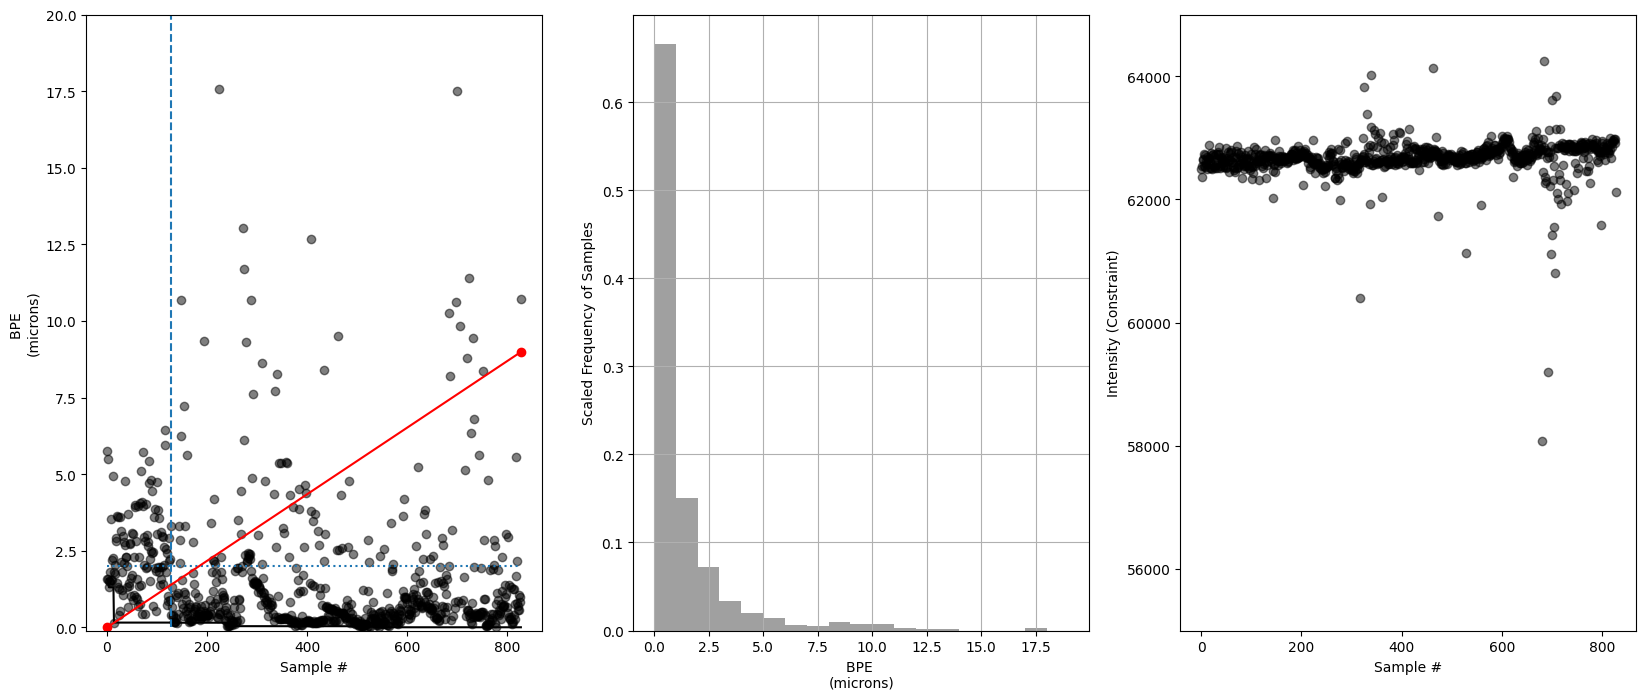

In [27]:
y1 = X.data["f"]
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,3,1)
y1_maxs = np.minimum.accumulate(y1)
ax1.plot(y1, 'ok', alpha=0.5)
ax1.plot(y1_maxs, 'k')
#plt.hlines(1, 0, len(y1_maxs), linestyles="dotted")
ax1.vlines(n_init, 0, 20, linestyles="dashed")
ax1.hlines(2, 0, len(y1), linestyles="dotted")
ax1.set_ylabel("BPE \n(microns)")
ax1.set_xlabel("Sample #")
ax1.set_ylim(-0.1, 20)


a=[0, len(y1)]
b=[0, 9.0]
for i in range(0, len(a), 2):
    ax1.plot(a[i:i+2], b[i:i+2], 'ro-')

bins = np.arange(0, 20)
ax2 = fig.add_subplot(1,3,2)
ax2.hist(y1[n_init:], density=True, bins=bins, facecolor='gray', alpha=0.75)
ax2.set_ylabel("Scaled Frequency of Samples")
ax2.set_xlabel("BPE \n(microns)")
ax2.grid()


ax3 = fig.add_subplot(1,3,3)
yc = X.data["c"] * 62000
ax3.plot(yc, 'ok', alpha=0.5)
ax3.set_ylabel("Intensity (Constraint)")
ax3.set_xlabel("Sample #")
ax3.set_ylim(55000, 65000)
plt.savefig(f'ConstrainedAnisotropicDriftCorrection_TDBO.png', dpi=200)
plt.show()

In [ ]:
X.data.to_csv('history.csv', index=False)